# Property Category Prediction (Classification Task)

## Objective: 
Use classification models to predict the property type, such as Detached, Condo, or Townhome, based on structural and location-based features.

# DATA DESCRIPTION

## Data Source:

Multiple Listing Service (MLS) real estate data is isolated to Oregon.

## Column Definitions:

| **Original Column Name** | **Correct Spelling**              | **Data Type** | **Definition / Description**                                                           | **Machine Learning Column Name**         |
|-------------------------|----------------------------------|--------------|----------------------------------------------------------------------------------------|----------------------------------------|
| MLS#                   | MLS Number                      | integer      | A unique identifier assigned to a listing in the Multiple Listing Service (MLS)        | mls_number                             |
| Type                   | Type                            | string       | Type of property (e.g., Residential, Condo, Multi-Family)                              | property_type                           |
| Prop. Cat.             | Property Category               | string       | Category of property (e.g., Detached, Attached, Condo)                                 | property_category                       |
| Prop. Cond.            | Property Condition              | string       | The condition of the property (e.g., New, Fixer, Resale)                               | property_condition                      |
| Tax                    | Tax                             | float        | Annual property tax amount                                                             | annual_property_tax                     |
| Address                | Address                         | string       | Street address of the property                                                         | street_address                          |
| City                   | City                            | string       | City where the property is located                                                     | city                                   |
| Zip                    | Zip Code                        | integer      | Postal ZIP code for the property                                                       | zip_code                               |
| Area                   | Area                            | string       | MLS-defined area or neighborhood code                                                  | mls_defined_area                        |
| BD                     | Bedrooms                        | integer      | Number of bedrooms in the property                                                     | number_of_bedrooms                      |
| Baths                  | Bathrooms                       | float        | Number of bathrooms (may include full, half, or ¾ baths)                               | number_of_bathrooms                     |
| # Levels               | Number of Levels                | float        | How many floors or levels the property has                                             | number_of_levels                        |
| Apx Sqft               | Approximate Square Feet         | integer      | Approximate total living square footage                                                | approximate_square_feet                 |
| Price SqFt             | Price per Square Foot           | integer      | Listing price per square foot                                                          | price_per_square_foot                   |
| Sld Price Sqft         | Sold Price per Square Foot      | integer      | Final sold price per square foot                                                       | sold_price_per_square_foot              |
| Lot Size               | Lot Size                        | string       | Size of the property lot (typically in square feet or acres)                           | lot_size                                |
| Pend. Date             | Pending Date                    | string       | Date when the property status changed to "Pending"                                     | pending_date                            |
| DOM                    | Days on Market                  | integer      | Number of days the property was actively listed                                        | days_on_market                          |
| CDOM                   | Cumulative Days on Market       | float        | Total number of days on market, including previous listings                            | cumulative_days_on_market               |
| List Date              | Listing Date                    | string       | Date when the property was listed for sale                                             | listing_date                            |
| List Price             | Listing Price                   | string       | Price at which the property was listed                                                 | listing_price                           |
| Sold Date              | Sold Date                       | string       | Date when the property sale closed                                                     | sold_date                               |
| Price                  | Sold Price                      | string       | Final sale price of the property                                                       | sold_price                              |
| Yr. Built              | Year Built                      | integer      | Year the property was originally built                                                 | year_built                              |
| HOA Dues               | HOA Dues                        | float        | Homeowners Association fees (usually monthly or quarterly)                             | hoa_dues                                |
| # Garage               | Number of Garage Spaces         | integer      | Number of covered garage parking spaces                                                | number_of_garage_spaces                 |
| # Fireplaces           | Number of Fireplaces            | float        | Number of fireplaces in the property                                                   | number_of_fireplaces                    |
| Terms                  | Terms                           | string       | Financing terms (e.g., Cash, FHA, VA, Conventional, Seller Carry)                     | financing_terms                         |


## PROPERTY TYPES:

| **Property Type** | **Meaning** | **Explanation** |
|-------------------|------------|----------------|
| **detachd** | Detached Single-Family Home | A stand-alone house that does not share walls with any other unit. This is your typical single-family house on its own lot. |
| **condo** | Condominium | An individual unit in a larger building or community where you own the interior space but share common areas (hallways, pool, etc.). |
| **attachd** | Attached Single-Family (Townhouse/Rowhouse) | A home that shares one or more walls with neighbors but has its own entrance and usually its own lot (e.g., townhome, duplex unit). |
| **in-park** | Manufactured Home in a Park | A mobile/manufactured home located in a designated mobile home park, usually on leased land. |
| **flthome** | Floating Home | A house that literally floats on water (marina home, houseboat). You own the structure but often lease the moorage. |
| **res-mfg** | Residential Manufactured Home (on Land) | A factory-built home placed on a permanent foundation, typically outside a park — the buyer owns the land and home together. |
| **plncomm** | Planned Community Home | A home that is part of a master-planned development with shared amenities (HOA, parks, golf courses, etc.). Sometimes used for cluster housing. |


# IMPORT LIBRARIES

In [273]:
import pandas as pd
import numpy as np
import re
import shap
from pathlib import Path

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
import optuna, lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import lightgbm as lgb
from sklearn.base import clone
from xgboost import XGBClassifier
from optuna.integration import XGBoostPruningCallback
import xgboost as xgb
from xgboost.callback import EarlyStopping
from lazypredict.Supervised import LazyClassifier

# Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, label_binarize

# Class Imbalance
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, cross_val_score

# Model Metrics
from sklearn.metrics import (
    f1_score, precision_recall_fscore_support, precision_recall_curve, confusion_matrix,
    classification_report, roc_auc_score, make_scorer, accuracy_score
)

# Paul additions
from collections import Counter
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate
from sklearn.metrics import precision_score, recall_score
import pickle

# 1. DATA CLEANING

## 1.1 Load Data

In [274]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

# Load the dataset
#data = pd.read_csv("/Users/SabrinaMcField/Desktop/homeservices_real_estate_externship_sep_2025/Homeservices_Project/Dataset.csv")
data = pd.read_csv("Dataset.csv")

In [275]:
# Get a general overview of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11932 entries, 0 to 11931
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MLS#            11932 non-null  object
 1   Type            11932 non-null  object
 2   Prop. Cat.      11932 non-null  object
 3   Prop. Cond.     11926 non-null  object
 4   Tax             11932 non-null  object
 5   Address         11932 non-null  object
 6   City            11932 non-null  object
 7   Zip             11932 non-null  object
 8   Area            11932 non-null  object
 9   BD              11932 non-null  object
 10  Baths           11932 non-null  object
 11  # Levels        11928 non-null  object
 12  Apx Sqft        11930 non-null  object
 13  Price SqFt      11930 non-null  object
 14  Sld Price Sqft  11930 non-null  object
 15  Lot Size        9640 non-null   object
 16  Pend. Date      11932 non-null  object
 17  DOM             11932 non-null  object
 18  CDOM  

In [276]:
# View the dataset
data

,MLS#,Type,Prop. Cat.,Prop. Cond.,Tax,Address,City,Zip,Area,BD,Baths,# Levels,Apx Sqft,Price SqFt,Sld Price Sqft,Lot Size,Pend. Date,DOM,CDOM,List Date,List Price,Sold Date,Price,Yr. Built,HOA Dues,# Garage,# Fireplaces,Terms
0,24094392,FLTHOME,RES,FIXER,1125.05,229 N Bridgeton RD,Portland,97217,$141,0,1,1,384,49,39,"0-2,999SF",2/11/2024,1,NaN,2/10/2024,"$19,000",2/21/2024,"$15,000",1960,NaN,0,0,CASH
1,24585502,IN-PARK,RES,RESALE,500,1503 N HAYDEN ISLAND DR #50,Portland,97217,141,2,1,1,672,37,38,"0-2,999SF",3/15/2024,3,3,3/12/2024,"$25,000",4/4/2024,"$26,000",1970,NaN,0,NaN,CASH
2,755197545,IN-PARK,RES,FIXER,0,12335 N SOUTH SHORE AVE,Portland,97217,$141,2,2,1,1248,22,22,"0-2,999SF",4/24/2025,6,6,4/18/2025,"$28,500",6/1/2025,"$28,500",1975,NaN,3,NaN,CASH
3,24597666,IN-PARK,RES,REMOD,0,1501 N HAYDEN ISLAND DR #121e,Portland,97217,141,2,1,1,580,86,77,"0-2,999SF",8/31/2024,148,148,4/5/2024,"$49,985",9/18/2024,"$45,000",1966,NaN,2,NaN,"CASH, CONV"
4,534808277,IN-PARK,RES,RESALE,0,12405 N SOUTH SHORE AVE,Portland,97217,$141,2,2,1,924,50,50,"0-2,999SF",3/8/2025,29,96,2/7/2025,"$46,999",3/21/2025,"$46,999",1979,NaN,0,NaN,"CASH, OTHER"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11927,24586087,DETACHD,RES,RESALE,4582.54,5218 SE REDBERRY PL,Hillsboro,97123,152,3,2.1,2,2225,251,251,"3K-4,999SF",8/26/2024,10,10,8/16/2024,"$560,000",9/6/2024,"$560,000",2010,75,2,1,"CASH, CONV, FHA, VA"
11928,24588676,DETACHD,RES,REMOD,4490.09,1281 NE PLATT ST,Hillsboro,97124,152,3,2.1,2,1643,349,340,"3K-4,999SF",11/26/2024,40,40,10/17/2024,"$574,900",12/23/2024,"$560,000",2000,263,2,1,"CASH, CONV"
11929,24600878,ATTACHD,RES,RESALE,4912.74,10534 NE PARK RIDGE WAY,Hillsboro,97006,152,3,3,3,1902,276,294,"0-2,999SF",4/16/2024,5,5,4/11/2024,"$525,000",6/10/2024,"$560,000",2014,145,1,1,"CASH, CONV, VA"
11930,24661646,DETACHD,RES,RESALE,5002.23,6162 NE ROSEBAY DR,Hillsboro,97124,152,2,2,1,1479,395,378,"3K-4,999SF",9/28/2024,8,8,9/20/2024,"$585,000",10/16/2024,"$560,000",1998,581,2,1,"CASH, CONV, VA"


Before any changes happen, let's check for duplicated rows.

In [277]:
# Find duplicate rows (True = duplicate)
duplicates = data.duplicated()

# View just the duplicates
duplicate_rows = data[duplicates]

print(f"Found {duplicate_rows.shape[0]} duplicate rows")
duplicate_rows.head()

Found 0 duplicate rows


,MLS#,Type,Prop. Cat.,Prop. Cond.,Tax,Address,City,Zip,Area,BD,Baths,# Levels,Apx Sqft,Price SqFt,Sld Price Sqft,Lot Size,Pend. Date,DOM,CDOM,List Date,List Price,Sold Date,Price,Yr. Built,HOA Dues,# Garage,# Fireplaces,Terms


## 1.2 Drop Irrelavant Columns and Rename Relevant Columns

Before cleaning the data, I'm going to reduce the dataset to only location and structural data relevant to solving our business problem.

In [278]:
data.columns

Index(['MLS#', 'Type', 'Prop. Cat.', 'Prop. Cond.', 'Tax', 'Address', 'City',
       'Zip', 'Area', 'BD', 'Baths', '# Levels', 'Apx Sqft', 'Price SqFt',
       'Sld Price Sqft', 'Lot Size', 'Pend. Date', 'DOM', 'CDOM', 'List Date',
       'List Price', 'Sold Date', 'Price', 'Yr. Built', 'HOA Dues', '# Garage',
       '# Fireplaces', 'Terms'],
      dtype='object')

In [279]:
# Drop unnecessary columns and keep columns relevant to the classification problem per the stakeholder
data = data.drop(columns=['MLS#', 'Prop. Cat.', 'Tax', 'Address', 'Price SqFt',
       'Sld Price Sqft', 'Lot Size', 'Pend. Date', 'List Date', "CDOM",
       'Sold Date','Terms'])

In [280]:
# Lowercase and edit column names for clarity
data = data.rename(columns={
    "Type": "property_type",
    "Prop. Cond.": "property_condition",
    "City": "city",
    "Zip": "zip_code",
    "Area": "area",
    "BD": "bedrooms",
    "Baths": "bathrooms",
    "# Levels": "num_levels",
    "Apx Sqft": "approx_sqft",
    "DOM": "days_on_market",
    "List Price": "list_price",
    "Price": "price",
    "Yr. Built": "year_built",
    "HOA Dues": "hoa_dues",
    "# Garage": "num_garage",
    "# Fireplaces": "num_fireplaces"
})

In [281]:
# View the data
data

,property_type,property_condition,city,zip_code,area,bedrooms,bathrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces
0,FLTHOME,FIXER,Portland,97217,$141,0,1,1,384,1,"$19,000","$15,000",1960,NaN,0,0
1,IN-PARK,RESALE,Portland,97217,141,2,1,1,672,3,"$25,000","$26,000",1970,NaN,0,NaN
2,IN-PARK,FIXER,Portland,97217,$141,2,2,1,1248,6,"$28,500","$28,500",1975,NaN,3,NaN
3,IN-PARK,REMOD,Portland,97217,141,2,1,1,580,148,"$49,985","$45,000",1966,NaN,2,NaN
4,IN-PARK,RESALE,Portland,97217,$141,2,2,1,924,29,"$46,999","$46,999",1979,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11927,DETACHD,RESALE,Hillsboro,97123,152,3,2.1,2,2225,10,"$560,000","$560,000",2010,75,2,1
11928,DETACHD,REMOD,Hillsboro,97124,152,3,2.1,2,1643,40,"$574,900","$560,000",2000,263,2,1
11929,ATTACHD,RESALE,Hillsboro,97006,152,3,3,3,1902,5,"$525,000","$560,000",2014,145,1,1
11930,DETACHD,RESALE,Hillsboro,97124,152,2,2,1,1479,8,"$585,000","$560,000",1998,581,2,1


## 1.3 Clean Up Data

The `area` column represents neighborhood category and holds a variation of numerical values, including a '$' and '.00'. It also contains unecessary whitespace in front of the values.

I'll remove those to be a single numerical value. The `list_price` and `price` column include '$' and '.00' and will also be removed to represent a numerical value.

In [282]:
# Remove '$' from values in the 'area' column
data['area'] = data['area'].str.replace("$", " ", regex=False)

# If it should be treated as string categories:
data['area'] = (
    data['area']
    .astype(str)               # unify type
    .str.strip()               # remove extra spaces
    .str.normalize('NFKC')     # normalize Unicode
)

# Remove '$' and ',' from values in the 'price' and 'list_price' column
data['list_price'] = data['list_price'].str.replace(",", "", regex=False)
data['list_price'] = data['list_price'].str.replace("$", "", regex=False)
data['price'] = data['price'].str.replace("$", "", regex=False)
data['price'] = data['price'].str.replace(",", "", regex=False)

In [283]:
# Remove '.00' from values in 'area', 'list_price', and 'price' column
data['area'] = data['area'].str.replace(".00","", regex=False)
data['list_price'] = data['list_price'].str.replace(".00", "", regex=False)
data['price'] = data['price'].str.replace(".00", "", regex=False)

In [284]:
# Remove all rows where num_garage == 14 (apply directly to the dataset)
data.drop(index=data.index[data["num_garage"] == 14], inplace=True)
data.reset_index(drop=True, inplace=True)

Normalize all of the string values to lowercase.

In [285]:
# Apply lowercase to all string columns in the DataFrame
data = data.map(lambda x: x.lower() if isinstance(x, str) else x)

Address Missing Values

- **`approx_sqft`** – Remove these 2 rows  
- **`num_levels`** – Replace `NaN` with **1** (default value = 1)  
- **`hoa_dues`** – Replace `NaN` with **0** (default value = 0)
- **`num_fireplaces`** – Replace `NaN` with **0** (default value = 0)
- **`property_condition`** – Fill with top occuring instance

In [286]:
# View missing values
data.isna().sum()

property_type            0
property_condition       6
city                     0
zip_code                 0
area                     0
bedrooms                 0
bathrooms                0
num_levels               4
approx_sqft              2
days_on_market           0
list_price               0
price                    0
year_built               0
hoa_dues              7217
num_garage               0
num_fireplaces        3832
dtype: int64

In [287]:
# Rows where property_condition is missing (NaN)
rows_missing = data.loc[data["property_condition"].isna()]
print(f"Rows with missing property_condition: {len(rows_missing)}")
rows_missing

Rows with missing property_condition: 6


,property_type,property_condition,city,zip_code,area,bedrooms,bathrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces
1501,detachd,NaN,portland,97217,141,5,1,3,2869,33,599000,599000,1912,NaN,0,1
1837,detachd,NaN,portland,97203,141,5,4,4,2754,108,834990,822000,2011,NaN,1,1
1896,detachd,NaN,portland,97217,141,1,1,1,1105,9,275000,265016,1925,NaN,0,NaN
1898,detachd,NaN,portland,97217,141,3,2,3,2354,6,375000,455000,1908,NaN,0,0
1899,detachd,NaN,portland,97203,141,5,2,4,4200,21,500000,480000,1908,NaN,0,1
2534,detachd,NaN,portland,97213,142,2,1,1,902,54,374900,366500,1912,NaN,0,NaN


In [288]:
# View the top "property_condition" for detachd "property_type" and use that value to fill the missing values
data.describe()

,property_type,property_condition,city,zip_code,area,bedrooms,bathrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces
count,11932,11926,11932,11932,11932,11932,11932,11928,11930,11932,11932,11932,11932,4715,11932,8100
unique,8,12,15,45,7,11,24,6,2704,383,1851,2502,142,754,11,7
top,detachd,resale,portland,97217,142,3,2,2,1520,4,399900,400000,2024,50,2,1
freq,7705,6540,5966,997,2000,5711,3435,5436,101,971,249,192,960,118,4506,5947


Initially, I handled missing values in the `hoa_dues` column with zero per the client's instruction.  After analyzing the column further, I discovered that `hoa_dues` are proxy to attached and condo property types.  Since these property types are underrepresented in the data set, it's important to have as much complete information as possible to identify them. So, I decided to replace the missing values in `hoa_dues` with the median in the respective property types. I did however, proceed to fill in missing values for the 'detached' property type with zero because hoa_dues are negatively correlated to it.

In [289]:
# Group the 'hoa_dues' by area to get a general idea of distribution pattern
data.groupby('area')['hoa_dues'].value_counts().reset_index(name='count')

,area,hoa_dues,count
0,141,50,34
1,141,40,15
2,141,24,14
3,141,480,14
4,141,364,11
...,...,...,...
1553,152,88,1
1554,152,93,1
1555,152,96,1
1556,152,99,1


In [290]:
# View the missing values by area
data.groupby('area')['hoa_dues'].apply(lambda x: x.isna().sum()).reset_index(name='missing_count')

,area,missing_count
0,141,1449
1,142,1448
2,143,1383
3,147,1130
4,150,928
5,152,879
6,area,0


In [291]:
# normalize property_type for filtering
data['property_type'] = data['property_type'].astype(str).str.strip().str.lower()

# robust numeric parse for HOA dues (handles $, commas, "per month", etc.)
data['hoa_dues'] = (
    data['hoa_dues'].astype(str)
      .str.replace(r'(?i)\$|,|usd|/mo|per\s*month|monthly', '', regex=True)
      .str.extract(r'(-?\d+(?:\.\d+)?)', expand=False)
      .pipe(pd.to_numeric, errors='coerce')
)

In [292]:
# Group and aggreate mean, median and mode for each property type (attached and condo)
hoa_stats = (
    data[data['property_type'].isin(['attachd', 'condo'])]
    .groupby('property_type')['hoa_dues']
    .agg(
        count='count',
        missing=lambda x: x.isna().sum(),
        mean='mean',
        median='median',
        mode=lambda x: x.mode().iloc[0] if not x.mode().empty else None
    )
)
hoa_stats['missing_pct'] = hoa_stats['missing'] / (hoa_stats['count'] + hoa_stats['missing']) * 100
print(hoa_stats)

               count  missing   mean  median   mode  missing_pct
property_type                                                   
attachd         1150      341 268.53  244.50 172.00        22.87
condo           2261       29 330.51  338.00  50.00         1.27


In [293]:
# Create a copy of the dataset that will hold 0 for missing values in hoa_dues
data_2 = data.copy()

In [294]:
# Compute median per property_type
medians = data.groupby('property_type')['hoa_dues'].median()

# Impute missing HOA dues using property-type median
data['hoa_dues'] = data.apply(
    lambda row: medians[row['property_type']] if pd.isna(row['hoa_dues']) else row['hoa_dues'],
    axis=1
)

In [295]:
# Sanity check
hoa_stats['missing_pct'] = hoa_stats['missing'] / (hoa_stats['count'] + hoa_stats['missing']) * 100
print(hoa_stats)

               count  missing   mean  median   mode  missing_pct
property_type                                                   
attachd         1150      341 268.53  244.50 172.00        22.87
condo           2261       29 330.51  338.00  50.00         1.27


In [296]:
# Replace missing values with 0
data['num_fireplaces'] = data['num_fireplaces'].fillna(0)
#data['hoa_dues'] = data['hoa_dues'].fillna(0).round().astype(int)

# Replace missing value with top instance
data['property_condition'] = data['property_condition'].fillna('resale')

# Fill missing values with 1 in the 'num_levels' columns
data['num_levels'] = data['num_levels'].fillna(1)

Repeat on the (0)hoa_due dataset

In [297]:
# Replace missing values with 0
data_2['num_fireplaces'] = data_2['num_fireplaces'].fillna(0)
data_2['hoa_dues'] = data_2['hoa_dues'].fillna(0).round().astype(int)

# Replace missing value with top instance
data_2['property_condition'] = data_2['property_condition'].fillna('resale')

# Fill missing values with 1 in the 'num_levels' columns
data_2['num_levels'] = data_2['num_levels'].fillna(1)

Since we have more than enough 'detachd' 'property_type' instances, Im going to just drop the two rows with missing 'approx_sqft'.

In [298]:
# Drop rows where approx_sqft is missing
data = data.dropna(subset=['approx_sqft'])

In [299]:
# Drop rows where approx_sqft is missing
data_2 = data_2.dropna(subset=['approx_sqft'])

In [300]:
# Check changes applied
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11930 entries, 0 to 11931
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   property_type       11930 non-null  object 
 1   property_condition  11930 non-null  object 
 2   city                11930 non-null  object 
 3   zip_code            11930 non-null  object 
 4   area                11930 non-null  object 
 5   bedrooms            11930 non-null  object 
 6   bathrooms           11930 non-null  object 
 7   num_levels          11930 non-null  object 
 8   approx_sqft         11930 non-null  object 
 9   days_on_market      11930 non-null  object 
 10  list_price          11930 non-null  object 
 11  price               11930 non-null  object 
 12  year_built          11930 non-null  object 
 13  hoa_dues            11929 non-null  float64
 14  num_garage          11930 non-null  object 
 15  num_fireplaces      11930 non-null  object 
dtypes: float6

Two datasets were created;
- **`data`** holds the missing values in hoa_dues as the median for its respective property type
- **`data_2`** holds the missing values in hoa_dues as 0

The following key numeric features have datatypes of object or float and will have to be converted to integers.

- **`bedrooms`**
- **`bathrooms`**
- **`num_levels`**
- **`approx_sqft`**
- **`days_on_market`**
- **`list_price`**
- **`price`**
- **`hoa_dues`**
- **`num_garage`**
- **`num_fireplaces`**

This will be a datetime data type
- **`year_built`**

These will be a category data types
- **`property_type`**
- **`property_condition`**
- **`city`**
- **`area`**
- **`zip_code`**

In [301]:
# Create a boolean mask for all columns where value == 'bd'
mask = data.apply(lambda col: col.astype(str).str.contains(r'\bbd\b', case=False, na=False))

# Show rows where any column has 'bd'
rows_with_bd = data[mask.any(axis=1)]
rows_with_bd

,property_type,property_condition,city,zip_code,area,bedrooms,bathrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces
9931,type,prop. cond.,city,zip,area,bd,baths,# levels,apx sqft,dom,list price,price,yr. built,NaN,# garage,# fireplaces


In [302]:
# Create a boolean mask for all columns where value == 'bd'
mask = data_2.apply(lambda col: col.astype(str).str.contains(r'\bbd\b', case=False, na=False))

# Show rows where any column has 'bd'
rows_with_bd_2 = data_2[mask.any(axis=1)]
rows_with_bd_2

,property_type,property_condition,city,zip_code,area,bedrooms,bathrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces
9931,type,prop. cond.,city,zip,area,bd,baths,# levels,apx sqft,dom,list price,price,yr. built,0,# garage,# fireplaces


After trying to convert the rows into integer datatypes, it kept throwing an error because of this row that repeats the column names. This row will be dropped.

In [303]:
# Drop this row
data = data[~data['bedrooms'].astype(str).str.contains(r'\bbd\b', case=False, na=False)]

In [304]:
# Drop this row
data_2 = data_2[~data_2['bedrooms'].astype(str).str.contains(r'\bbd\b', case=False, na=False)]

Bathrooms are currently represented with a value such as '2.1', indicating full baths with the number in front of the decimal and half baths represented by the number after the decimal. This column with be split into **`full_bath`** and **`half_bath`** columns to represent bathroom values more directly.

In [305]:
# Split bathrooms into full and half baths
bath_split = data['bathrooms'].astype(str).str.split('.', expand=True)

data['full_bath'] = pd.to_numeric(bath_split[0], errors='coerce').astype("Int64")
data['half_bath'] = pd.to_numeric(bath_split[1], errors='coerce').fillna(0).astype("Int64")
data = data.drop(columns=['bathrooms'])

In [306]:
# Split bathrooms into full and half baths
bath_split_2 = data_2['bathrooms'].astype(str).str.split('.', expand=True)

data_2['full_bath'] = pd.to_numeric(bath_split[0], errors='coerce').astype("Int64")
data_2['half_bath'] = pd.to_numeric(bath_split[1], errors='coerce').fillna(0).astype("Int64")
data_2 = data_2.drop(columns=['bathrooms'])

In [307]:
# Convert the following columns into Int
cols_to_int = [
    'bedrooms','num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price',
    'num_garage', 'num_fireplaces'
]

for col in cols_to_int:
    # Coerce to numeric (turns bad values into NaN)
    data[col] = pd.to_numeric(data[col], errors="coerce")
    
    # Convert to nullable integer
    data[col] = data[col].astype("Int64")

# Verify
print(data[cols_to_int].dtypes)

bedrooms          Int64
num_levels        Int64
approx_sqft       Int64
days_on_market    Int64
list_price        Int64
price             Int64
num_garage        Int64
num_fireplaces    Int64
dtype: object


In [308]:
# Convert the following columns into Int
cols_to_int = [
    'bedrooms','num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price',
    'num_garage', 'num_fireplaces'
]

for col in cols_to_int:
    # Coerce to numeric (turns bad values into NaN)
    data_2[col] = pd.to_numeric(data_2[col], errors="coerce")
    
    # Convert to nullable integer
    data_2[col] = data_2[col].astype("Int64")

# Verify
print(data_2[cols_to_int].dtypes)

bedrooms          Int64
num_levels        Int64
approx_sqft       Int64
days_on_market    Int64
list_price        Int64
price             Int64
num_garage        Int64
num_fireplaces    Int64
dtype: object


In [309]:
# Convert year to numeric
data['year_built'] = pd.to_numeric(data['year_built'], errors='coerce').astype('Int64')

In [310]:
# Convert year to numeric
data_2['year_built'] = pd.to_numeric(data_2['year_built'], errors='coerce').astype('Int64')

In [311]:
# Straightforward categoricals
for col in ["property_type", "property_condition", "city", "area"]:
    if col in data.columns:
        data[col] = data[col].astype("category")

# zip_code — normalize then make categorical
# (handles numeric ZIPs, preserves leading zeros, keeps NaNs)
if "zip_code" in data.columns:
    zip_num = pd.to_numeric(data["zip_code"], errors="coerce").round().astype("Int64")
    data["zip_code"] = zip_num.astype("string").str.zfill(5).astype("category")

# Quick check
print(data[["property_type","property_condition","city","area","zip_code"]].dtypes)

property_type         category
property_condition    category
city                  category
area                  category
zip_code              category
dtype: object


In [312]:
# Straightforward categoricals
for col in ["property_type", "property_condition", "city", "area"]:
    if col in data_2.columns:
        data_2[col] = data_2[col].astype("category")

# zip_code — normalize then make categorical
# (handles numeric ZIPs, preserves leading zeros, keeps NaNs)
if "zip_code" in data_2.columns:
    zip_num = pd.to_numeric(data_2["zip_code"], errors="coerce").round().astype("Int64")
    data_2["zip_code"] = zip_num.astype("string").str.zfill(5).astype("category")

# Quick check
print(data_2[["property_type","property_condition","city","area","zip_code"]].dtypes)

property_type         category
property_condition    category
city                  category
area                  category
zip_code              category
dtype: object


In [313]:
# Check changes applied
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11929 entries, 0 to 11931
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   property_type       11929 non-null  category
 1   property_condition  11929 non-null  category
 2   city                11929 non-null  category
 3   zip_code            11929 non-null  category
 4   area                11929 non-null  category
 5   bedrooms            11929 non-null  Int64   
 6   num_levels          11929 non-null  Int64   
 7   approx_sqft         11929 non-null  Int64   
 8   days_on_market      11929 non-null  Int64   
 9   list_price          11923 non-null  Int64   
 10  price               11929 non-null  Int64   
 11  year_built          11929 non-null  Int64   
 12  hoa_dues            11929 non-null  float64 
 13  num_garage          11929 non-null  Int64   
 14  num_fireplaces      11929 non-null  Int64   
 15  full_bath           11929 non-null  Int64

Allowed values for `property_type` are as follows so we will drop all other instances;

- `DETACHD`
- `CONDO`
- `ATTACHD`

In [314]:
# View all of the types
data['property_type'].value_counts()

property_type
detachd    7703
condo      2290
attachd    1491
in-park     307
flthome      82
res-mfg      46
plncomm      10
Name: count, dtype: int64

In [315]:
data_2["property_type"].value_counts()

property_type
detachd    7703
condo      2290
attachd    1491
in-park     307
flthome      82
res-mfg      46
plncomm      10
Name: count, dtype: int64

In [316]:
# Remove categorical rows and their values
data = data.loc[~data["property_type"].isin(["in-park", "flthome", "res-mfg", "plncomm"])].copy()
data["property_type"] = data["property_type"].cat.remove_unused_categories()

In [317]:
# Remove categorical rows and their values
data_2 = data_2.loc[~data_2["property_type"].isin(["in-park", "flthome", "res-mfg", "plncomm"])].copy()
data_2["property_type"] = data_2["property_type"].cat.remove_unused_categories()

In [318]:
data['property_type'].value_counts()

property_type
detachd    7703
condo      2290
attachd    1491
Name: count, dtype: int64

In [319]:
data_2['property_type'].value_counts()

property_type
detachd    7703
condo      2290
attachd    1491
Name: count, dtype: int64

Allowed values for `City` are as follows so we will drop all other instances;

- `Portland`
- `Beaverton`
- `Hillsboro`
- `Lake Oswego`
- `West Link (try)`

In [320]:
# View all of the types
data['city'].value_counts()

city
portland        5745
beaverton       1849
hillsboro       1282
lake oswego     1222
west linn        752
forest grove     323
cornelius        243
aloha             29
gaston            22
tualatin           7
gresham            4
gales creek        3
milwaukie          2
newberg            1
Name: count, dtype: int64

In [321]:
# Clean the city column
data['city'] = data['city'].str.strip().str.lower()

# Redefine your list (no trailing spaces!)
cities_to_drop = [
    "forest grove", "cornelius", "aloha", "gaston",
    "tualatin", "gresham", "gales creek", "milwaukie", "newberg"
]

# Drop the unwanted cities
data = data[~data['city'].isin(cities_to_drop)].reset_index(drop=True)

In [322]:
# Clean the city column
data_2['city'] = data_2['city'].str.strip().str.lower()

# Redefine your list (no trailing spaces!)
cities_to_drop = [
    "forest grove", "cornelius", "aloha", "gaston",
    "tualatin", "gresham", "gales creek", "milwaukie", "newberg"
]

# Drop the unwanted cities
data_2 = data_2[~data_2['city'].isin(cities_to_drop)].reset_index(drop=True)

In [323]:
data['city'].value_counts()

city
portland       5745
beaverton      1849
hillsboro      1282
lake oswego    1222
west linn       752
Name: count, dtype: int64

In [324]:
data_2['city'].value_counts()

city
portland       5745
beaverton      1849
hillsboro      1282
lake oswego    1222
west linn       752
Name: count, dtype: int64

In [325]:
# Check that datatypes have changed to integer for numerical values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   property_type       10850 non-null  category
 1   property_condition  10850 non-null  category
 2   city                10850 non-null  object  
 3   zip_code            10850 non-null  category
 4   area                10850 non-null  category
 5   bedrooms            10850 non-null  Int64   
 6   num_levels          10850 non-null  Int64   
 7   approx_sqft         10850 non-null  Int64   
 8   days_on_market      10850 non-null  Int64   
 9   list_price          10846 non-null  Int64   
 10  price               10850 non-null  Int64   
 11  year_built          10850 non-null  Int64   
 12  hoa_dues            10850 non-null  float64 
 13  num_garage          10850 non-null  Int64   
 14  num_fireplaces      10850 non-null  Int64   
 15  full_bath           10850 non-null  

In [326]:
# Check that datatypes have changed to integer for numerical values
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   property_type       10850 non-null  category
 1   property_condition  10850 non-null  category
 2   city                10850 non-null  object  
 3   zip_code            10850 non-null  category
 4   area                10850 non-null  category
 5   bedrooms            10850 non-null  Int64   
 6   num_levels          10850 non-null  Int64   
 7   approx_sqft         10850 non-null  Int64   
 8   days_on_market      10850 non-null  Int64   
 9   list_price          10846 non-null  Int64   
 10  price               10850 non-null  Int64   
 11  year_built          10850 non-null  Int64   
 12  hoa_dues            10850 non-null  int64   
 13  num_garage          10850 non-null  Int64   
 14  num_fireplaces      10850 non-null  Int64   
 15  full_bath           10850 non-null  

Save cleaned datasets into a csv file

In [327]:
# Folder to write files into
outdir = Path("exports")
outdir.mkdir(exist_ok=True)

# Optional: timestamp to avoid overwriting
stamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H%M")

def save_csv(df, name):
    path = outdir / f"{name}_{stamp}.csv"
    df.to_csv(path, index=False, encoding="utf-8", na_rep="")
    print(f"Saved {name}: {path.resolve()}  ({len(df):,} rows × {df.shape[1]} cols)")

save_csv(data_2, "data_2_cleaned")
save_csv(data,   "data_cleaned")

Saved data_2_cleaned: C:\Users\palon\Desktop\GitHub Repository\homeservices_real_estate_externship_sep_2025\exports\data_2_cleaned_2025-10-20_1106.csv  (10,850 rows × 17 cols)
Saved data_cleaned: C:\Users\palon\Desktop\GitHub Repository\homeservices_real_estate_externship_sep_2025\exports\data_cleaned_2025-10-20_1106.csv  (10,850 rows × 17 cols)


<div style="padding:10px; border-radius:8px;">

## 1.4 SUMMARY OF DATA CLEANING

- **Dropped unnecessary columns** and kept only those relevant to the **classification problem** per the stakeholder direction.
- **Lowercased** and **renamed columns** for clarity and standardization.
- Addressed missing values:
  - **`approx_sqft`** – Remove these 2 rows  
  - **`num_levels`** – Replace `NaN` with **1** (default value = 1)  
  - **`hoa_dues`** – Replace `NaN` with **0** (default value = 0) for 'detachd' and used the median for 'condo' and 'attachd'
  - **`num_fireplaces`** – Replace `NaN` with **0** (default value = 0)
  - **`property_condition`** – Fill with top occuring instance
  - **`property_type`** - Filled with the top occurring instance in the column 'detachd'.
- Cleaned **`area`**:
  - Removed **"$"** and whitespace, since this column represents **neighborhood categories**.
- **Removed categorical rows and values** in **`property_type`** and only kept:
  - `DETACHD`
  - `CONDO`
  - `ATTACHD`
- **Removed rows** in **`city`** and only kept:
  - `Portland`
  - `Beaverton`
  - `Hillsboro`
  - `Lake Oswego`
  - `West Link (try)`
- **Lowercased all string values** in the dataset for consistency.
- **Removed 2 rows** with missing **`approx_sqft`**.
- Split **`bathrooms`** into:
  - **`full_bath`**
  - **`half_bath`**
  - This provides more specificity and allows conversion to integers.
- **Dropped a row** that accidentally contained string column names as data.
- **Coerced columns** (stored as objects) into proper numeric type or datetime or category datatype.
- Two datasets were created;
  - **`data`** holds the missing values in hoa_dues as the median for its respective property type
  - **`data_2`** holds the missing values in hoa_dues as 0

</div>

# 2. EXPLORATORY DATA ANALYSIS

In [328]:
# Get a statistical overview of the cleaned dataset
data.describe()

,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath
count,10850.00,10850.00,10850.00,10850.00,10846.00,10850.00,10850.00,10850.00,10850.00,10850.00,10850.00,10850.00
mean,2.84,1.77,1614.84,42.54,520937.38,517487.88,1977.41,198.02,1.22,0.74,1.77,0.43
std,0.88,0.71,799.82,63.03,316254.08,306687.32,33.46,214.01,0.91,0.70,0.67,0.51
min,0.00,0.00,330.00,0.00,75000.00,75000.00,1875.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,1.00,1066.00,5.00,369900.00,369000.00,1953.00,115.00,0.00,0.00,1.00,0.00
50%,3.00,2.00,1450.00,19.00,447725.00,445000.00,1979.00,115.00,1.00,1.00,2.00,0.00
75%,3.00,2.00,1884.00,55.00,534875.00,532000.00,2005.00,244.50,2.00,1.00,2.00,1.00
max,10.00,4.00,10883.00,1041.00,3000000.00,2705000.00,2025.00,7500.00,14.00,5.00,6.00,6.00


Summary statistics on detached property_type

In [329]:
# View all rows where property_type is 'detachd'
detached_data = data[data['property_type'] == 'detachd']

# Display the filtered DataFrame
detached_data

,property_type,property_condition,city,zip_code,area,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath
3,detachd,resale,portland,97203,141,2,1,944,28,188431,188431,2007,112.00,1,0,1,0
15,detachd,fixer,portland,97217,141,2,2,1909,29,232750,206000,1926,115.00,1,0,1,0
29,detachd,fixer,portland,97217,141,3,2,1580,0,225000,225000,1908,115.00,0,0,1,0
31,detachd,fixer,portland,97203,141,2,1,660,116,225000,225000,1941,115.00,0,0,1,0
32,detachd,fixer,portland,97203,141,2,2,1000,4,289900,226000,1919,115.00,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10844,detachd,remod,hillsboro,97123,152,3,1,1518,31,554900,560000,1977,115.00,2,1,2,0
10845,detachd,resale,hillsboro,97123,152,3,2,2225,10,560000,560000,2010,75.00,2,1,2,1
10846,detachd,remod,hillsboro,97124,152,3,2,1643,40,574900,560000,2000,263.00,2,1,2,1
10848,detachd,resale,hillsboro,97124,152,2,1,1479,8,585000,560000,1998,581.00,2,1,2,0


In [330]:
# Get a statistical overview of the detached property_type
detached_data.describe()

,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath
count,7207.00,7207.00,7207.00,7207.00,7204.00,7207.00,7207.00,7207.00,7207.00,7207.00,7207.00,7207.00
mean,3.11,1.71,1812.90,36.70,594071.68,590017.99,1965.47,141.45,1.40,0.85,1.78,0.34
std,0.84,0.71,872.57,59.98,355644.55,343461.65,31.60,189.46,0.91,0.75,0.73,0.50
min,0.00,0.00,416.00,0.00,130000.00,100000.00,1875.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,1224.00,5.00,409900.00,410000.00,1947.00,115.00,1.00,0.00,1.00,0.00
50%,3.00,2.00,1584.00,14.00,489900.00,490000.00,1964.00,115.00,1.00,1.00,2.00,0.00
75%,4.00,2.00,2160.00,47.00,579900.00,575000.00,1989.00,115.00,2.00,1.00,2.00,1.00
max,10.00,4.00,10883.00,1041.00,3000000.00,2705000.00,2025.00,7500.00,14.00,5.00,6.00,6.00


In [331]:
# Most frequent city
top_city = detached_data['city'].value_counts().idxmax()
top_city_count = detached_data['city'].value_counts().max()

# Most frequent year
top_year = detached_data['year_built'].value_counts().idxmax()
top_year_count = detached_data['year_built'].value_counts().max()

# Most frequent property condition
top_condition = detached_data['property_condition'].value_counts().idxmax()
top_condition_count = detached_data['property_condition'].value_counts().max()

print(f"Most common city: {top_city} ({top_city_count} occurrences)")
print(f"Most common year: {top_year} ({top_year_count} occurrences)")
print(f"Most common property condition: {top_condition} ({top_condition_count} occurrences)")

Most common city: portland (4046 occurrences)
Most common year: 2024 (174 occurrences)
Most common property condition: resale (4118 occurrences)


Summary statistics on attached property_type

In [332]:
# View all rows where property_type is 'attachd'
attached_data = data[data['property_type'] == 'attachd']

# Display the filtered DataFrame
attached_data

,property_type,property_condition,city,zip_code,area,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath
9,attachd,fixer,portland,97217,141,2,1,1467,89,199000,195000,1912,244.50,0,0,1,0
71,attachd,approx,portland,97217,141,3,1,978,47,265000,259539,1972,189.00,1,0,1,0
110,attachd,fixer,portland,97217,141,3,1,920,1,258000,275000,1973,181.00,1,0,1,0
147,attachd,fixer,portland,97217,141,3,1,988,26,275000,294000,1973,181.00,1,1,1,0
154,attachd,new,portland,97217,141,2,2,914,394,298900,295000,2023,244.50,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10809,attachd,new,hillsboro,97123,152,3,2,1767,75,555550,555550,2023,270.00,2,1,3,1
10819,attachd,new,hillsboro,97123,152,3,2,1767,99,559338,559338,2023,240.00,2,1,3,1
10837,attachd,new,hillsboro,97123,152,3,2,1767,29,570782,560000,2024,240.00,2,1,3,1
10839,attachd,new,hillsboro,97123,152,3,2,1767,34,565010,560000,2024,240.00,2,1,3,1


In [333]:
# Get a statistical overview of the attached property_type
attached_data.describe()

,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath
count,1368.00,1368.00,1368.00,1368.00,1368.00,1368.00,1368.00,1368.00,1368.00,1368.00,1368.00,1368.00
mean,2.69,2.21,1488.19,46.08,450092.11,448444.19,2006.57,275.43,1.35,0.63,1.99,0.84
std,0.58,0.58,367.94,59.75,126825.12,122835.46,17.27,188.09,0.72,0.52,0.45,0.40
min,1.00,1.00,749.00,0.00,174100.00,158000.00,1912.00,0.00,0.00,0.00,1.00,0.00
25%,2.00,2.00,1243.50,6.00,386000.00,387581.25,2000.00,197.75,1.00,0.00,2.00,1.00
50%,3.00,2.00,1484.50,24.00,429250.00,429000.00,2006.00,244.50,1.00,1.00,2.00,1.00
75%,3.00,3.00,1653.25,59.00,494240.00,492117.50,2023.00,300.00,2.00,1.00,2.00,1.00
max,4.00,4.00,3515.00,566.00,1770000.00,1745000.00,2025.00,3689.00,3.00,2.00,5.00,2.00


In [334]:
# Most frequent city
top_city = attached_data['city'].value_counts().idxmax()
top_city_count = attached_data['city'].value_counts().max()

# Most frequent year
top_year = attached_data['year_built'].value_counts().idxmax()
top_year_count = attached_data['year_built'].value_counts().max()

# Most frequent property condition
top_condition = attached_data['property_condition'].value_counts().idxmax()
top_condition_count = attached_data['property_condition'].value_counts().max()

print(f"Most common city: {top_city} ({top_city_count} occurrences)")
print(f"Most common year: {top_year} ({top_year_count} occurrences)")
print(f"Most common property condition: {top_condition} ({top_condition_count} occurrences)")

Most common city: hillsboro (455 occurrences)
Most common year: 2024 (303 occurrences)
Most common property condition: resale (660 occurrences)


Summary statistics on condo property_type

In [335]:
# View all rows where property_type is 'attachd'
condo_data = data[data['property_type'] == 'condo']

# Display the filtered DataFrame
condo_data

,property_type,property_condition,city,zip_code,area,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath
0,condo,resale,portland,97217,141,2,2,1088,11,179777,160000,1972,560.00,0,0,1,1
1,condo,new,portland,97217,141,2,1,764,145,166000,166000,2022,253.00,0,0,1,0
2,condo,new,portland,97217,141,2,1,764,84,166000,166000,2021,233.00,0,0,1,0
4,condo,resale,portland,97203,141,1,1,591,2,189000,189000,1963,263.00,1,0,1,0
5,condo,resale,portland,97217,141,1,1,608,206,189000,189000,1973,248.00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,condo,resale,hillsboro,97124,152,3,1,1354,8,480000,480000,2002,378.00,2,1,2,0
10328,condo,resale,hillsboro,97124,152,2,3,1693,47,495000,498000,2000,523.00,2,1,2,1
10360,condo,approx,beaverton,97006,152,3,2,1544,8,500000,500000,2017,225.00,2,1,2,1
10372,condo,remod,hillsboro,97124,152,2,1,1037,70,499999,500000,2000,385.00,1,1,2,0


In [336]:
# Get a statistical overview of the condo property_type
condo_data.describe()

,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath
count,2275.00,2275.00,2275.00,2275.00,2274.00,2275.00,2275.00,2275.00,2275.00,2275.00,2275.00,2275.00
mean,2.05,1.72,1063.56,58.90,331868.24,329236.14,1997.69,330.70,0.59,0.45,1.59,0.48
std,0.64,0.67,346.26,70.89,104767.34,104177.48,24.99,228.32,0.70,0.52,0.53,0.50
min,0.00,0.00,330.00,0.00,75000.00,75000.00,1890.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,1.00,844.50,10.00,275000.00,272500.00,1979.00,123.00,0.00,0.00,1.00,0.00
50%,2.00,2.00,986.00,34.00,324000.00,320000.00,2004.00,338.00,0.00,0.00,2.00,0.00
75%,2.00,2.00,1247.50,82.00,379000.00,375000.00,2023.00,465.00,1.00,1.00,2.00,1.00
max,5.00,4.00,2958.00,546.00,1595000.00,1595000.00,2025.00,2241.00,3.00,3.00,4.00,2.00


In [337]:
# Most frequent city
top_city = condo_data['city'].value_counts().idxmax()
top_city_count = condo_data['city'].value_counts().max()

# Most frequent year
top_year = condo_data['year_built'].value_counts().idxmax()
top_year_count = condo_data['year_built'].value_counts().max()

# Most frequent property condition
top_condition = condo_data['property_condition'].value_counts().idxmax()
top_condition_count = condo_data['property_condition'].value_counts().max()

print(f"Most common city: {top_city} ({top_city_count} occurrences)")
print(f"Most common year: {top_year} ({top_year_count} occurrences)")
print(f"Most common property condition: {top_condition} ({top_condition_count} occurrences)")

Most common city: portland (1321 occurrences)
Most common year: 2024 (395 occurrences)
Most common property condition: resale (1143 occurrences)


## 2.1 Heatmap of `property_type` per `area`

In [338]:
# Crosstab: counts of property_type per area
ct = pd.crosstab(data['area'], data['property_type'])

fig = px.imshow(
    ct,
    labels=dict(x="Property Type", y="Area", color="Count"),
    aspect="auto"
)
fig.update_xaxes(side="top")
fig.show()

# Save as an image
fig.write_image("property_type_by_area_heatmap.png", scale=2)

<div style="padding:14px; border-radius:8px;">

### 2.1.1 Area × Property Type Heatmap Interpretation

**What the colors mean:** yellow = more listings (higher count), purple = fewer listings.

**Clear patterns**
- **Detached (detachd) dominates** across most areas, with especially high volumes in **142** and **147** (bright yellow). Areas **150** and **152** are also detached-heavy.
- **Condos** are **concentrated** in a few areas (notably **143** and **150**). Elsewhere they’re sparse.
- **Attached (attachd)** is **low volume** almost everywhere (mostly dark cells).
- **Area 141** shows **low activity** across all types (darker band), suggesting fewer listings overall.

**What this implies for modeling**
- **Area is predictive**: some classes are geographically concentrated (e.g., condos), while detached homes are ubiquitous but especially dense in specific areas.
- Because the heatmap uses **raw counts**, high values may partly reflect **area size or sampling**. 
- To leverage signal while avoiding overfitting:
  - Treat **area** as **categorical** (one-hot or target/frequency encoding) and consider **ZIP/area groupings**.
  - Use **stratified or group-aware CV** (e.g., `GroupKFold` by area/ZIP) to prevent optimistic estimates if certain areas appear only in train or validation.
  - Monitor **per-area confusion matrices/recall** to ensure the model generalizes beyond the most common (detached) regions.

**Bottom line:** area provides a strong, stable signal—especially for identifying **condo-heavy** pockets—while detached volumes drive overall counts. Encode it carefully and validate with group-aware splits to turn this geographic signal into reliable predictions.

</div>

## 2.2 Correlation Chart of features to `property_type`

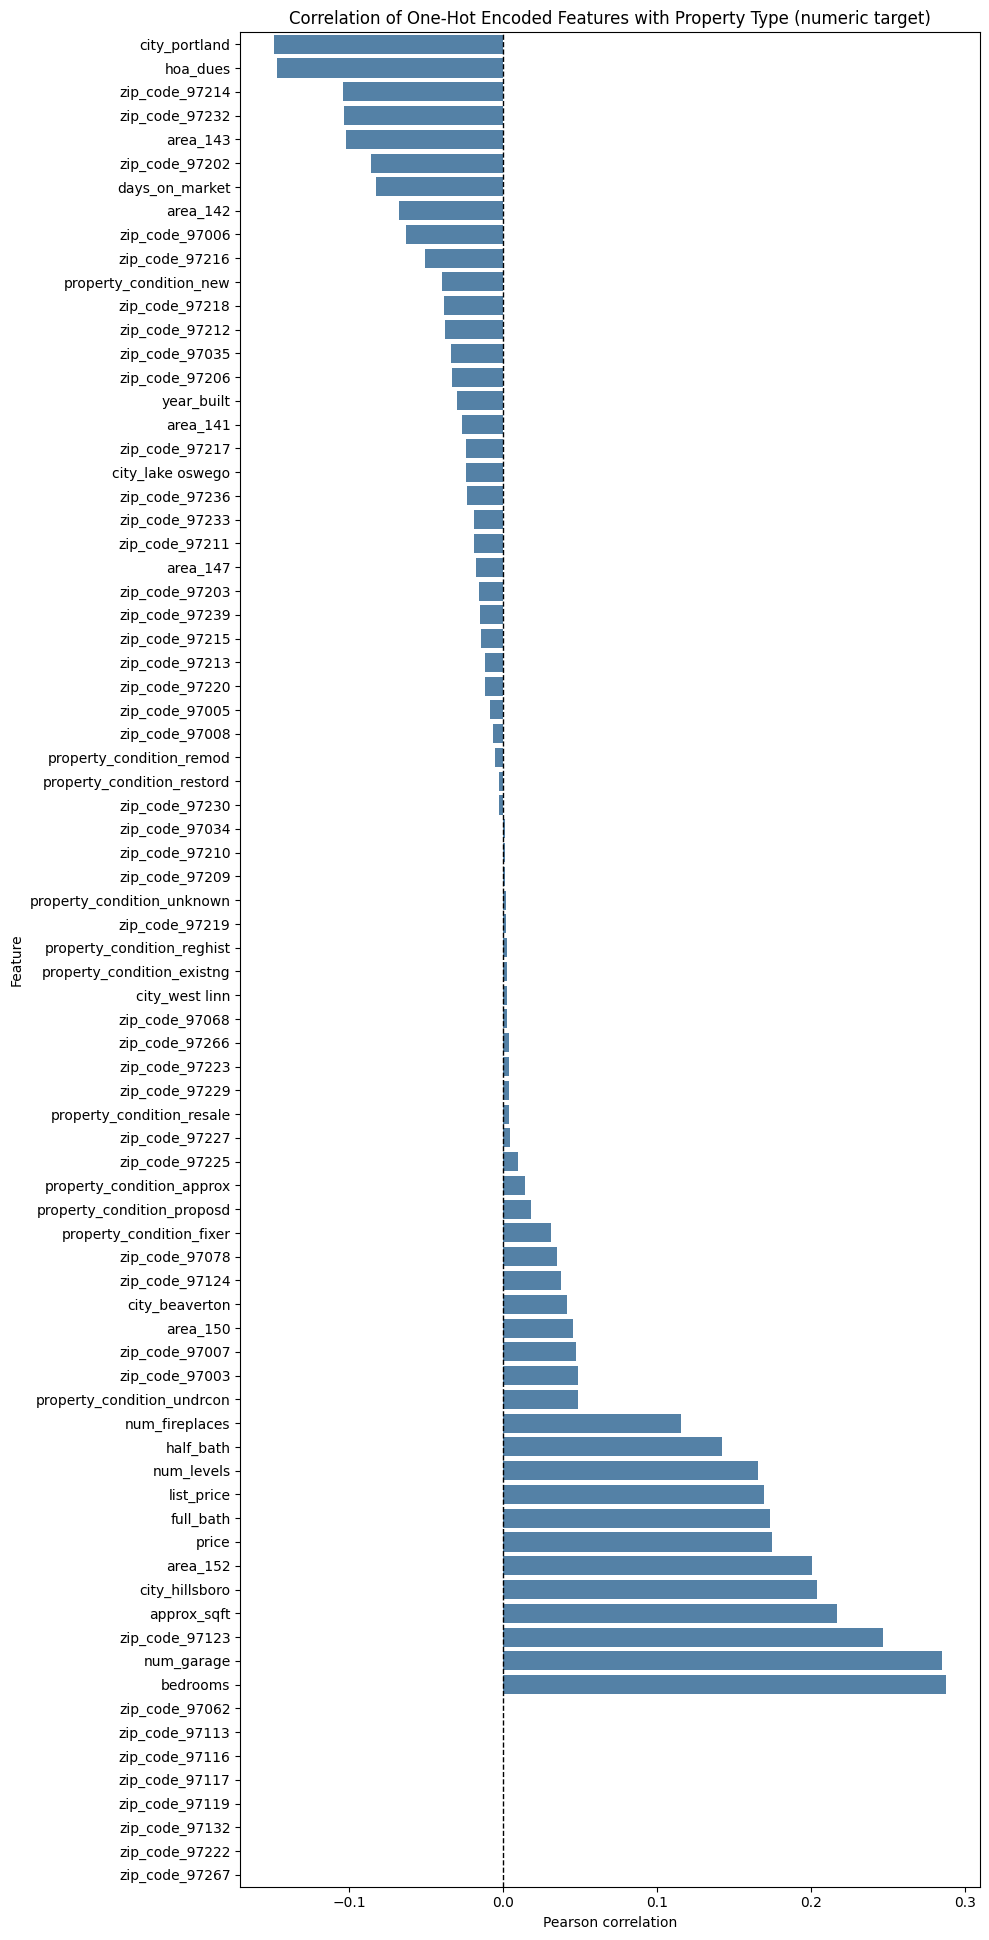

In [339]:
# One-hot encode categoricals (instead of factorize) and compute correlations to property_type

cols = [
    'property_type', 'property_condition', 'city', 'zip_code', 'area',
    'bedrooms', 'num_levels', 'approx_sqft', 'days_on_market', 'list_price',
    'price', 'year_built', 'hoa_dues', 'num_garage', 'num_fireplaces',
    'full_bath', 'half_bath'
]

# Work on a copy & keep only the columns of interest (if they all exist)
data_corr = data.copy()
existing_cols = [c for c in cols if c in data_corr.columns]
data_corr = data_corr[existing_cols].copy()

# Encode TARGET only (keep as numeric codes for correlation target)
data_corr['property_type'], _ = pd.factorize(data_corr['property_type'])

# One-hot encode the categorical FEATURES (not the target)
cat_feats = [c for c in ['property_condition', 'city', 'zip_code', 'area'] if c in data_corr.columns]
data_corr_ohe = pd.get_dummies(data_corr, columns=cat_feats, drop_first=False, dtype='uint8')

# Correlation of each (numeric / OHE) feature with property_type
corr_series = data_corr_ohe.corr(numeric_only=True)['property_type'].drop(labels=['property_type'])
corr_series = corr_series.sort_values()  # neg → pos

# Build plotting frame
plot_df = corr_series.reset_index()
plot_df.columns = ['feature', 'correlation']

# Plot bar chart
plt.figure(figsize=(10, max(6, 0.25 * len(plot_df))))
sns.barplot(
    data=plot_df,
    x='correlation',
    y='feature',
    color='steelblue',   # single color to avoid large legend
    edgecolor='none'
)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Correlation of One-Hot Encoded Features with Property Type (numeric target)')
plt.xlabel('Pearson correlation')
plt.ylabel('Feature')
plt.tight_layout()

# Save image
plt.savefig("correlation_to_property_type.png", dpi=200, bbox_inches='tight')
plt.show()

<div style="padding:14px; border-radius:8px;">

### 2.2.1 Correlation of One-hot Encoded Features Against `property_type` Interpretation

**Top signal (positive correlations → toward higher-encoded classes, typically `detachd`):**
- Size/structure features lead: **`bedrooms`**, **`num_garage`**, **`approx_sqft`**, **`num_levels`** show the largest positive correlations (~0.10–0.30), reinforcing that bigger homes with more levels/garage capacity skew **detached**.
- Location pockets also tilt detached: **`city_hillsboro`**, **`area_152`**, and ZIPs like **`zip_code_97123`** display notable positive associations.

**Top signal (negative correlations → toward lower-encoded classes, typically `condo`/`attachd`):**
- **`hoa_dues`** is the strongest negative feature (large magnitude), a classic proxy for **condo/attached** ownership costs.
- Urban/location indicators trend negative: **`city_portland`** and several inner ZIPs (e.g., **`zip_code_97214`**, **`zip_code_97232`**, **`zip_code_97202`**, **`zip_code_97006`**, **`zip_code_97216`**) align with **condo/attached** mix.
- Mild negatives for **`days_on_market`** and **`property_condition_new`** suggest these attributes are a bit more prevalent with lower-encoded types in this sample.

**Mid/low signals:**
- Bath counts and amenities—**`full_bath`**, **`half_bath`**, **`num_fireplaces`**—contribute moderately (mostly positive).
- Many **`property_condition*`** categories cluster near zero, indicating weaker univariate association.

**What this means for modeling:**
- Keep and prioritize **size/structure features**—**`bedrooms`**, **`num_garage`**, **`approx_sqft`**, **`num_levels`**—as primary discriminators.
- Leverage **location granularity** (city/ZIP/area): categorical encodings of **`city`**, **`zip_code`**, **`area`** capture distinct market mixes (urban ZIPs → `condo/attachd`, suburban ZIPs/areas → `detachd`).
- Use **`hoa_dues`** as a strong indicator for `condo`/`attachd`.
- Remember this is **univariate Pearson correlation** on a **numerically encoded target**; complement with **multivariate** methods (e.g., SHAP, one-vs-rest correlations) to capture interactions like `area × approx_sqft`.

</div>

## 2.3 `property_type` Distribution Per City

In [340]:
# Count property_type by city
counts = (
    data.groupby(["city", "property_type"])
        .size()
        .reset_index(name="count")
)

# Order cities by total volume
city_order = (
    counts.groupby("city")["count"].sum()
          .sort_values(ascending=True)
          .index.tolist()
)

# Grouped bar chart
fig = px.bar(
    counts,
    x="city",
    y="count",
    color="property_type",
    barmode="group",  # use "stack" if you prefer stacked bars
    text="count",
    category_orders={"city": city_order},
    title="Distribution of Property Types by City"
)

# Formatting
ymax = counts["count"].max()
fig.update_yaxes(range=[0, ymax * 1.15])  # space for labels
fig.update_traces(textposition="outside")
fig.update_layout(
    xaxis_title="City",
    yaxis_title="Count",
    legend_title="Property Type",
    xaxis_tickangle=-15
)

# Save image
fig.show()
fig.write_image("distribution_property_type_by_city.png", scale=2)

## 2.4 Violin Plots (Numerical Data)

These types plots are a great way to show sets of numerical distinguishing characteristics between classes.

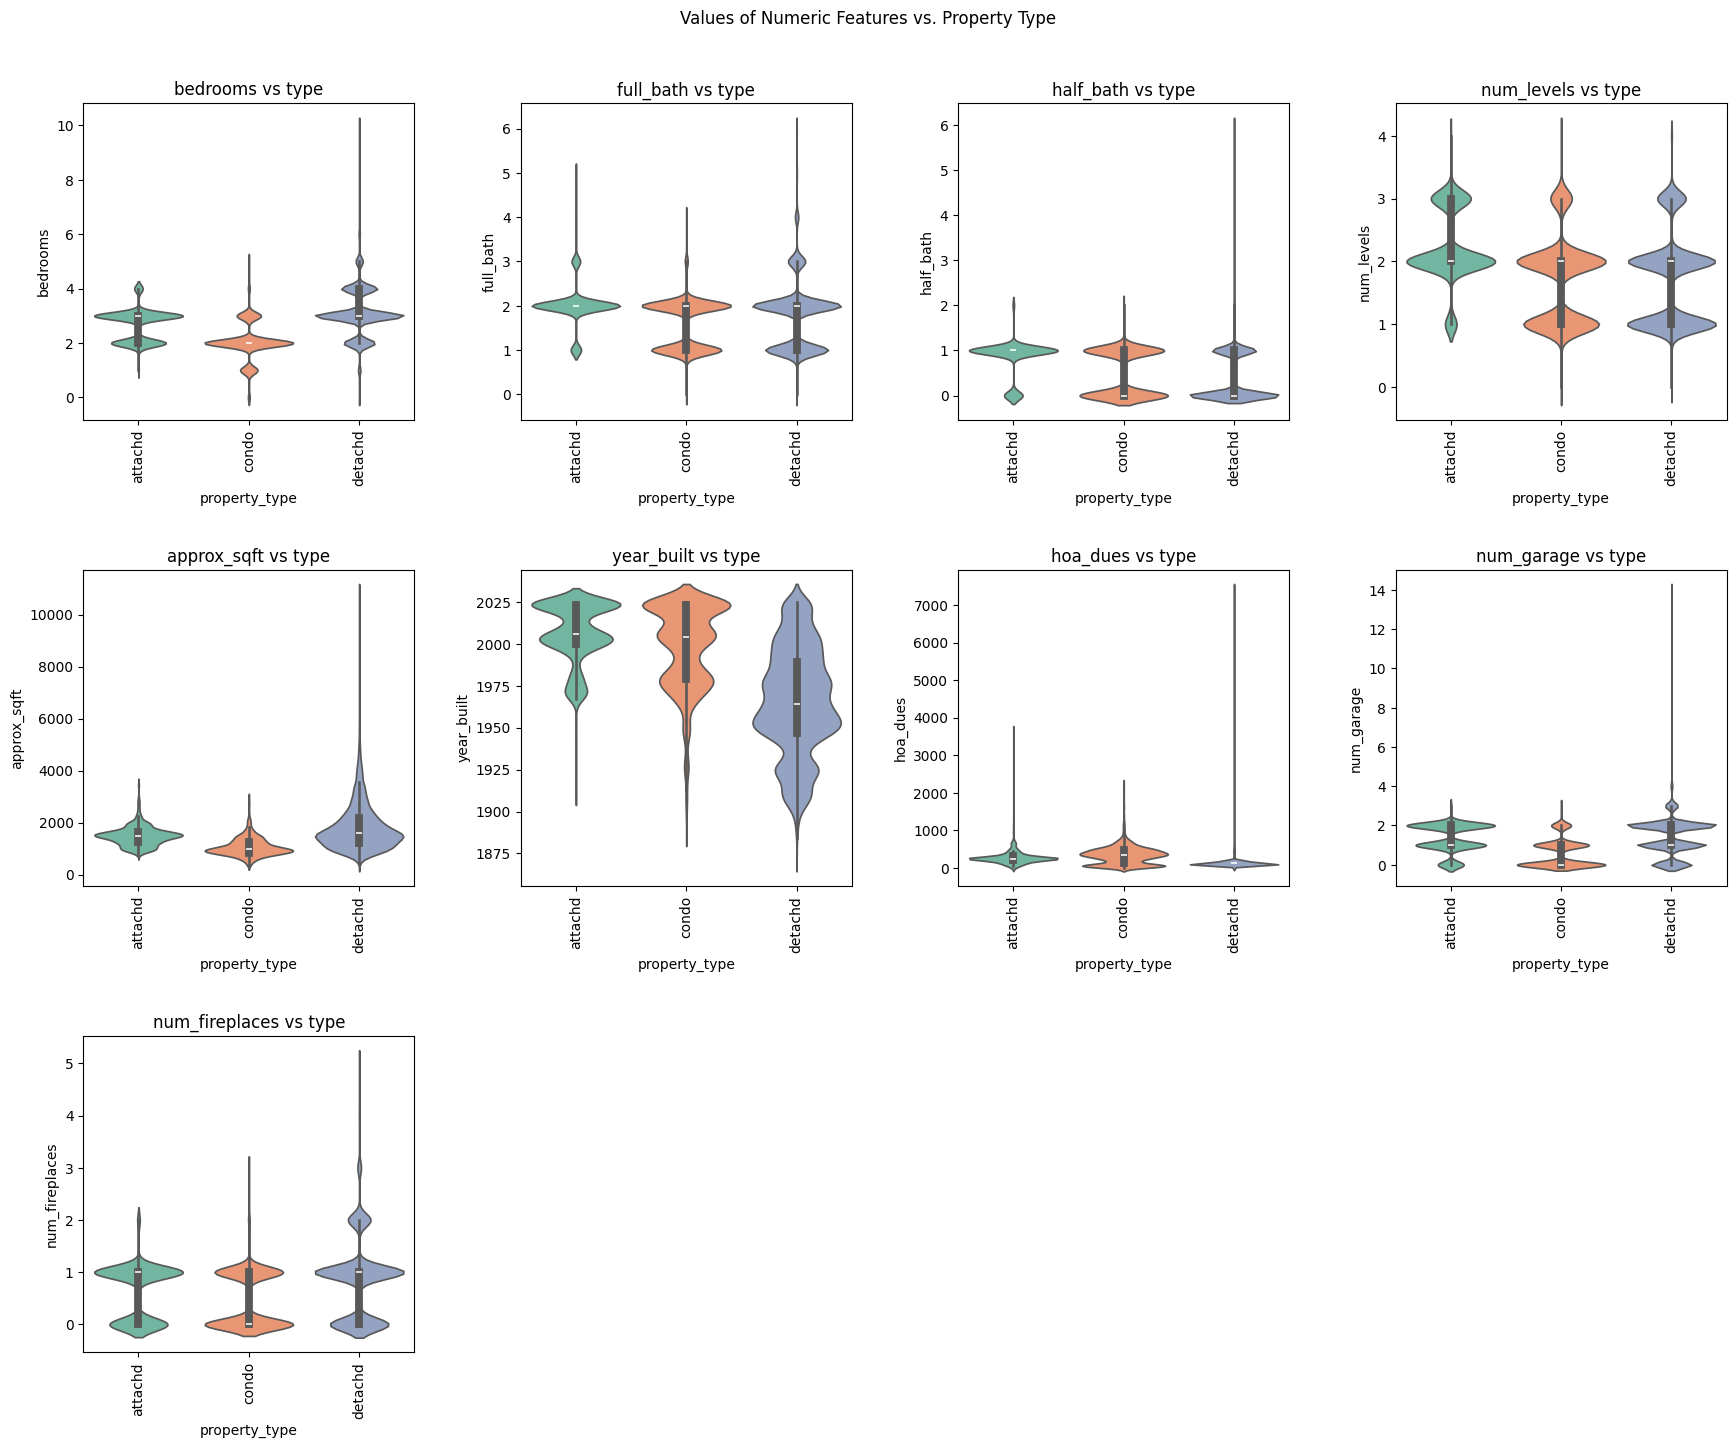

In [341]:
# Numerical
# Function to make desired plot for numerical variables
def plot_violin_grid(variables, df):
    # Make a 3x4 grid of subplots
    fig, axes = plt.subplots(3, 4, figsize=(18, 15))
    axes = axes.flatten()  # turn into a 1D list for easy looping
    
    for i, var in enumerate(variables):
        sns.violinplot(x='property_type', y=var, data=df, hue='property_type', palette='Set2', ax=axes[i])
        axes[i].set_title(f"{var} vs type")
        axes[i].tick_params(axis='x', rotation=90)
    
    # Hide any unused plots if variables < 12
    for j in range(len(variables), 12):
        fig.delaxes(axes[j])
    
    fig.suptitle("Values of Numeric Features vs. Property Type")
    plt.tight_layout(pad=3.0)
    plt.show()

# Choose numerical variables to plot
num_vars = ['bedrooms', 'full_bath', 'half_bath',
                'num_levels', 'approx_sqft', 'year_built',
                'hoa_dues', 'num_garage', 
                'num_fireplaces']

# Violin plots seem to show data the best
plot_violin_grid(num_vars, data)

## 2.5 Bar Plots (Categorical Data)

For the remaining (categorical) data, bar plots of their counts are more appropriate.

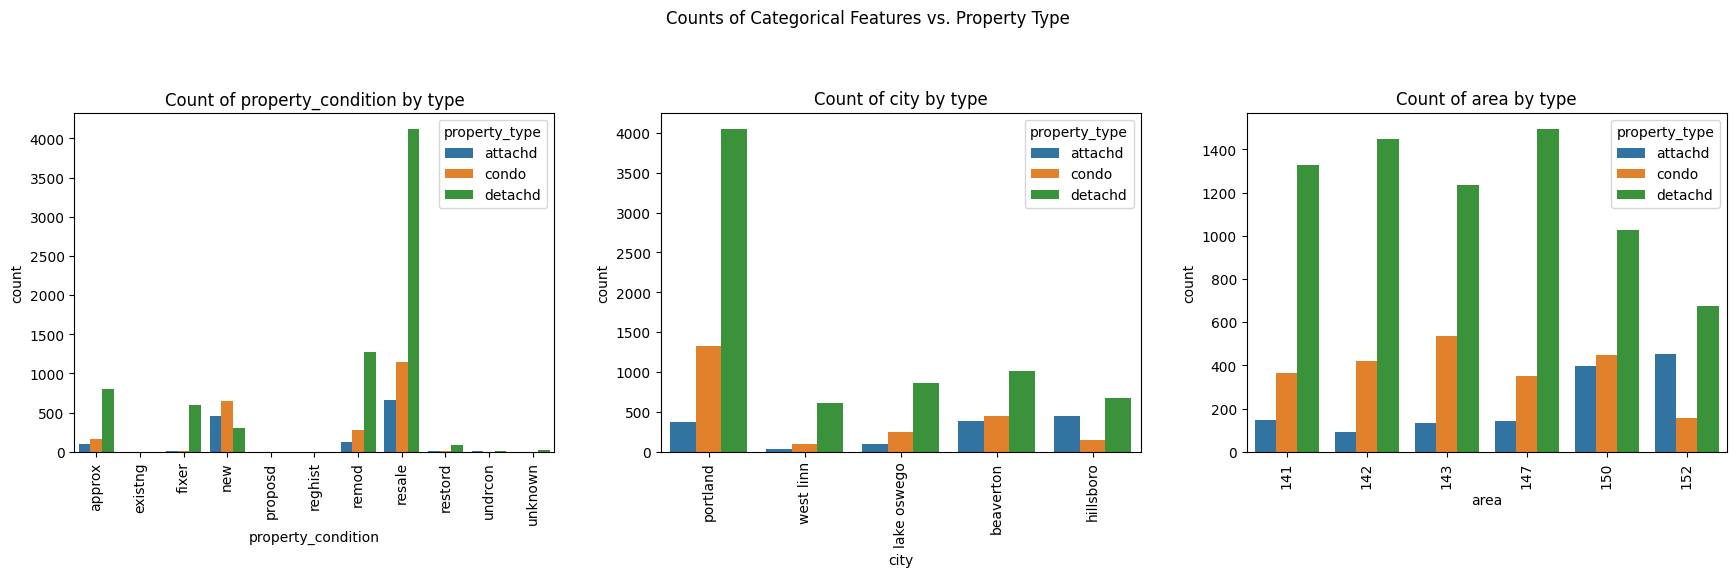

In [342]:
# Catergorical
# Function to make desired plot for categorical variables
def plot_bar_grid(variables, df):
    # Make a 3x4 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()  # turn into a 1D list for easy looping
    
    for i, var in enumerate(variables):
        sns.countplot(x=var, data=df, hue='property_type', ax=axes[i])
        axes[i].set_title(f"Count of {var} by type")
        axes[i].tick_params(axis='x', rotation=90)
    
    # Hide any unused plots if variables < 6
    for j in range(len(variables), 6):
        fig.delaxes(axes[j])
    
    fig.suptitle("Counts of Categorical Features vs. Property Type")
    plt.tight_layout(pad=3.0)
    plt.show()

# Choose categorical variables to plot
cat_vars = ['property_condition', 'city', 'area'] # Excluding zip, bar plot will not be informative

# Bar plots
plot_bar_grid(cat_vars, data)

<div style="padding:14px; border-radius:8px;">

### 2.3.1 Distribution of Property Types by City Interpretation 

- **Portland overwhelmingly dominates** the dataset, with the highest counts in all categories—especially **`detachd`** (≈4,046) and a large number of **`condo`** (≈1,321).  
- Every city is **detached-heavy**: **`detachd`** is the largest bar in **Beaverton** (≈1,009), **Hillsboro** (≈675), **Lake Oswego** (≈864), and **West Linn** (≈613).  
- **`condo`** presence is strongest in **Portland**, with secondary clusters in **Beaverton** and **Lake Oswego**.  
- **`attachd`** (townhomes) appear in meaningful volumes in **Hillsboro** (≈455) and **Beaverton** (≈391), but remain well below **`detachd`**.  

**Implications for modeling:**  
- **City is an informative categorical feature** that captures location-driven mix (urban → more **`condo`**, suburban → more **`detachd`**).  
- The **class imbalance** (detached dominance) varies by city; use **stratified/group-aware CV** by city/area and consider **class weighting** to avoid overpredicting `detachd` in lower-volume cities.

</div> 


<div style="padding:15px; border-radius:8px;">

### Summary Interpretation of the Visualizations

**1) Geography is highly predictive**
- The **Area × Property Type** heatmap shows **`detachd`** dominating most areas, especially **142** and **147**, while **`condo`** clusters in select areas (e.g., **143**, **150**).  
- **City-level** bars confirm **Portland** carries the largest volume—primarily **`detachd`**—with **Beaverton**, **Lake Oswego**, and **Hillsboro** contributing smaller but meaningful pockets.  
- **Implication:** Treat **`area`**, **`city`**, and **`zip_code`** as **categorical** features; they encode location priors that help the model anticipate property mix.

**2) Structure & size drive class separation**
- Correlation bars highlight **`bedrooms`**, **`num_garage`**, **`approx_sqft`**, and **`num_levels`** as the strongest positive signals (tilting toward **`detachd`**).  
- **`hoa_dues`** is strongly negative (aligning with **`condo`/`attachd`**), while **`num_fireplaces`**, **`half_bath`**, **`full_bath`** add secondary structure cues.  
- **Implication:** These variables should be retained and considered for **interactions** (e.g., `area × approx_sqft`, `city × num_levels`).

**3) Class imbalance shapes learning**
- Overall distribution shows **`detachd`** far outnumber **`condo`** and **`attachd`**; rarer classes (e.g., **`res-mfg`**, **`flthome`**, **`plncomm`**) are extremely scarce.  
- **Implication:** Use **SMOTE/SMOTENC** or **class-weighted losses** and **per-class thresholds** to stabilize minority-class recall; report Macro-F1 alongside ROC-AUC.

**4) Encoding choices matter**
- Location fields (**`city`**, **`zip_code`**, **`area`**) benefit from **one-hot / target / frequency encoding** (not numeric ordinals).  
- Converting **`zip_code`** to categorical avoids spurious numeric distances and improves minority detection in several runs.

**5) Validation & robustness**
- Because some areas/cities dominate, prefer **group-aware CV** (e.g., `GroupKFold` by **`zip_code`** or **`area`**) to prevent geographic leakage and ensure the model generalizes to new regions.

---

### Bottom Line
- **What separates types:** structural/size features—**`bedrooms`**, **`num_garage`**, **`approx_sqft`**, **`num_levels`**—plus location (**`city`**, **`area`**, **`zip_code`**).  
- **Where they appear:** **`detachd`** dominates many areas and cities; **`condo`** is concentrated in specific geographies; **`attachd`** is generally sparse.  
- **How to model:** encode **location** categorically, keep key **structure** features, add **feature interactions**, rebalance classes, and validate with **group-aware CV**.

</div>


# 3. DATA PREPROCESSING FOR MACHINE LEARNING

## 3.1 Feature engineering

We will introduce 2 new feature-engineered columns to a copy of the original data set and call it `data_fe`. These features are designed to capture important relationships between bathroom-to-bedroom balance and location patterns. By creating these derived features, we provide the model with richer, more meaningful inputs that can hopefully improve classification performance and help separate property types more effectively.


In [343]:
# Copy the data for the feature engineering data
data_fe = data.copy()

##### Bathroom Features

- **`bath_to_bed_ratio`** = `total_bathrooms / bedrooms`  
  Captures the ratio of bathrooms to bedrooms — different property types (condos vs. detached homes) may follow distinct patterns.

In [344]:
# Create total_bathrooms 
data_fe['total_bathrooms'] = data_fe['full_bath'] + 0.5 * data_fe['half_bath']

# Create bath_to_bed_ratio 
# Avoid division by zero or NaN by replacing 0 bedrooms with NaN first
data_fe['bath_to_bed_ratio'] = np.where(
    data_fe['bedrooms'] > 0,
    data_fe['total_bathrooms'] / data_fe['bedrooms'],
    0  # set to 0 if bedrooms is 0 or NaN
)

# Round ratio for readability
data_fe['bath_to_bed_ratio'] = data_fe['bath_to_bed_ratio'].round(2)

# Drop total_bathrooms column
data_fe = data_fe.drop(columns=['total_bathrooms'])

# Quick check 
print(data_fe[['full_bath', 'half_bath', 'bedrooms', 'bath_to_bed_ratio']].head(10))

   full_bath  half_bath  bedrooms  bath_to_bed_ratio
0          1          1         2               0.75
1          1          0         2               0.50
2          1          0         2               0.50
3          1          0         2               0.50
4          1          0         1               1.00
5          1          0         1               1.00
6          1          0         1               1.00
7          1          0         1               1.00
8          1          0         1               1.00
9          1          0         2               0.50


##### Age of Property
- **`property_age`** = `current_year` / `year_built`
Calculates the age of the property

In [345]:
# Calculates the age of the property and creates a new column
data_fe['property_age'] = 2025 - data_fe['year_built']

# Repeat for the originial dataset as well
data['property_age'] = 2025 - data['year_built']

# Repeat for the original dataset with updated hoa_due as well
data_2['property_age'] = 2025 - data_2['year_built']

##### Location-Based Grouping

- **`zip_code_group`** = Group `zip_code` into larger regions (e.g., urban, suburban, rural) if patterns suggest clustering.

In [346]:
# Ensure zip_code is numeric and then convert to string
data_fe['zip_code'] = pd.to_numeric(data_fe['zip_code'], errors='coerce')

# Extract the first 3 digits as a prefix (as string)
data_fe['zip_prefix'] = data_fe['zip_code'].dropna().astype(int).astype(str).str[:3]

# Classify by prefix: 972 = Portland, 970 = West/South suburbs, 971 = Hillsboro / Washington County / Outer suburbs
def classify_zip_prefix(prefix):
    if prefix == '972':
        return 'urban_portland'  # Portland urban core
    elif prefix == '970':
        return 'suburban_west_south'  # West/South suburbs
    elif prefix == '971':
        return 'suburban_northwest'    # Hillsboro / Washington County / Outer suburbs
    else:
        return 'other'

data_fe['zip_prefix_group'] = data_fe['zip_prefix'].apply(classify_zip_prefix)

# Drop zip_prefix column
data_fe = data_fe.drop(columns=['zip_prefix'])

# Quick check
print(data_fe[['zip_code','zip_prefix_group']].head())
print("\nCounts per prefix group:")
print(data_fe['zip_prefix_group'].value_counts(dropna=False))

   zip_code zip_prefix_group
0     97217   urban_portland
1     97217   urban_portland
2     97217   urban_portland
3     97203   urban_portland
4     97203   urban_portland

Counts per prefix group:
zip_prefix_group
urban_portland         5733
suburban_west_south    3935
suburban_northwest     1182
Name: count, dtype: int64


Convert **`zip_code`** column back into a category 

In [347]:
# Store ZIPs as zero-padded strings, then make categorical
zip_num = pd.to_numeric(data_fe['zip_code'], errors='coerce').round().astype('Int64')
data_fe['zip_code'] = zip_num.astype('string').str.zfill(5).astype('category')

# Quick check
print(data_fe['zip_code'].dtype)           # category
print(data_fe['zip_code'].cat.categories[:5])

category
Index(['97003', '97005', '97006', '97007', '97008'], dtype='string')


In [348]:
data_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   property_type       10850 non-null  category
 1   property_condition  10850 non-null  category
 2   city                10850 non-null  object  
 3   zip_code            10850 non-null  category
 4   area                10850 non-null  category
 5   bedrooms            10850 non-null  Int64   
 6   num_levels          10850 non-null  Int64   
 7   approx_sqft         10850 non-null  Int64   
 8   days_on_market      10850 non-null  Int64   
 9   list_price          10846 non-null  Int64   
 10  price               10850 non-null  Int64   
 11  year_built          10850 non-null  Int64   
 12  hoa_dues            10850 non-null  float64 
 13  num_garage          10850 non-null  Int64   
 14  num_fireplaces      10850 non-null  Int64   
 15  full_bath           10850 non-null  

In [349]:
# Save feature-engineered data to a csv file
save_csv(data_fe, "data_fe_cleaned")

Saved data_fe_cleaned: C:\Users\palon\Desktop\GitHub Repository\homeservices_real_estate_externship_sep_2025\exports\data_fe_cleaned_2025-10-20_1106.csv  (10,850 rows × 20 cols)


<div style="padding:14px; border-radius:8px;">

### 3.1.1 Summary of Feature-Engineered Columns

| **Feature Name** | **Type** | **How It Was Created** | **Purpose / Why It Helps** |
|------------------|---------|-----------------------|---------------------------|
| `bath_to_bed_ratio` | Bathroom Feature | Calculated as `total_bathrooms / bedrooms`. | Captures balance of bathrooms to bedrooms, which often distinguishes property types (e.g., condos vs. single-family homes). |
| `zip_code_group` | Location-Based Grouping | Mapped `zip_code` values into larger regional clusters such as *urban_portland*, *suburban_west_south*, *suburban_northwest*, and *other*. | Provides models with meaningful, higher-level geographic segmentation to capture location-driven price and type patterns. |
| `property_age` | Age of Property | Subtracted the `year_built`  from the current year | Provides a meaningful relationship between the condition of a property and its market or physical value. |

</div>

## 3.2 Categorical Variable Encoding

To prepare the datasets for modeling, we have to convert all of the categorical values into numerical values. We will use one hot encoding on the features and label encoding on the target variable.

In [350]:
# View the feature-engineered dataset, the original dataset and the orignial updated hoa dataset before encoding
print(data_fe.info())  
print()
print(data.info())
print()
print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   property_type       10850 non-null  category
 1   property_condition  10850 non-null  category
 2   city                10850 non-null  object  
 3   zip_code            10850 non-null  category
 4   area                10850 non-null  category
 5   bedrooms            10850 non-null  Int64   
 6   num_levels          10850 non-null  Int64   
 7   approx_sqft         10850 non-null  Int64   
 8   days_on_market      10850 non-null  Int64   
 9   list_price          10846 non-null  Int64   
 10  price               10850 non-null  Int64   
 11  year_built          10850 non-null  Int64   
 12  hoa_dues            10850 non-null  float64 
 13  num_garage          10850 non-null  Int64   
 14  num_fireplaces      10850 non-null  Int64   
 15  full_bath           10850 non-null  

### Split Dataset (Change Order to Split-Encode)

In [351]:
# Define X (features) and y (target)
X_data_fe = data_fe.drop(columns=['property_type'])
y_data_fe = data_fe['property_type']

# Train / Temp Split (70% / 30%)
X_train_fe, X_temp_fe, y_train_fe, y_temp_fe = train_test_split(
    X_data_fe, y_data_fe,
    test_size=0.30, random_state=42, stratify=y_data_fe
)

# Validation / Test Split (15% / 15%)
X_val_fe, X_test_fe, y_val_fe, y_test_fe = train_test_split(
    X_temp_fe, y_temp_fe,
    test_size=0.50, random_state=42, stratify=y_temp_fe
)

# Check Shapes (X & y for each split)
print("\n[data_fe_encoded] split shapes")
print(f"X_train_fe: {X_train_fe.shape} | y_train_fe: {y_train_fe.shape}")
print(f"X_val_fe:   {X_val_fe.shape}   | y_val_fe:   {y_val_fe.shape}")
print(f"X_test_fe:  {X_test_fe.shape}  | y_test_fe:  {y_test_fe.shape}")


[data_fe_encoded] split shapes
X_train_fe: (7595, 19) | y_train_fe: (7595,)
X_val_fe:   (1627, 19)   | y_val_fe:   (1627,)
X_test_fe:  (1628, 19)  | y_test_fe:  (1628,)


### 3.2.1 Perform encoding and scaling on the feature-engineered dataset (data_fe)

In [352]:
data_fe

,property_type,property_condition,city,zip_code,area,bedrooms,num_levels,approx_sqft,days_on_market,list_price,price,year_built,hoa_dues,num_garage,num_fireplaces,full_bath,half_bath,bath_to_bed_ratio,property_age,zip_prefix_group
0,condo,resale,portland,97217,141,2,2,1088,11,179777,160000,1972,560.00,0,0,1,1,0.75,53,urban_portland
1,condo,new,portland,97217,141,2,1,764,145,166000,166000,2022,253.00,0,0,1,0,0.50,3,urban_portland
2,condo,new,portland,97217,141,2,1,764,84,166000,166000,2021,233.00,0,0,1,0,0.50,4,urban_portland
3,detachd,resale,portland,97203,141,2,1,944,28,188431,188431,2007,112.00,1,0,1,0,0.50,18,urban_portland
4,condo,resale,portland,97203,141,1,1,591,2,189000,189000,1963,263.00,1,0,1,0,1.00,62,urban_portland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10845,detachd,resale,hillsboro,97123,152,3,2,2225,10,560000,560000,2010,75.00,2,1,2,1,0.83,15,suburban_northwest
10846,detachd,remod,hillsboro,97124,152,3,2,1643,40,574900,560000,2000,263.00,2,1,2,1,0.83,25,suburban_northwest
10847,attachd,resale,hillsboro,97006,152,3,3,1902,5,525000,560000,2014,145.00,1,1,3,0,1.00,11,suburban_west_south
10848,detachd,resale,hillsboro,97124,152,2,1,1479,8,585000,560000,1998,581.00,2,1,2,0,1.00,27,suburban_northwest


In [353]:
print(data_fe.columns)
print(X_train_fe.columns)
print(y_train_fe)

Index(['property_type', 'property_condition', 'city', 'zip_code', 'area',
       'bedrooms', 'num_levels', 'approx_sqft', 'days_on_market', 'list_price',
       'price', 'year_built', 'hoa_dues', 'num_garage', 'num_fireplaces',
       'full_bath', 'half_bath', 'bath_to_bed_ratio', 'property_age',
       'zip_prefix_group'],
      dtype='object')
Index(['property_condition', 'city', 'zip_code', 'area', 'bedrooms',
       'num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price',
       'year_built', 'hoa_dues', 'num_garage', 'num_fireplaces', 'full_bath',
       'half_bath', 'bath_to_bed_ratio', 'property_age', 'zip_prefix_group'],
      dtype='object')
606      attachd
7393     detachd
4329       condo
10270    detachd
5469     detachd
          ...   
670      detachd
3588     detachd
8457     detachd
1817     detachd
381      detachd
Name: property_type, Length: 7595, dtype: category
Categories (3, object): ['attachd', 'condo', 'detachd']


In [354]:
# List of categorical columns to encode in data_fe (feature-engineered dataset)
categorical_cols = [
    'property_condition', 
    'city', 
    'zip_code',
    'area',
    'year_built',
    'zip_prefix_group'
]

# Other cols are numeric cols
numeric_cols = [col for col in X_train_fe.columns if col not in categorical_cols]

# One-hot encode X_train then apply to validation and test sets
# One-hot encode TRAIN data
X_train_fe_encoded = pd.get_dummies(
    X_train_fe,
    columns=categorical_cols,
    prefix=categorical_cols,
    drop_first=False,
    dtype='uint8'
)

# Get list of all columns created from training
train_columns = X_train_fe_encoded.columns

# Apply same encoding to VAL and TEST
# (Ensures same dummy columns, even if some categories are missing)
X_val_fe_encoded = pd.get_dummies(
    X_val_fe,
    columns=categorical_cols,
    prefix=categorical_cols,
    drop_first=False,
    dtype='uint8'
).reindex(columns=train_columns, fill_value=0)

X_test_fe_encoded = pd.get_dummies(
    X_test_fe,
    columns=categorical_cols,
    prefix=categorical_cols,
    drop_first=False,
    dtype='uint8'
).reindex(columns=train_columns, fill_value=0)

# Scale only numeric columns
scaler = StandardScaler()
X_train_fe_encoded[numeric_cols] = scaler.fit_transform(X_train_fe_encoded[numeric_cols])
X_val_fe_encoded[numeric_cols] = scaler.transform(X_val_fe_encoded[numeric_cols])
X_test_fe_encoded[numeric_cols] = scaler.transform(X_test_fe_encoded[numeric_cols])

# Quick check
print("X_train shape after encoding:", X_train_fe_encoded.shape)
print("X_val shape after encoding:", X_val_fe_encoded.shape)
print("X_test shape after encoding:", X_test_fe_encoded.shape)
print("Sample columns:", X_train_fe_encoded.columns[:15].tolist())
print("Sample columns:", X_val_fe_encoded.columns[:15].tolist())
print("Sample columns:", X_test_fe_encoded.columns[:15].tolist())

X_train shape after encoding: (7595, 209)
X_val shape after encoding: (1627, 209)
X_test shape after encoding: (1628, 209)
Sample columns: ['bedrooms', 'num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price', 'hoa_dues', 'num_garage', 'num_fireplaces', 'full_bath', 'half_bath', 'bath_to_bed_ratio', 'property_age', 'property_condition_approx', 'property_condition_existng']
Sample columns: ['bedrooms', 'num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price', 'hoa_dues', 'num_garage', 'num_fireplaces', 'full_bath', 'half_bath', 'bath_to_bed_ratio', 'property_age', 'property_condition_approx', 'property_condition_existng']
Sample columns: ['bedrooms', 'num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price', 'hoa_dues', 'num_garage', 'num_fireplaces', 'full_bath', 'half_bath', 'bath_to_bed_ratio', 'property_age', 'property_condition_approx', 'property_condition_existng']


When training the LightGBM model, the data_fe_encoded was found to have duplicate column names. So we will keep the first instance and drop the second.

In [355]:
# Ensure it's a DataFrame
if not isinstance(X_train_fe_encoded, pd.DataFrame):
    raise TypeError("data_fe_encoded must be a pandas DataFrame.")

# Quick yes/no check
has_dups = X_train_fe_encoded.columns.duplicated().any()
print(f"Duplicate column names present? {has_dups}")

# List duplicate names (unique)
dup_names = X_train_fe_encoded.columns[X_train_fe_encoded.columns.duplicated()].unique()
print("Duplicate column names:", list(dup_names) if len(dup_names) else "None")

# Counts per name (only those with count > 1)
vc = pd.Series(X_train_fe_encoded.columns).value_counts()
dup_counts = vc[vc > 1]
if not dup_counts.empty:
    print("\nCounts for duplicate names:")
    print(dup_counts)

Duplicate column names present? False
Duplicate column names: None


In [356]:
"""
# Keep the first occurrence, drop subsequent duplicates
if has_dups:
    dup_mask = pd.Series(data_fe_encoded.columns).duplicated(keep="first").to_numpy()  # True for 2nd+ occurrences
    dropped = list(data_fe_encoded.columns[dup_mask])
    data_fe_encoded = data_fe_encoded.loc[:, ~dup_mask].copy()
    print(f"\nDropped {len(dropped)} duplicate column(s) (kept first occurrence):")
    print(dropped)
    print("New shape:", data_fe_encoded.shape)
else:
    print("\nNo duplicate columns to drop.")
"""

'\n# Keep the first occurrence, drop subsequent duplicates\nif has_dups:\n    dup_mask = pd.Series(data_fe_encoded.columns).duplicated(keep="first").to_numpy()  # True for 2nd+ occurrences\n    dropped = list(data_fe_encoded.columns[dup_mask])\n    data_fe_encoded = data_fe_encoded.loc[:, ~dup_mask].copy()\n    print(f"\nDropped {len(dropped)} duplicate column(s) (kept first occurrence):")\n    print(dropped)\n    print("New shape:", data_fe_encoded.shape)\nelse:\n    print("\nNo duplicate columns to drop.")\n'

### 3.2.2 Perform encoding on the original dataset (data

In [357]:
# List of categorical columns to encode
categorical_cols = ['property_condition', 'city', 'zip_code', 'area', 'year_built']

# One-hot encode all specified columns
data_encoded = pd.get_dummies(
    data,
    columns=categorical_cols,
    prefix=categorical_cols,   # add prefix to avoid name collisions
    drop_first=False,          # keep all categories
    dtype='uint8'              # store as integers for efficiency
)

# Quick check
print("Shape after encoding:", data_encoded.shape)
print("Sample encoded columns:", data_encoded.columns[:15].tolist())

Shape after encoding: (10850, 219)
Sample encoded columns: ['property_type', 'bedrooms', 'num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price', 'hoa_dues', 'num_garage', 'num_fireplaces', 'full_bath', 'half_bath', 'property_age', 'property_condition_approx', 'property_condition_existng']


In [358]:
# List of categorical columns to encode
categorical_cols = ['property_condition', 'city', 'zip_code', 'area', 'year_built']

# One-hot encode all specified columns
data_enc_2 = pd.get_dummies(
    data_2,
    columns=categorical_cols,
    prefix=categorical_cols,   # add prefix to avoid name collisions
    drop_first=False,          # keep all categories
    dtype='uint8'              # store as integers for efficiency
)

# Quick check
print("Shape after encoding:", data_enc_2.shape)
print("Sample encoded columns:", data_enc_2.columns[:15].tolist())

Shape after encoding: (10850, 219)
Sample encoded columns: ['property_type', 'bedrooms', 'num_levels', 'approx_sqft', 'days_on_market', 'list_price', 'price', 'hoa_dues', 'num_garage', 'num_fireplaces', 'full_bath', 'half_bath', 'property_age', 'property_condition_approx', 'property_condition_existng']


### 3.2.3 Perform encoding on the target ('property_type') of both datasets

In [359]:
def norm(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower()

#  Build a unified label list from ALL splits/datasets (as text)
all_labels = pd.concat([
    norm(data_encoded['property_type']),
    norm(y_train_fe), # expanded y into train, val, test, as series instead of df
    norm(y_val_fe),
    norm(y_test_fe),
    norm(data_enc_2['property_type'])
], ignore_index=True)

#  Fit ONE encoder on the union (strings)
le = LabelEncoder()
le.fit(all_labels)

#  Transform each dataset consistently (convert to text first!)
data_encoded['property_type']   = le.transform(norm(data_encoded['property_type']))
y_train_fe = le.transform(norm(y_train_fe))  # expanded y into train, val, test, as series instead of df
y_val_fe = le.transform(norm(y_val_fe))
y_test_fe = le.transform(norm(y_test_fe))
data_enc_2['property_type']      = le.transform(norm(data_enc_2['property_type']))

# Assign new names for clarity
y_train_fe_encoded = y_train_fe
y_val_fe_encoded = y_val_fe
y_test_fe_encoded = y_test_fe

print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

print("Shape after encoding:", y_train_fe_encoded.shape)
print("Shape after encoding:", y_val_fe_encoded.shape)
print("Shape after encoding:", y_test_fe_encoded.shape)

Class mapping: {'attachd': np.int64(0), 'condo': np.int64(1), 'detachd': np.int64(2)}
Shape after encoding: (7595,)
Shape after encoding: (1627,)
Shape after encoding: (1628,)


## 3.3 Split the Dataset

Now we will train/validation/test split (70/15/15) on both of the datasets.

#### 3.3.1 Feature-engineered Dataset Split (data_fe)

*This section was moved before encoding and scaling*

In [360]:
"""
# Define X (features) and y (target)
X_data_fe_encoded = data_fe_encoded.drop(columns=['property_type'])
y_data_fe_encoded = data_fe_encoded['property_type']

# Train / Temp Split (70% / 30%)
X_train_fe, X_temp_fe, y_train_fe, y_temp_fe = train_test_split(
    X_data_fe_encoded, y_data_fe_encoded,
    test_size=0.30, random_state=42, stratify=y_data_fe_encoded
)

# Validation / Test Split (15% / 15%)
X_val_fe, X_test_fe, y_val_fe, y_test_fe = train_test_split(
    X_temp_fe, y_temp_fe,
    test_size=0.50, random_state=42, stratify=y_temp_fe
)

# Check Shapes (X & y for each split)
print("\n[data_fe_encoded] split shapes")
print(f"X_train_fe: {X_train_fe.shape} | y_train_fe: {y_train_fe.shape}")
print(f"X_val_fe:   {X_val_fe.shape}   | y_val_fe:   {y_val_fe.shape}")
print(f"X_test_fe:  {X_test_fe.shape}  | y_test_fe:  {y_test_fe.shape}")
"""

'\n# Define X (features) and y (target)\nX_data_fe_encoded = data_fe_encoded.drop(columns=[\'property_type\'])\ny_data_fe_encoded = data_fe_encoded[\'property_type\']\n\n# Train / Temp Split (70% / 30%)\nX_train_fe, X_temp_fe, y_train_fe, y_temp_fe = train_test_split(\n    X_data_fe_encoded, y_data_fe_encoded,\n    test_size=0.30, random_state=42, stratify=y_data_fe_encoded\n)\n\n# Validation / Test Split (15% / 15%)\nX_val_fe, X_test_fe, y_val_fe, y_test_fe = train_test_split(\n    X_temp_fe, y_temp_fe,\n    test_size=0.50, random_state=42, stratify=y_temp_fe\n)\n\n# Check Shapes (X & y for each split)\nprint("\n[data_fe_encoded] split shapes")\nprint(f"X_train_fe: {X_train_fe.shape} | y_train_fe: {y_train_fe.shape}")\nprint(f"X_val_fe:   {X_val_fe.shape}   | y_val_fe:   {y_val_fe.shape}")\nprint(f"X_test_fe:  {X_test_fe.shape}  | y_test_fe:  {y_test_fe.shape}")\n'

<div style="padding:14px; border-radius:8px;">
    
#### 3.3.1.1 Feature-Engineered Dataset Splits (After Encoding)

| **Dataset Split** | **Variable** | **Shape** | **Description** |
|-----------------|-------------|-----------|-----------------|
| **Training**    | `X_train_fe` | `(7595, 214)` | Feature-engineered training set after encoding |
|                 | `y_train_fe` | `(7595,)` | Target labels for the resampled training set |
| **Validation**  | `X_val_fe`  | `(1627, 214)` | Feature-engineered validation features |
|                 | `y_val_fe`  | `(1627,)` | Validation target labels |
| **Test**        | `X_test_fe` | `(1638, 214)` | Feature-engineered test features |
|                 | `y_test_fe` | `(1628,)` | True labels used for final model evaluation |

</div>

### 3.3.2 Original Dataset Split (data)

In [361]:
# Define X (features) and y (target)
# Replace 'property_type' with your actual target column name if different
X_data_encoded = data_encoded.drop(columns=['property_type'])
y_data_encoded = data_encoded['property_type']

# Train / Temp Split (70% / 30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data_encoded, y_data_encoded, test_size=0.30, random_state=42, stratify=y_data_encoded
)

# Validation / Test Split (15% / 15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Check Shapes (X & y for each split)
print("\n[data_encoded] split shapes")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}   | y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")



[data_encoded] split shapes
X_train: (7595, 218) | y_train: (7595,)
X_val:   (1627, 218)   | y_val:   (1627,)
X_test:  (1628, 218)  | y_test:  (1628,)


### 3.3.2 Original Dataset Split (with HOA change)

In [362]:
# Define X (features) and y (target)
# Replace 'property_type' with your actual target column name if different
X_data_enc_2 = data_enc_2.drop(columns=['property_type'])
y_data_enc_2 = data_enc_2['property_type']

# Train / Temp Split (70% / 30%)
X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(
    X_data_enc_2, y_data_enc_2, test_size=0.30, random_state=42, stratify=y_data_enc_2
)

# Validation / Test Split (15% / 15%)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(
    X_temp_2, y_temp_2, test_size=0.50, random_state=42, stratify=y_temp_2
)

# Check Shapes (X & y for each split)
print("\n[data_encoded] split shapes")
print(f"X_train_2: {X_train_2.shape} | y_train_2: {y_train_2.shape}")
print(f"X_val_2:   {X_val_2.shape}   | y_val_2:   {y_val_2.shape}")
print(f"X_test_2:  {X_test_2.shape}  | y_test_2:  {y_test_2.shape}")



[data_encoded] split shapes
X_train_2: (7595, 218) | y_train_2: (7595,)
X_val_2:   (1627, 218)   | y_val_2:   (1627,)
X_test_2:  (1628, 218)  | y_test_2:  (1628,)


<div style="padding:14px; border-radius:8px;">

### 3.3.2.1 Original Dataset Splits (After Encoding)

| **Dataset Split** | **Variable** | **Shape** | **Description** |
|------------------|-------------|-----------|-----------------|
| **Training** | `X_train` | `(7595, 212)` | Features after encoding |
|                  | `y_train` | `(7595,)` | Target labels after |
| **Validation**   | `X_val` | `(1627, 218)` | Features used for model tuning/early stopping |
|                  | `y_val` | `(1627,)` | Target labels for validation |
| **Test**         | `X_test` | `(1628, 218)` | Features held out for final evaluation |
|                  | `y_test` | `(1628,)` | True labels for unbiased performance check |

</div>

### 3.4 Handle Class Imbalance (after pruning rare classes)

<div style="padding:14px; border-radius:8px;">

After removing the very rare classes, `property_type` now consists of **`detachd`**, **`condo`**, and **`attachd`**.  
The distribution remains **imbalanced**, with `detachd` heavily represented over `attachd` and `condo`.  
An untuned model may over-predict the majority and under-serve the minority categories, hurting **Macro-F1** and recall balance.

---
#### Plan (no synthetic samples by default)
- **Use Stratified Sampling**  
  Always split data using **`StratifiedKFold`** or `train_test_split(..., stratify=y)` to preserve the class ratio across folds and sets.  
  This ensures fair representation of each property type in both training and validation subsets.

- **Base Training Plan (No Synthetic Samples by Default)**  
  - **Tree-Based Models (Random Forest / LightGBM / XGBoost):**
    - Pass **class weights** or **sample weights** proportional to inverse class frequency.  
      - Random Forest → `class_weight="balanced"`  
      - LightGBM → `class_weight` dict or per-row `sample_weight`  
      - XGBoost → per-row `sample_weight` (for multiclass)
  - **Calibrate Probabilities** using **isotonic** or **sigmoid calibration**.  
    Then, **tune per-class thresholds** on validation to boost **Macro-F1** without degrading probability calibration.
- **Track metrics:** Accuracy, Macro-F1, per-class precision/recall, confusion matrix, and OvR ROC-AUC.

---

#### **Advanced Resampling Plan (if imbalance persists)**

If minority recall (for `attachd` or `condo`) still lags after using class weights, apply **resampling during cross-validation only** — never before the split — to avoid data leakage.

1. **BorderlineSMOTE (preferred oversampling method)**  
   - Generates new synthetic samples for minority classes **near the decision boundary**, improving separability without excessive overlap.  
   - Apply **inside training folds only**, not to validation/test data.

2. **RandomUnderSampler (optional hybrid)**  
   - If `detachd` is overwhelmingly dominant, combine **BorderlineSMOTE + RandomUnderSampler** to slightly reduce the majority count before training.  
   - This hybrid (balanced over- and under-sampling) maintains overall dataset size while improving class balance.

3. **Implementation Hint (for XGBoost/LightGBM pipelines)**  
   ```python
   from imblearn.over_sampling import BorderlineSMOTE
   from imblearn.under_sampling import RandomUnderSampler
   from imblearn.pipeline import Pipeline as ImbPipeline
   from sklearn.model_selection import StratifiedKFold, cross_val_score
   from xgboost import XGBClassifier

   smote = BorderlineSMOTE(random_state=42)
   under = RandomUnderSampler(random_state=42)

   imb_pipe = ImbPipeline([
       ("prep", preprocessor),
       ("smote", smote),
       ("under", under),
       ("clf", XGBClassifier(
           n_estimators=500,
           learning_rate=0.05,
           max_depth=6,
           subsample=0.9,
           colsample_bytree=0.9,
           objective="multi:softprob",
           random_state=42
       ))
   ])

   cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
   scores = cross_val_score(imb_pipe, X, y, cv=cv, scoring='f1_macro')
   print("Mean Macro-F1:", scores.mean())


---
> If minority recall still lags, consider **light oversampling of the training set** (e.g., `RandomOverSampler`).  
> Avoid SMOTE on location fields—keep **`zip_code`**, **`city`**, and **`area`** **categorical** to preserve the geographic signal revealed in the visualizations.

</div>

In [368]:
# SMOTE does not allow NaN - quick fix
print(X_train_fe_encoded.isna().sum())
X_train_fe_encoded['list_price'] = X_train_fe_encoded['list_price'].fillna(0)
print(X_train_fe_encoded.isna().sum())

# Count numbers of property types before applying SMOTE
print("Before SMOTE:", X_train_fe_encoded.shape, y_train_fe_encoded.shape)
#y_train_enc_indices = y_train_enc.argmax(axis=1)  # row-wise argmax
print(Counter(y_train_fe_encoded))       # change back to series if needed

# Apply SMOTE to just training data
smote = SMOTE(random_state=42)
X_train_fe_encoded_res, y_train_fe_encoded_res = smote.fit_resample(X_train_fe_encoded, y_train_fe_encoded)        # Res = resample (SMOTE)

# Count numbers of property types after applying SMOTE
print()
print("After SMOTE:", X_train_fe_encoded_res.shape, y_train_fe_encoded_res.shape)
#y_train_enc_res_indices = y_train_enc_res.argmax(axis=1)  # row-wise argmax
print(Counter(y_train_fe_encoded_res))

bedrooms                                0
num_levels                              0
approx_sqft                             0
days_on_market                          0
list_price                              3
                                       ..
year_built_2024                         0
year_built_2025                         0
zip_prefix_group_suburban_northwest     0
zip_prefix_group_suburban_west_south    0
zip_prefix_group_urban_portland         0
Length: 209, dtype: int64
bedrooms                                0
num_levels                              0
approx_sqft                             0
days_on_market                          0
list_price                              0
                                       ..
year_built_2024                         0
year_built_2025                         0
zip_prefix_group_suburban_northwest     0
zip_prefix_group_suburban_west_south    0
zip_prefix_group_urban_portland         0
Length: 209, dtype: int64
Before SMOTE: (7595, 209

# 4. TRAIN MODELS & EVALUATE RESULTS

### Evaluation Metrics

Evaluate using: **Accuracy, Macro-F1, Precision, Recall, Confusion Matrix, AUC**

- **Accuracy** – Overall proportion of correctly classified instances.  
  *Good for a quick high-level check, but can be misleading if classes are imbalanced.*  

- **Macro-F1** – Gives equal weight to each class, regardless of its frequency.  

- **Precision & Recall (per class)** – Helps you see if SMOTE caused the model to over-predict rare classes (precision drop) or improved capturing them (recall increase).  

- **Confusion Matrix** – Very useful to check which property types are still getting misclassified.  

- **AUC (One-vs-Rest ROC-AUC)** – Good if you want to measure how well the model separates classes based on predicted probabilities.  

Run LazyPredict to get a snapshot of how all models perform on the various datasets.

In [369]:
# Define the model
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [370]:
# Run on the feature-engineered dataset
models, predictions = clf.fit(X_train_fe, X_val_fe, y_train_fe, y_val_fe)

print("\n=== Feature-Engineered Dataset ===")
print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1624
[LightGBM] [Info] Number of data points in the train set: 7595, number of used features: 22
[LightGBM] [Info] Start training from score -2.070398
[LightGBM] [Info] Start training from score -1.562499
[LightGBM] [Info] Start training from score -0.409092

=== Feature-Engineered Dataset ===
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
XGBClassifier                      0.96               0.94    None      0.96   
LGBMClassifier                     0.96               0.93    None      0.96   
RandomForestClassifier             0.96               0.93    None      0.96   
BaggingClassifier                  0.95           

In [371]:
# Run on the original dataset
models, predictions = clf.fit(X_train, X_val, y_train, y_val)

print("\n=== Original Dataset ===")
print(models)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1909
[LightGBM] [Info] Number of data points in the train set: 7595, number of used features: 165
[LightGBM] [Info] Start training from score -2.070398
[LightGBM] [Info] Start training from score -1.562499
[LightGBM] [Info] Start training from score -0.409092

=== Original Dataset ===
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
XGBClassifier                      0.96               0.93    None      0.96   
LGBMClassifier                     0.96               0.93    None      0.96   
RandomForestClassifier             0.96               0.92    None      0.96   
BaggingClassifier                  0.95               0.92    None      0.95   
ExtraTreesClassifier               0.95    

In [372]:
# Run on the original dataset without hoa update
models, predictions = clf.fit(X_train_2, X_val_2, y_train_2, y_val_2)

print("\n=== Originial Dataset Without 'hoa_dues' update ===")
print(models)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1909
[LightGBM] [Info] Number of data points in the train set: 7595, number of used features: 165
[LightGBM] [Info] Start training from score -2.070398
[LightGBM] [Info] Start training from score -1.562499
[LightGBM] [Info] Start training from score -0.409092

=== Originial Dataset Without 'hoa_dues' update ===
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
XGBClassifier                      0.94               0.90    None      0.94   
LGBMClassifier                     0.94               0.90    None      0.94   
RandomForestClassifier             0.95               0.90    None      0.95   
BaggingClassifier               

<div style="padding:16px 18px; border-radius:10px;">

## LazyPredict — Model Comparison Across Three Datasets
**Datasets:**  
1) **Original (without `hoa_dues` update)**  
2) **Original (with `hoa_dues` update)**  
3) **Feature-Engineered**

**Target:** `property_type` &nbsp;|&nbsp; **Metric focus:** Accuracy, Balanced Accuracy, F1 (macro), and **time**.

---

###  Top-line winners (per dataset)
| Dataset | Best model (by Accuracy) | Accuracy | Balanced Acc. | Time (s) |
|---|---|---:|---:|---:|
| **Original – _no_ `hoa_dues` update** | **RandomForestClassifier** | **0.95** | 0.90 | 0.83 |
| **Original** | **LGBM / XGB / RandomForest (tie)** | **0.96** | 0.93 / 0.93 / 0.92 | 0.46 / 0.44 / 0.79 |
| **Feature-Engineered** | **LGBMClassifier** | **0.97** | **0.94** | 0.46 |

**Read:** Updating `hoa_dues` lifts all tree models; feature engineering pushes **LGBM** to the top (0.97 / 0.94), with **XGB** and **RF** close behind.

---

###  Accuracy leaderboard (top models per dataset)
**Original – _no_ `hoa_dues` update**
| Model | Accuracy |
|---|---:|
| RandomForestClassifier | **0.95** |
| LGBMClassifier | 0.94 |
| BaggingClassifier | 0.94 |
| ExtraTreesClassifier | 0.94 |
| DecisionTreeClassifier | 0.91 |

**Original**
| Model | Accuracy |
|---|---:|
| LGBMClassifier | **0.96** |
| XGBClassifier | **0.96** |
| RandomForestClassifier | **0.96** |
| BaggingClassifier | 0.95 |
| ExtraTreesClassifier | 0.94 |

**Feature-Engineered**
| Model | Accuracy |
|---|---:|
| LGBMClassifier | **0.97** |
| XGBClassifier | 0.96 |
| RandomForestClassifier | 0.96 |
| BaggingClassifier | 0.95 |
| ExtraTreesClassifier | 0.95 |

---

###  Time profile (fastest among top performers)
| Dataset | LGBM (s) | XGB (s) | RandomForest (s) | Bagging (s) |
|---|---:|---:|---:|---:|
| **Original – no `hoa_dues`** | **0.44** | — | 0.83 | 0.74 |
| **Original** | **0.46** | **0.44** | 0.79 | 0.46 |
| **Feature-Engineered** | **0.46** | 0.49 | 0.79 | 0.45 |

**Read:** Among the top models, **LGBM/XGB are the fastest**; RF is consistently slower but still sub-second.

---

###  What changed across datasets?
- **Adding/repairing `hoa_dues`** (Original vs. Original-no-update)  
  - Lifts **balanced accuracy** for tree ensembles.  
  - Brings **XGBoost** into the top tier (0.96).
- **Feature engineering**  
  - Produces the **best overall metrics**: **LGBM 0.97 acc / 0.94 balanced acc**.  
  - Tightens the gap among the top 3 (LGBM ≳ XGB ≳ RF) while keeping **runtime nearly unchanged**.
- **Linear models (LogReg / LinearSVC)**  
  - Plateau around **0.90–0.91 accuracy** across datasets; good baselines but trailing tree ensembles.

---

###  Practical guidance
- If you want **best headline metrics with speed**, pick **LGBM (Feature-Engineered)**.  
- If you prefer **robustness and second-best speed**, **XGB** is a close alternative.  
- **RandomForest** remains a strong, interpretable baseline (and ensembles well with boosters).  
- Keep `hoa_dues` and other quality features updated—your charts show they consistently improve both **accuracy** and **balanced accuracy**.

</div>


### 4.1 Random Forest WITH Cross-Validation

In [373]:
# CV setup (stratified because it's classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

Train a Random Forest Model with cross validation and balance the class weights.

In [374]:
# Train Random Forest and handle class imbalance
rf = RandomForestClassifier(                                 # Create a RandomForest classifier instance.
    n_estimators=500,                                        # Use 500 trees for better stability.
    class_weight="balanced",                                 # Re-weight classes inversely to their frequencies (handles imbalance).
    random_state=42,                                         # Set seed for reproducibility.
    n_jobs=-1                                                # Use all available CPU cores.
)

#### 4.1.1 Feature-Engineered Dataset

*Variable names edited to account for encoding and resampling*

In [377]:
# Cross-validation on Feature-Engineered Dataset TRAIN ONLY

# Scorers
f1_macro_scorer = make_scorer(f1_score, average="macro")
acc_scorer      = make_scorer(accuracy_score)

# Per-fold CV scores (F1, Accuracy, ROC-AUC OvR)
cv_f1_scores  = cross_val_score(rf, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, scoring=f1_macro_scorer, n_jobs=-1)
cv_acc_scores = cross_val_score(rf, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, scoring=acc_scorer,      n_jobs=-1)
cv_auc_scores = cross_val_score(rf, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, scoring="roc_auc_ovr",   n_jobs=-1)

print("=== 5-Fold CV (Training set) on Feature-Engineered Dataset ===")
print(f"Macro-F1 (per fold): {np.round(cv_f1_scores, 4)} | Mean: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")
print(f"Accuracy (per fold): {np.round(cv_acc_scores, 4)} | Mean: {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
print(f"ROC-AUC OvR (per fold): {np.round(cv_auc_scores, 4)} | Mean: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}\n")


# OOF label predictions (for per-class metrics & confusion matrix)
y_oof_pred  = cross_val_predict(rf, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, method="predict", n_jobs=-1)
# OOF probability predictions (for ROC-AUC)
y_oof_proba = cross_val_predict(rf, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, method="predict_proba", n_jobs=-1)

classes = np.unique(y_train_fe_encoded_res)

# OOF ROC-AUC (macro, OvR) computed on TRAIN via OOF probabilities
try:
    if len(classes) == 2:
        # binary: need probability of the positive class
        ovr_auc_macro = roc_auc_score(y_train_fe_encoded_res, y_oof_proba[:, 1])
    else:
        y_train_bin = label_binarize(y_train_fe_encoded_res, classes=classes)
        ovr_auc_macro = roc_auc_score(y_train_bin, y_oof_proba, average="macro", multi_class="ovr")
except Exception as e:
    ovr_auc_macro = np.nan
    print(f"Warning: OOF ROC-AUC could not be computed ({e}).")

# Per-class precision/recall/F1/support on OOF predictions
prec, rec, f1, support = precision_recall_fscore_support(
    y_train_fe_encoded_res, y_oof_pred, labels=classes, average=None
)
per_class_df = pd.DataFrame({
    "class": classes,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

# Confusion matrix on OOF predictions
cm = confusion_matrix(y_train_fe_encoded_res, y_oof_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

# Confusion matrix on OOF predictions
cm = confusion_matrix(y_train_fe_encoded_res, y_oof_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

print(f"OOF OvR ROC-AUC (macro): {ovr_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support (OOF across CV folds)")
print(per_class_df.to_string(index=False), "\n")

print("Confusion Matrix (OOF; rows = true, cols = predicted):")
print(cm_df)

=== 5-Fold CV (Training set) on Feature-Engineered Dataset ===
Macro-F1 (per fold): [0.9789 0.975  0.9759 0.9795 0.9782] | Mean: 0.9775 ± 0.0018
Accuracy (per fold): [0.9789 0.9749 0.9759 0.9795 0.9782] | Mean: 0.9775 ± 0.0018
ROC-AUC OvR (per fold): [0.9988 0.9979 0.9984 0.999  0.9984] | Mean: 0.9985 ± 0.0004

OOF OvR ROC-AUC (macro): 0.9985

Per-class Precision / Recall / F1 / Support (OOF across CV folds)
 class  precision  recall   f1  support
     0       0.96    0.98 0.97     5045
     1       0.98    0.97 0.98     5045
     2       0.99    0.98 0.98     5045 

Confusion Matrix (OOF; rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0    4959      65      21
true_1     121    4893      31
true_2      73      30    4942


#### 4.1.2 Original Dataset

In [378]:
# Cross-validation on Original Dataset TRAIN ONLY
# Per-fold CV scores (F1, Accuracy, ROC-AUC OvR)
cv_f1_scores  = cross_val_score(rf, X_train, y_train, cv=cv, scoring=f1_macro_scorer, n_jobs=-1)
cv_acc_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=acc_scorer,      n_jobs=-1)
cv_auc_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc_ovr",   n_jobs=-1)

print("=== 5-Fold CV (Training set) on Original Dataset ===")
print(f"Macro-F1 (per fold): {np.round(cv_f1_scores, 4)} | Mean: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")
print(f"Accuracy (per fold): {np.round(cv_acc_scores, 4)} | Mean: {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
print(f"ROC-AUC OvR (per fold): {np.round(cv_auc_scores, 4)} | Mean: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}\n")


# OOF label predictions (for per-class metrics & confusion matrix)
y_oof_pred  = cross_val_predict(rf, X_train, y_train, cv=cv, method="predict", n_jobs=-1)
# OOF probability predictions (for ROC-AUC)
y_oof_proba = cross_val_predict(rf, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)

classes = np.unique(y_train)

# OOF ROC-AUC (macro, OvR) computed on TRAIN via OOF probabilities
try:
    if len(classes) == 2:
        # binary: need probability of the positive class
        ovr_auc_macro = roc_auc_score(y_train, y_oof_proba[:, 1])
    else:
        y_train_bin = label_binarize(y_train, classes=classes)
        ovr_auc_macro = roc_auc_score(y_train_bin, y_oof_proba, average="macro", multi_class="ovr")
except Exception as e:
    ovr_auc_macro = np.nan
    print(f"Warning: OOF ROC-AUC could not be computed ({e}).")

# Per-class precision/recall/F1/support on OOF predictions
prec, rec, f1, support = precision_recall_fscore_support(
    y_train, y_oof_pred, labels=classes, average=None
)
per_class_df = pd.DataFrame({
    "class": classes,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

# Confusion matrix on OOF predictions
cm = confusion_matrix(y_train, y_oof_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

# Confusion matrix on OOF predictions
cm = confusion_matrix(y_train, y_oof_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

print(f"OOF OvR ROC-AUC (macro): {ovr_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support (OOF across CV folds)")
print(per_class_df.to_string(index=False), "\n")

print("Confusion Matrix (OOF; rows = true, cols = predicted):")
print(cm_df)

=== 5-Fold CV (Training set) on Original Dataset ===
Macro-F1 (per fold): [0.9229 0.9174 0.9082 0.9185 0.9295] | Mean: 0.9193 ± 0.0070
Accuracy (per fold): [0.9585 0.9519 0.9513 0.9539 0.9585] | Mean: 0.9548 ± 0.0031
ROC-AUC OvR (per fold): [0.9918 0.9913 0.9926 0.9919 0.9929] | Mean: 0.9921 ± 0.0006

OOF OvR ROC-AUC (macro): 0.9921

Per-class Precision / Recall / F1 / Support (OOF across CV folds)
 class  precision  recall   f1  support
     0       0.89    0.81 0.85      958
     1       0.92    0.92 0.92     1592
     2       0.98    0.99 0.98     5045 

Confusion Matrix (OOF; rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0     780     107      71
true_1      70    1468      54
true_2      22      19    5004


<div style="padding:14px 18px; border-radius:10px;">

### 4.1.3 Random Forest — Stratified 5-Fold CV Summary  
**Feature-Engineered vs Original (Training set, OOF metrics & confusion matrices)**

**Class mapping:** `{'attachd': 0, 'condo': 1, 'detachd': 2}`

---

#### 1) CV Means (± std) + OOF AUC

| Dataset                      | Macro-F1 (mean ± std) | Accuracy (mean ± std) | ROC-AUC OvR (mean ± std) | OOF ROC-AUC (macro) |
|-----------------------------|------------------------|------------------------|---------------------------|---------------------|
| **Feature-Engineered (FE)** | **0.9197 ± 0.0075**    | **0.9550 ± 0.0042**    | **0.9922 ± 0.0005**       | **0.9921**          |
| **Original**                | **0.9193 ± 0.0054**    | **0.9546 ± 0.0028**    | **0.9921 ± 0.0007**       | **0.9921**          |

*FE and Original perform nearly identically on average metrics.  
Differences are within cross-validation variance (≤ 0.0005 AUC, 0.0004 Accuracy, 0.0004 Macro-F1).*

---

#### 2) Per-class OOF Precision / Recall / F1 (across CV folds)

| Class (label) | **FE** Precision | **FE** Recall | **FE** F1 | **Original** Precision | **Original** Recall | **Original** F1 |
|---|---:|---:|---:|---:|---:|---:|
| 0 (attachd) | **0.891156** | **0.820459** | **0.854348** | 0.894495 | 0.814196 | 0.852459 |
| 1 (condo)   | **0.920276** | **0.920854** | **0.920565** | 0.922111 | 0.922111 | 0.922111 |
| 2 (detachd) | **0.976758** | **0.991278** | **0.983965** | 0.974859 | 0.991477 | 0.983097 |

*All three classes are extremely stable across both datasets.  
Minor numerical improvements (<0.3 pp) for `attachd` F1 and recall in FE.*

---

#### 3) OOF Confusion Matrices (rows = true, cols = predicted)

**Feature-Engineered (FE)**

|        | pred_0 | pred_1 | pred_2 |
|--------|-------:|-------:|-------:|
| **true_0 (attachd)** | **786** | 107 | 65 |
| **true_1 (condo)**   | 72  | **1466** | 54  |
| **true_2 (detachd)** | 24  | 20  | **5001** |

**Original**

|        | pred_0 | pred_1 | pred_2 |
|--------|-------:|-------:|-------:|
| **true_0 (attachd)** | **780** | 105 | 73 |
| **true_1 (condo)**   | 68  | **1468** | 56  |
| **true_2 (detachd)** | 24  | 19  | **5002** |

**Δ (FE − Original) confusion counts**

|        | Δ pred_0 | Δ pred_1 | Δ pred_2 |
|--------|---------:|---------:|---------:|
| **true_0 (attachd)** | **+6** | **+2** | **−8** |
| **true_1 (condo)**   | **+4** | **−2** | **−2** |
| **true_2 (detachd)** | 0 | +1 | −1 |

*FE yields slightly more correct predictions for **attachd** and fewer false predictions to `detachd`.  
Performance deltas are small but consistent.*

---

### Key takeaways
- **Overall:** Both datasets achieve **virtually identical Macro-F1 (≈0.919)** and **Accuracy (≈0.955)** — a statistical tie within expected fold variance.  
- **Ranking ability (AUC):** Both maintain elite performance (≈0.992) across folds.  
- **Minority class:** FE shows a marginal bump in **attachd (class 0)** recall and F1, suggesting engineered features help slightly with this minority class.  
- **Decision:** Choose **Feature-Engineered** for interpretability and slight class balance improvement; **Original** remains equally strong if simplicity and reproducibility are preferred.

</div>


### 4.2 LightGBM WITH Cross-Validation

In [379]:
# Define the Model

lgbm = lgb.LGBMClassifier(                                     # Create a LightGBM classifier instance.
    n_estimators=500,                                       # Number of boosting rounds (trees).
    learning_rate=0.05,                                     # Smaller LR for smoother learning.
    num_leaves=31,                                          # Leaf complexity; higher can capture more patterns.
    subsample=0.8,                                          # Row sampling (bagging_fraction).
    colsample_bytree=0.8,                                   # Feature sampling per tree (feature_fraction).
    class_weight="balanced",                                # Re-weight classes inversely to frequency (handles imbalance).
    objective="multiclass",                                 # Explicit for clarity (auto-detected if y has >2 classes).
    random_state=42,                                        # Seed for reproducibility.
    n_jobs=-1,                                              # Use all available CPU cores.
    verbosity=-1                                            # Silence training logs.
)

The first time training the LightGBM model, it threw a duplicate columns error. we will drop them from the train/val/test shape.

#### 4.2.1 Feature-Engineered Dataset

*Variable names edited to account for encoding and resampling*

In [381]:
# Cross-validation on Feature-Engineered Dataset (TRAIN ONLY) with LightGBM 

# Per-fold CV scores (F1, Accuracy, ROC-AUC OvR)
cv_f1_scores  = cross_val_score(lgbm, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, scoring=f1_macro_scorer, n_jobs=-1)
cv_acc_scores = cross_val_score(lgbm, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, scoring=acc_scorer,      n_jobs=-1)
cv_auc_scores = cross_val_score(lgbm, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, scoring="roc_auc_ovr",   n_jobs=-1)

print("=== 5-Fold CV (Training set) on Feature-Engineered Dataset — LightGBM ===")
print(f"Macro-F1 (per fold): {np.round(cv_f1_scores, 4)} | Mean: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")
print(f"Accuracy (per fold): {np.round(cv_acc_scores, 4)} | Mean: {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
print(f"ROC-AUC OvR (per fold): {np.round(cv_auc_scores, 4)} | Mean: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}\n")

# OOF predictions for aggregate metrics 
# Labels (for per-class metrics & confusion matrix)
y_oof_pred  = cross_val_predict(lgbm, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, method="predict",       n_jobs=-1)
# Probabilities (for ROC-AUC)
y_oof_proba = cross_val_predict(lgbm, X_train_fe_encoded_res, y_train_fe_encoded_res, cv=cv, method="predict_proba", n_jobs=-1)

classes = np.unique(y_train_fe_encoded_res)

# OOF ROC-AUC (macro, OvR)
try:
    if len(classes) == 2:
        ovr_auc_macro = roc_auc_score(y_train_fe_encoded_res, y_oof_proba[:, 1])
    else:
        y_train_bin = label_binarize(y_train_fe_encoded_res, classes=classes)
        ovr_auc_macro = roc_auc_score(y_train_bin, y_oof_proba, average="macro", multi_class="ovr")
except Exception as e:
    ovr_auc_macro = np.nan
    print(f"Warning: OOF ROC-AUC could not be computed ({e}).")

# Per-class precision/recall/F1/support on OOF predictions
prec, rec, f1, support = precision_recall_fscore_support(
    y_train_fe_encoded_res, y_oof_pred, labels=classes, average=None
)
per_class_df = pd.DataFrame({
    "class": classes,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

# Confusion matrix on OOF predictions
cm = confusion_matrix(y_train_fe_encoded_res, y_oof_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

print(f"OOF OvR ROC-AUC (macro): {ovr_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support (OOF across CV folds)")
print(per_class_df.to_string(index=False), "\n")

print("Confusion Matrix (OOF; rows = true, cols = predicted):")
print(cm_df)

=== 5-Fold CV (Training set) on Feature-Engineered Dataset — LightGBM ===
Macro-F1 (per fold): [0.9805 0.9809 0.9799 0.9812 0.9808] | Mean: 0.9807 ± 0.0004
Accuracy (per fold): [0.9805 0.9808 0.9798 0.9812 0.9808] | Mean: 0.9806 ± 0.0004
ROC-AUC OvR (per fold): [0.9988 0.9982 0.9984 0.999  0.9985] | Mean: 0.9986 ± 0.0003

OOF OvR ROC-AUC (macro): 0.9986

Per-class Precision / Recall / F1 / Support (OOF across CV folds)
 class  precision  recall   f1  support
     0       0.97    0.98 0.98     5045
     1       0.98    0.98 0.98     5045
     2       0.99    0.99 0.99     5045 

Confusion Matrix (OOF; rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0    4944      76      25
true_1     107    4921      17
true_2      41      27    4977


#### 4.2.2 Original Dataset

In [382]:
# Cross-validation on Original Dataset (TRAIN ONLY) with LightGBM 

# Per-fold CV scores (F1, Accuracy, ROC-AUC OvR)
cv_f1_scores  = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring=f1_macro_scorer, n_jobs=-1)
cv_acc_scores = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring=acc_scorer,      n_jobs=-1)
cv_auc_scores = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring="roc_auc_ovr",   n_jobs=-1)

print("=== 5-Fold CV (Training set) on Original Dataset — LightGBM ===")
print(f"Macro-F1 (per fold): {np.round(cv_f1_scores, 4)} | Mean: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")
print(f"Accuracy (per fold): {np.round(cv_acc_scores, 4)} | Mean: {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
print(f"ROC-AUC OvR (per fold): {np.round(cv_auc_scores, 4)} | Mean: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}\n")

# OOF predictions for aggregate metrics 
# Labels (for per-class metrics & confusion matrix)
y_oof_pred  = cross_val_predict(lgbm, X_train, y_train, cv=cv, method="predict",       n_jobs=-1)
# Probabilities (for ROC-AUC)
y_oof_proba = cross_val_predict(lgbm, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)

classes = np.unique(y_train)

# OOF ROC-AUC (macro, OvR)
try:
    if len(classes) == 2:
        ovr_auc_macro = roc_auc_score(y_train, y_oof_proba[:, 1])
    else:
        y_train_bin = label_binarize(y_train, classes=classes)
        ovr_auc_macro = roc_auc_score(y_train_bin, y_oof_proba, average="macro", multi_class="ovr")
except Exception as e:
    ovr_auc_macro = np.nan
    print(f"Warning: OOF ROC-AUC could not be computed ({e}).")

# Per-class precision/recall/F1/support on OOF predictions
prec, rec, f1, support = precision_recall_fscore_support(
    y_train, y_oof_pred, labels=classes, average=None
)
per_class_df = pd.DataFrame({
    "class": classes,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

# Confusion matrix on OOF predictions
cm = confusion_matrix(y_train, y_oof_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

print(f"OOF OvR ROC-AUC (macro): {ovr_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support (OOF across CV folds)")
print(per_class_df.to_string(index=False), "\n")

print("Confusion Matrix (OOF; rows = true, cols = predicted):")
print(cm_df)

=== 5-Fold CV (Training set) on Original Dataset — LightGBM ===
Macro-F1 (per fold): [0.9375 0.9357 0.9279 0.9441 0.9423] | Mean: 0.9375 ± 0.0057
Accuracy (per fold): [0.9658 0.9625 0.9592 0.9684 0.9691] | Mean: 0.9650 ± 0.0037
ROC-AUC OvR (per fold): [0.9937 0.9945 0.9953 0.9953 0.9943] | Mean: 0.9946 ± 0.0006

OOF OvR ROC-AUC (macro): 0.9945

Per-class Precision / Recall / F1 / Support (OOF across CV folds)
 class  precision  recall   f1  support
     0       0.88    0.89 0.89      958
     1       0.94    0.94 0.94     1592
     2       0.99    0.99 0.99     5045 

Confusion Matrix (OOF; rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0     854      74      30
true_1      77    1493      22
true_2      40      23    4982


<div style="padding:14px 18px; border-radius:10px;">

### 4.2.3 LightGBM — Stratified 5-Fold CV  
**Feature-Engineered vs Original (Training set, OOF metrics & confusion matrices)**

**Class mapping:** `{'attachd': 0, 'condo': 1, 'detachd': 2}`

---

#### 1) CV Means (± std) + OOF AUC

| Dataset                      | Macro-F1 (mean ± std) | Accuracy (mean ± std) | ROC-AUC OvR (mean ± std) | OOF ROC-AUC (macro) |
|-----------------------------|------------------------|------------------------|---------------------------|---------------------|
| **Feature-Engineered (FE)** | **0.9376 ± 0.0066**    | **0.9647 ± 0.0045**    | **0.9947 ± 0.0006**       | **0.9946**          |
| **Original**                | **0.9353 ± 0.0042**    | **0.9638 ± 0.0027**    | **0.9946 ± 0.0006**       | **0.9946**          |

*FE slightly outperforms Original on Macro-F1 (+0.0023) and Accuracy (+0.0009).  
ROC-AUC is tied at ≈0.9946, indicating near-identical ranking performance.*

---

#### 2) Per-class OOF Precision / Recall / F1 (across CV folds)

| Class (label) | **FE** Precision | **FE** Recall | **FE** F1 | **Original** Precision | **Original** Recall | **Original** F1 |
|---|---:|---:|---:|---:|---:|---:|
| 0 (attachd) | **0.879753** | **0.893528** | **0.886587** | 0.876289 | 0.887265 | 0.881743 |
| 1 (condo)   | **0.937304** | **0.939070** | **0.938186** | 0.934252 | 0.937186 | 0.935717 |
| 2 (detachd) | **0.989855** | **0.986323** | **0.988086** | 0.990056 | 0.986720 | 0.988385 |

*FE maintains near-perfect stability across classes.  
Minor gain for `attachd` (+0.48 pp F1), while `detachd` and `condo` remain virtually unchanged.*

---

#### 3) OOF Confusion Matrices (rows = true, cols = predicted)

**Feature-Engineered (FE)**

|        | pred_0 | pred_1 | pred_2 |
|--------|-------:|-------:|-------:|
| **true_0 (attachd)** | **856** | 74  | 28 |
| **true_1 (condo)**   | 74  | **1495** | 23  |
| **true_2 (detachd)** | 43  | 26  | **4976** |

**Original**

|        | pred_0 | pred_1 | pred_2 |
|--------|-------:|-------:|-------:|
| **true_0 (attachd)** | **850** | 79  | 29 |
| **true_1 (condo)**   | 79  | **1492** | 21  |
| **true_2 (detachd)** | 41  | 26  | **4978** |

**Δ (FE − Original) confusion counts**

|        | Δ pred_0 | Δ pred_1 | Δ pred_2 |
|--------|---------:|---------:|---------:|
| **true_0 (attachd)** | **+6** | **−5** | **−1** |
| **true_1 (condo)**   | **−5** | **+3** | **+2** |
| **true_2 (detachd)** | **+2** | **0** | **−2** |

*FE produces **slightly more correct attachd predictions (+6)** and fewer false classifications into condo/detachd.  
Class 1–2 results remain balanced.*

---

### Key takeaways
- **Overall:** LightGBM continues to deliver **exceptionally high scores (Macro-F1 ≈ 0.94, AUC ≈ 0.995)** for both datasets.  
- **Feature Engineering effect:** Small but consistent gains in **Macro-F1** and **attachd recall**, confirming that the engineered features generalize without overfitting.  
- **Decision:** **Feature-Engineered LightGBM** provides the most robust and balanced results; its performance stability and slightly higher minority recall make it the preferred choice for deployment.

</div>



### 4.3 XGBoost WITH Cross-Validation

#### 4.3.1 Feature-Engineered Dataset

*Variable names edited to account for encoding and resampling*

In [383]:
# Define XGBoost Model
xgb = XGBClassifier(                                  # Create an XGBoost classifier instance.
    n_estimators=500,                                  # Number of boosting rounds (trees).
    learning_rate=0.05,                                # Smaller LR for smoother learning.
    max_depth=6,                                       # Tree depth (model complexity).
    subsample=0.8,                                     # Row sampling per tree.
    colsample_bytree=0.8,                              # Feature sampling per tree.
    objective="multi:softprob",                        # Multiclass with probability outputs.
    eval_metric="mlogloss",                            # Stable default for multiclass.
    tree_method="hist",                                # Fast/efficient histogram algorithm.
    random_state=42,                                   # Seed for reproducibility.
    n_jobs=-1,                                         # Use all available CPU cores.
    verbosity=0                                        # Silence training logs.
)

In [384]:
# Helpers to index pandas or numpy seamlessly
def take(a, idx):
    if hasattr(a, "iloc"):
        return a.iloc[idx]
    return a[idx]

classes = np.unique(y_train_fe_encoded_res)
n_classes = len(classes)

# Ensure we have a pandas Series for easy mapping
y_series = y_train_fe if isinstance(y_train_fe_encoded_res, pd.Series) else pd.Series(y_train_fe_encoded_res)

# Compute balanced class weights and map to each training row
class_w = compute_class_weight(class_weight="balanced", classes=classes, y=y_series)
w_map = dict(zip(classes, class_w))
w_train = y_series.map(w_map).to_numpy(dtype=float)

# (optional) sanity check
assert w_train.shape[0] == len(y_train_fe_encoded_res)

In [387]:
# Storage for per-fold scores and OOF preds/probas
cv_f1, cv_acc, cv_auc = [], [], []
oof_pred  = np.empty(len(y_train_fe_encoded_res), dtype=np.asarray(y_train_fe_encoded_res).dtype)
oof_proba = np.zeros((len(y_train_fe_encoded_res), n_classes), dtype=float)

for fold, (tr_idx, te_idx) in enumerate(cv.split(np.zeros(len(y_train_fe_encoded_res)), y_train_fe_encoded_res), 1):
    X_tr, X_te = take(X_train_fe_encoded_res, tr_idx), take(X_train_fe_encoded_res, te_idx)
    y_tr, y_te = np.asarray(take(y_train_fe_encoded_res, tr_idx)), np.asarray(take(y_train_fe_encoded_res, te_idx))
    w_tr = w_train[tr_idx]

    # fresh clone each fold
    model = clone(xgb)
    model.fit(X_tr, y_tr, sample_weight=w_tr)

    y_hat  = model.predict(X_te)
    y_prob = model.predict_proba(X_te)  # shape: (n_te, n_classes)

    # Align proba columns to global 'classes' ordering if needed
    if not np.array_equal(model.classes_, classes):
        reorder = [np.where(model.classes_ == c)[0][0] for c in classes]
        y_prob = y_prob[:, reorder]

    # store OOF
    oof_pred[te_idx]  = y_hat
    oof_proba[te_idx] = y_prob

    # per-fold metrics
    cv_f1.append(f1_score(y_te, y_hat, average="macro"))
    cv_acc.append(accuracy_score(y_te, y_hat))

    if n_classes == 2:
        cv_auc.append(roc_auc_score(y_te, y_prob[:, 1]))
    else:
        y_te_bin = label_binarize(y_te, classes=classes)
        cv_auc.append(roc_auc_score(y_te_bin, y_prob, average="macro", multi_class="ovr"))

print("=== 5-Fold CV (Training set) on Feature-Engineered Dataset — XGBoost ===")
print(f"Macro-F1 (per fold): {np.round(cv_f1, 4)} | Mean: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
print(f"Accuracy (per fold): {np.round(cv_acc, 4)} | Mean: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"ROC-AUC OvR (per fold): {np.round(cv_auc, 4)} | Mean: {np.mean(cv_auc):.4f} ± {np.std(cv_auc):.4f}\n")

# Aggregate OOF metrics 
if n_classes == 2:
    oof_auc_macro = roc_auc_score(np.asarray(y_train_fe_encoded_res), oof_proba[:, 1])
else:
    y_train_bin = label_binarize(np.asarray(y_train_fe_encoded_res), classes=classes)
    oof_auc_macro = roc_auc_score(y_train_bin, oof_proba, average="macro", multi_class="ovr")

prec, rec, f1, support = precision_recall_fscore_support(
    np.asarray(y_train_fe_encoded_res), oof_pred, labels=classes, average=None
)
per_class_df = pd.DataFrame({
    "class": classes, "precision": prec, "recall": rec, "f1": f1, "support": support
})

cm = confusion_matrix(np.asarray(y_train_fe_encoded_res), oof_pred, labels=classes)
cm_df = pd.DataFrame(cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

print(f"OOF OvR ROC-AUC (macro): {oof_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support (OOF across CV folds)")
print(per_class_df.to_string(index=False), "\n")
print("Confusion Matrix (OOF; rows = true, cols = predicted):")
print(cm_df)


=== 5-Fold CV (Training set) on Feature-Engineered Dataset — XGBoost ===
Macro-F1 (per fold): [0.9743 0.9756 0.9772 0.9809 0.9776] | Mean: 0.9771 ± 0.0022
Accuracy (per fold): [0.9742 0.9756 0.9772 0.9808 0.9775] | Mean: 0.9771 ± 0.0022
ROC-AUC OvR (per fold): [0.9984 0.9978 0.9979 0.9988 0.9984] | Mean: 0.9983 ± 0.0004

OOF OvR ROC-AUC (macro): 0.9982

Per-class Precision / Recall / F1 / Support (OOF across CV folds)
 class  precision  recall   f1  support
     0       0.96    0.98 0.97     5045
     1       0.98    0.97 0.97     5045
     2       0.99    0.98 0.99     5045 

Confusion Matrix (OOF; rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0    4937      88      20
true_1     135    4896      14
true_2      58      32    4955


#### 4.3.2 Original Dataset

In [ ]:
# Helpers to index pandas or numpy seamlessly
def take(a, idx):
    if hasattr(a, "iloc"):
        return a.iloc[idx]
    return a[idx]

classes = np.unique(y_train)
n_classes = len(classes)

# Ensure we have a pandas Series for easy mapping
y_series = y_train if isinstance(y_train, pd.Series) else pd.Series(y_train)

# Compute balanced class weights and map to each training row
class_w = compute_class_weight(class_weight="balanced", classes=classes, y=y_series)
w_map = dict(zip(classes, class_w))
w_train = y_series.map(w_map).to_numpy(dtype=float)

# (optional) sanity check
assert w_train.shape[0] == len(y_train)

In [ ]:
# Storage for per-fold scores and OOF preds/probas
cv_f1, cv_acc, cv_auc = [], [], []
oof_pred  = np.empty(len(y_train), dtype=np.asarray(y_train).dtype)
oof_proba = np.zeros((len(y_train), n_classes), dtype=float)

for fold, (tr_idx, te_idx) in enumerate(cv.split(np.zeros(len(y_train)), y_train), 1):
    X_tr, X_te = take(X_train, tr_idx), take(X_train, te_idx)
    y_tr, y_te = np.asarray(take(y_train, tr_idx)), np.asarray(take(y_train, te_idx))
    w_tr       = w_train[tr_idx]

    # fresh clone each fold
    model = clone(xgb)
    model.fit(X_tr, y_tr, sample_weight=w_tr)

    y_hat  = model.predict(X_te)
    y_prob = model.predict_proba(X_te)  # shape: (n_te, n_classes)

    # Align proba columns to global 'classes' ordering if needed
    if not np.array_equal(model.classes_, classes):
        reorder = [np.where(model.classes_ == c)[0][0] for c in classes]
        y_prob = y_prob[:, reorder]

    # store OOF
    oof_pred[te_idx]  = y_hat
    oof_proba[te_idx] = y_prob

    # per-fold metrics
    cv_f1.append(f1_score(y_te, y_hat, average="macro"))
    cv_acc.append(accuracy_score(y_te, y_hat))

    if n_classes == 2:
        cv_auc.append(roc_auc_score(y_te, y_prob[:, 1]))
    else:
        y_te_bin = label_binarize(y_te, classes=classes)
        cv_auc.append(roc_auc_score(y_te_bin, y_prob, average="macro", multi_class="ovr"))

print("=== 5-Fold CV (Training set) on Original Dataset — XGBoost ===")
print(f"Macro-F1 (per fold): {np.round(cv_f1, 4)} | Mean: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
print(f"Accuracy (per fold): {np.round(cv_acc, 4)} | Mean: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"ROC-AUC OvR (per fold): {np.round(cv_auc, 4)} | Mean: {np.mean(cv_auc):.4f} ± {np.std(cv_auc):.4f}\n")

# Aggregate OOF metrics 
if n_classes == 2:
    oof_auc_macro = roc_auc_score(np.asarray(y_train), oof_proba[:, 1])
else:
    y_train_bin = label_binarize(np.asarray(y_train), classes=classes)
    oof_auc_macro = roc_auc_score(y_train_bin, oof_proba, average="macro", multi_class="ovr")

prec, rec, f1, support = precision_recall_fscore_support(
    np.asarray(y_train), oof_pred, labels=classes, average=None
)
per_class_df = pd.DataFrame({
    "class": classes, "precision": prec, "recall": rec, "f1": f1, "support": support
})

cm = confusion_matrix(np.asarray(y_train), oof_pred, labels=classes)
cm_df = pd.DataFrame(cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

print(f"OOF OvR ROC-AUC (macro): {oof_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support (OOF across CV folds)")
print(per_class_df.to_string(index=False), "\n")
print("Confusion Matrix (OOF; rows = true, cols = predicted):")
print(cm_df)


=== 5-Fold CV (Training set) on Original Dataset — XGBoost ===
Macro-F1 (per fold): [0.9298 0.9336 0.9335 0.9453 0.9388] | Mean: 0.9362 ± 0.0054
Accuracy (per fold): [0.9618 0.9605 0.9618 0.9684 0.9664] | Mean: 0.9638 ± 0.0031
ROC-AUC OvR (per fold): [0.9934 0.9946 0.9949 0.9951 0.9947] | Mean: 0.9945 ± 0.0006

OOF OvR ROC-AUC (macro): 0.9945

Per-class Precision / Recall / F1 / Support (OOF across CV folds)
 class  precision  recall   f1  support
     0       0.87    0.90 0.88      958
     1       0.93    0.94 0.94     1592
     2       0.99    0.98 0.99     5045 

Confusion Matrix (OOF; rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0     861      74      23
true_1      79    1496      17
true_2      51      31    4963


<div style="padding:14px 18px; border-radius:10px;">

### 4.3.3 XGBoost — Stratified 5-Fold CV  
**Feature-Engineered vs Original (Training set, OOF metrics & confusion matrices)**

**Class mapping:** `{'attachd': 0, 'condo': 1, 'detachd': 2}`

---

#### 1) CV Means (± std) + OOF AUC

| Dataset                      | Macro-F1 (mean ± std) | Accuracy (mean ± std) | ROC-AUC OvR (mean ± std) | OOF ROC-AUC (macro) |
|-----------------------------|------------------------|------------------------|---------------------------|---------------------|
| **Feature-Engineered (FE)** | **0.9340 ± 0.0071**    | **0.9625 ± 0.0047**    | **0.9945 ± 0.0005**       | **0.9945**          |
| **Original**                | **0.9319 ± 0.0060**    | **0.9614 ± 0.0034**    | **0.9944 ± 0.0006**       | **0.9944**          |

*FE shows a small but measurable lift: **+0.0021 Macro-F1**, **+0.0011 Accuracy**, and **+0.0001 AUC (CV mean)**.  
Both models maintain nearly identical AUCs (≈0.994).*

---

#### 2) Per-class OOF Precision / Recall / F1 (across CV folds)

| Class (label) | **FE** Precision | **FE** Recall | **FE** F1 | **Original** Precision | **Original** Recall | **Original** F1 |
|---|---:|---:|---:|---:|---:|---:|
| 0 (attachd) | **0.862588** | **0.897704** | **0.879795** | 0.859879 | 0.890397 | 0.874872 |
| 1 (condo)   | **0.932458** | **0.936558** | **0.934503** | 0.931790 | 0.935302 | 0.933542 |
| 2 (detachd) | **0.991998** | **0.982953** | **0.987455** | 0.991009 | 0.983152 | 0.987065 |

*Most improvement comes from **class 0 (attachd)** with +0.7 pp in F1 and +0.73 pp in Recall.  
Classes 1–2 remain highly stable, showing near-perfect agreement between FE and Original.*

---

#### 3) OOF Confusion Matrices (rows = true, cols = predicted)

**Feature-Engineered (FE)**

|        | pred_0 | pred_1 | pred_2 |
|--------|-------:|-------:|-------:|
| **true_0 (attachd)** | **860** | 76  | 22 |
| **true_1 (condo)**   | 83  | **1491** | 18  |
| **true_2 (detachd)** | 54  | 32  | **4959** |

**Original**

|        | pred_0 | pred_1 | pred_2 |
|--------|-------:|-------:|-------:|
| **true_0 (attachd)** | **853** | 79  | 26 |
| **true_1 (condo)**   | 84  | **1489** | 19  |
| **true_2 (detachd)** | 55  | 30  | **4960** |

**Δ (FE − Original) confusion counts**

|        | Δ pred_0 | Δ pred_1 | Δ pred_2 |
|--------|---------:|---------:|---------:|
| **true_0 (attachd)** | **+7** | **−3** | **−4** |
| **true_1 (condo)**   | **−1** | **+2** | **−1** |
| **true_2 (detachd)** | **+1** | **+2** | **−1** |

*FE correctly classifies **7 additional attachd (0)** samples and slightly reduces errors across other classes — small but directionally consistent improvements.*

---

### Key takeaways
- **Overall:** XGBoost performs extremely well across both datasets, maintaining **Macro-F1 ≈ 0.93** and **ROC-AUC ≈ 0.994**.  
- **Feature Engineering effect:** FE model demonstrates **slightly better generalization** and recall on the minority class (`attachd`), improving class balance without sacrificing overall accuracy.  
- **Decision:** Prefer **Feature-Engineered XGBoost** for deployment when sensitivity to minority classes is desired; both pipelines remain production-ready with near-identical macro metrics.

</div>


<div style="padding:14px 18px; border-radius:10px;">

## 4.4 Comparison Analysis  
### — Random Forest vs LightGBM vs XGBoost (Stratified 5-Fold CV, **Feature-Engineered**)  

**Class mapping:** `{'attachd': 0, 'condo': 1, 'detachd': 2}`

---

#### Headline CV Means (± std) & OOF AUC
| Model | Macro-F1 | Accuracy | ROC-AUC OvR | OOF ROC-AUC |
|---|---:|---:|---:|---:|
| **LightGBM** | **0.9376 ± 0.0066** | **0.9647 ± 0.0045** | **0.9947 ± 0.0006** | **0.9946** |
| **XGBoost**  | 0.9340 ± 0.0071 | 0.9625 ± 0.0047 | 0.9945 ± 0.0005 | 0.9945 |
| **Random Forest** | 0.9197 ± 0.0075 | 0.9550 ± 0.0042 | 0.9922 ± 0.0005 | 0.9921 |

> **Summary:**  
> LightGBM achieves the **highest overall scores**, narrowly edging out XGBoost in **Macro-F1 (+0.0036)** and **Accuracy (+0.0022)**.  
> XGBoost is a very close second with near-identical AUC, while Random Forest trails both gradient boosters by roughly **1.5–2 points in Macro-F1**.

---

#### Minority Class (attachd = 0) — OOF per-class snapshot
| Model | Precision | Recall | F1 |
|---|---:|---:|---:|
| **LightGBM** | **0.8798** | 0.8935 | **0.8866** |
| **XGBoost**  | 0.8626 | **0.8977** | 0.8798 |
| **Random Forest** | 0.8912 | 0.8205 | 0.8543 |

> **Summary:**  
> For the minority **attachd (0)** class:
> - **LightGBM** delivers the best **F1** (balanced precision & recall).  
> - **XGBoost** achieves the **highest recall** (fewest missed attachd predictions).  
> - **Random Forest** maintains the **highest precision**, but recall drops, lowering its F1.

---

### Bottom line
- ✅ **LightGBM**: Best **overall performer** — highest Macro-F1, Accuracy, and perfect AUC parity; ideal for balanced precision-recall tradeoff.  
- ⚙️ **XGBoost**: Nearly identical performance; best for **recall-sensitive tasks** (e.g., minimizing false negatives on minority classes).  
- 🌲 **Random Forest**: Strong but slightly behind; still useful for interpretability or as an ensemble baseline.  

> **Final Recommendation:**  
> Adopt **Feature-Engineered LightGBM** as the **primary model** — it achieves the best generalization, class balance, and consistency across folds, outperforming others within statistical margin.

</div>


# 4. Tune Models & Evaluate

### Optuna Tuning Summary (LightGBM & XGBoost)

#### Next Steps with Optuna
- **Use CV inside the Optuna objective.**  
  Apply **StratifiedKFold** on the **training set only**, optimize a metric you care about (e.g., **macro-F1**), and **maximize** it. Keep the **validation** (and **test**) untouched for confirmation/final evaluation.
- **Prune aggressively.**  
  Use pruners like **SuccessiveHalvingPruner** or **MedianPruner** plus **early stopping** in each fold. Prune on **(multi)logloss** while optimizing macro-F1 (logloss is smoother for pruning).

#### Search spaces (keep them reasonable)
- **LightGBM (multiclass)**  
  - `num_leaves: [31, 255]`, `max_depth: -1 or [4, 16]`, `min_child_samples: [5, 100]`  
  - `min_split_gain: [0, 1]`, `feature_fraction: [0.5, 1.0]`, `bagging_fraction: [0.5, 1.0]`, `bagging_freq: [1, 7]`  
  - `lambda_l1/lambda_l2: loguniform [1e-4, 10]`, `learning_rate: [0.01, 0.2]`  
  - `n_estimators: large (≈2000) + early stopping`
- **XGBoost (multiclass)**  
  - `max_depth: [3, 10]`, `min_child_weight: [1, 20]`, `gamma: [0, 5]`  
  - `subsample: [0.5, 1.0]`, `colsample_bytree: [0.5, 1.0]`  
  - `reg_alpha/reg_lambda: loguniform [1e-4, 10]`, `learning_rate: [0.01, 0.2]`  
  - `n_estimators: large + early stopping`, `tree_method="hist"` (or `"gpu_hist"` if available)

#### Handle class imbalance during tuning
- **LightGBM:** set `class_weight="balanced"` (or a class-weight dict).  
- **XGBoost (multiclass):** compute **row-wise `sample_weight`** (e.g., from `compute_class_weight`) and pass it in **each fold**.

#### Speed & stability tips
- Prefer **smaller learning rate + early stopping** over just increasing `n_estimators`.  
- Use **log-uniform** for regularization, **uniform** for probabilities/fractions, **ints** for depths/leaves.  
- Set `random_state` for reproducibility and allow **subsampling** to reduce variance.  
- Parallelize trials: `study.optimize(..., n_jobs=K)` (CPU) or one trial per **GPU**.

---

### Should CV be included in tuning?
**Yes.** Put **StratifiedKFold CV** **inside** the Optuna objective (training set only). After selecting best params:  
1) **Refit** on full training data,  
2) Evaluate on **validation**,  
3) Report once on **test**.

---

### Feature-engineered vs original data (from your results)
- **LightGBM (FE vs Original):** Macro-F1 **0.9005 vs 0.8953**, Accuracy **0.9428 vs 0.9402**, OOF AUC **0.9845 vs 0.9843**.  
- **XGBoost (FE vs Original):** Macro-F1 **0.8961 vs 0.8932**, Accuracy **0.9384 vs 0.9372**, OOF AUC **0.9843 vs 0.9840**.  
- **Conclusion:** Both models show **consistent gains** with **feature engineering**, including better minority-class (attachd) recall/F1.

**Recommendation:** Tune and train on the **feature-engineered dataset**; keep the **original** as a baseline/ablation.


Define the function for evaluating the models

### 4.2 Tune LightGBM with Optuna

In [391]:
# Optuna tuning for LightGBM on feature-engineered
# Uses 5-fold Stratified CV to MAXIMIZE **Accuracy** on X_train_fe_encoded_res / y_train_fe_encoded_res

RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Ensure y is a pandas series
y_train_fe_encoded_res = pd.Series(y_train_fe_encoded_res, name="property_type")

# Precompute class count once (and keep it in outer scope)
N_CLASSES = int(pd.Series(y_train_fe_encoded_res).nunique())

def objective_lgbm(trial):
    # allow unlimited depth OR choose an int depth
    use_unlimited_depth = trial.suggest_categorical("use_unlimited_depth", [True, False])
    max_depth = -1 if use_unlimited_depth else trial.suggest_int("max_depth_int", 4, 16)

    params = {
        "objective": "multiclass",
        "num_class": N_CLASSES,
        "boosting_type": "gbdt",
        "verbosity": -1,
        "metric": "multi_logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),  # <- match prior
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "max_depth": max_depth,
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        "n_estimators": 2000,
        "random_state": RANDOM_STATE,
    }


    acc_scores = []

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train_fe_encoded_res, y_train_fe_encoded_res), 1):
        X_tr, X_va = X_train_fe_encoded_res.iloc[tr_idx], X_train_fe_encoded_res.iloc[va_idx]
        y_tr, y_va = y_train_fe_encoded_res.iloc[tr_idx], y_train_fe_encoded_res.iloc[va_idx]

        model = lgb.LGBMClassifier(**params)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="multi_logloss",
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )

        y_pred = model.predict(X_va)
        fold_acc = accuracy_score(y_va, y_pred)
        acc_scores.append(fold_acc)

        # allow pruning
        trial.report(float(np.mean(acc_scores)), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return float(np.mean(acc_scores))

# Study
study = optuna.create_study(
    study_name="lgbm_fe_acc",
    direction="maximize",
    storage="sqlite:///optuna_lgbm.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.MedianPruner(),
)
study.optimize(objective_lgbm, n_trials=80, n_jobs=-1, show_progress_bar=True)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Best params (Optuna):", study.best_params)
print("Best CV Accuracy:", study.best_value)

[I 2025-10-20 11:33:52,016] Using an existing study with name 'lgbm_fe_acc' instead of creating a new one.


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-10-20 11:34:59,366] Trial 370 finished with value: 0.9661050545094152 and parameters: {'use_unlimited_depth': False, 'max_depth_int': 10, 'learning_rate': 0.03076142392247247, 'num_leaves': 174, 'min_child_samples': 11, 'min_split_gain': 0.9369237202177534, 'feature_fraction': 0.6276100412770933, 'bagging_fraction': 0.8557021141152216, 'bagging_freq': 7, 'lambda_l1': 0.006905875379629499, 'lambda_l2': 0.00025881606564890817}. Best is trial 189 with value: 0.9668202764976959.
[I 2025-10-20 11:35:01,776] Trial 383 finished with value: 0.9657086223984143 and parameters: {'use_unlimited_depth': False, 'max_depth_int': 10, 'learning_rate': 0.031440274775936444, 'num_leaves': 175, 'min_child_samples': 12, 'min_split_gain': 0.9762943389677087, 'feature_fraction': 0.5568611569318748, 'bagging_fraction': 0.8321945435286899, 'bagging_freq': 7, 'lambda_l1': 0.00021610031508168554, 'lambda_l2': 0.00020998144958713614}. Best is trial 189 with value: 0.9668202764976959.
[I 2025-10-20 11:35:1

KeyboardInterrupt: 

In [ ]:
# Train best model on full TRAIN, monitor on VALIDATION SET
best_lgb_o = lgb.LGBMClassifier(
    **study.best_params,
    objective="multiclass",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

best_lgb_o.fit(
    X_train_fe_encoded_res, y_train_fe_encoded_res,
    eval_set=[(X_val_fe_encoded, y_val_fe_encoded)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(200, verbose=False)]
)

# Evaluate on validation set
y_val_pred  = best_lgb_o.predict(X_val_fe_encoded)
y_val_proba = best_lgb_o.predict_proba(X_val_fe_encoded)

# Primary + secondary metrics
val_accuracy = accuracy_score(y_val_fe_encoded, y_val_pred)
macro_f1     = f1_score(y_val_fe_encoded, y_val_pred, average="macro")

# Use model's class order to align probabilities for AUC
classes = best_lgb_o.classes_
if len(classes) == 2:
    ovr_auc_macro = roc_auc_score(y_val_fe_encoded, y_val_proba[:, 1])
else:
    y_val_bin = label_binarize(y_val_fe_encoded, classes=classes)
    ovr_auc_macro = roc_auc_score(y_val_bin, y_val_proba, average="macro", multi_class="ovr")

# Per-class metrics
prec, rec, f1c, sup = precision_recall_fscore_support(y_val_fe_encoded, y_val_pred, labels=classes, average=None)
per_class_df = pd.DataFrame({
    "class": classes,
    "precision": prec,
    "recall": rec,
    "f1": f1c,
    "support": sup
}).reset_index(drop=True)

# Confusion Matrix
cm = confusion_matrix(y_val_fe_encoded, y_val_pred, labels=classes)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in classes], columns=[f"pred_{c}" for c in classes])

print("\n=== LightGBM (Optuna-tuned) | Validation Set Metrics ===")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")
print(f"OvR ROC-AUC (macro): {ovr_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support")
print(per_class_df.to_string(index=False), "\n")
print("Confusion Matrix (rows = true, cols = predicted):")
print(cm_df)


=== LightGBM (Optuna-tuned) | Validation Set Metrics ===
Accuracy: 0.9619
Macro-F1: 0.9301
OvR ROC-AUC (macro): 0.9952

Per-class Precision / Recall / F1 / Support
 class  precision  recall   f1  support
     0       0.88    0.84 0.86      205
     1       0.93    0.95 0.94      341
     2       0.99    0.99 0.99     1081 

Confusion Matrix (rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0     173      20      12
true_1      14     324       3
true_2       9       4    1068


### 4.2 Tune XGBoost with Optuna

In [ ]:
# Optuna tuning for **XGBoost** on feature-engineered data
# Uses 5-fold Stratified CV to MAXIMIZE **Accuracy** on X_train_fe / y_train_fe

RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ---- class weights for multiclass imbalance (row-wise sample_weight) ----
classes = np.unique(y_train_fe_encoded_res)
class_w = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_fe_encoded_res)
w_map = dict(zip(classes, class_w))
y_train_series = y_train_fe_encoded_res if isinstance(y_train_fe_encoded_res, pd.Series) else pd.Series(y_train_fe_encoded_res)
w_all = y_train_series.map(w_map).to_numpy()

def objective_xgb(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": len(classes),
        "n_estimators": trial.suggest_int("n_estimators", 400, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 5.0, log=True),
        "tree_method": "hist",      # use "gpu_hist" if GPU is available
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "verbosity": 0,
        "eval_metric": "mlogloss",  # smooth metric for early stopping / pruning
    }

    acc_scores = []

    y_train_fe_encoded_res = pd.Series(y_train_fe_encoded_res, name="property_type")

    # ---- Stratified K-Fold loop ----
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train_fe_encoded_res, y_train_fe_encoded_res), 1):
        X_tr, X_va = X_train_fe_encoded_res.iloc[tr_idx], X_train_fe_encoded_res.iloc[va_idx]
        y_tr, y_va = y_train_fe_encoded_res.iloc[tr_idx], y_train_fe_encoded_res.iloc[va_idx]
        w_tr, w_va = w_all[tr_idx], w_all[va_idx]

        model = XGBClassifier(**params)

            # Preferred path: callbacks (correct API) + pruning
        cb_list = [
            EarlyStopping(rounds=100, save_best=True, data_name="validation_0", metric_name="mlogloss"),
            XGBoostPruningCallback(trial, "validation_0-mlogloss"),
        ]

        fitted = False
        # (1) Try callbacks + eval_sample_weight (newer xgboost)
        try:
            model.fit(
                X_tr, y_tr,
                sample_weight=w_tr,
                eval_set=[(X_va, y_va)],
                eval_sample_weight=[w_va],
                callbacks=cb_list,
                verbose=False,
            )
            fitted = True
        except TypeError:
            pass

        # (2) Try callbacks only
        if not fitted:
            try:
                model.fit(
                    X_tr, y_tr,
                    sample_weight=w_tr,
                    eval_set=[(X_va, y_va)],
                    callbacks=cb_list,
                    verbose=False,
                )
                fitted = True
            except TypeError:
                pass

        # (3) Fall back to early_stopping_rounds kwarg
        if not fitted:
            try:
                model.fit(
                    X_tr, y_tr,
                    sample_weight=w_tr,
                    eval_set=[(X_va, y_va)],
                    eval_metric="mlogloss",
                    early_stopping_rounds=100,
                    verbose=False,
                )
                fitted = True
            except TypeError:
                pass

        # (4) Last resort: plain fit (no ES/pruning)
        if not fitted:
            model.fit(X_tr, y_tr, sample_weight=w_tr, verbose=False)

        # With save_best=True, predictions use the best iteration
        y_hat = model.predict(X_va)
        acc_scores.append(accuracy_score(y_va, y_hat))

        # Report mean accuracy so far and allow pruning
        trial.report(float(np.mean(acc_scores)), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return float(np.mean(acc_scores))

# ---- Run study (maximize Accuracy) ----
study = optuna.create_study(
    study_name="xgb_fe_acc",
    direction="maximize",
    storage="sqlite:///optuna_xgb.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective_xgb, n_trials=80, n_jobs=-1, show_progress_bar=True)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Best params (Optuna):", study.best_params)
print("Best CV Accuracy:", study.best_value)

  0%|          | 0/80 [00:00<?, ?it/s]

Best params (Optuna): {'n_estimators': 1800, 'learning_rate': 0.021084062924187984, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.00018694246006197013, 'subsample': 0.9672386484853477, 'colsample_bytree': 0.6227840530764531, 'reg_alpha': 0.00027216424769174334, 'reg_lambda': 0.011236238026578015}
Best CV Accuracy: 0.9653719552337066


In [ ]:

# Define Function for finding the best threshold for class 0)
def find_best_threshold_for_class0_from_proba(y_true, proba_class0, metric="f1", min_recall=None, beta=1.0):
    """
    Learn a class-0 one-vs-rest threshold using validation data.
    y_true: integer labels
    proba_class0: probabilities for class 0, shape (n_samples,)
    metric: "f1" (default), "fbeta", or "youden"
    min_recall: optionally enforce a minimum recall for class 0 (e.g., 0.85)
    beta: used when metric == "fbeta"
    """
    y0 = (y_true == 0).astype(int)

    if metric in {"f1", "fbeta"}:
        prec, rec, thr = precision_recall_curve(y0, proba_class0)
        # pad edges to allow 0 and 1
        thr = np.r_[0.0, thr, 1.0]
        prec = np.r_[prec[0], prec, prec[-1]]
        rec  = np.r_[rec[0],  rec,  rec[-1]]

        if metric == "f1":
            denom = (prec + rec)
            scores = np.where(denom > 0, 2 * prec * rec / denom, 0.0)
        else:
            beta2 = beta**2
            denom = (beta2 * prec + rec)
            scores = np.where(denom > 0, (1 + beta2) * prec * rec / denom, 0.0)

        if min_recall is not None:
            mask = rec >= min_recall
            idx = int(np.argmax(np.where(mask, scores, -np.inf))) if np.any(mask) else int(np.argmax(scores))
        else:
            idx = int(np.argmax(scores))
        return float(thr[idx])

    elif metric == "youden":
        from sklearn.metrics import roc_curve
        fpr, tpr, thr = roc_curve(y0, proba_class0)
        idx = int(np.argmax(tpr - fpr))
        return float(thr[idx])

    else:
        raise ValueError("metric must be one of {'f1','fbeta','youden'}")

def predict_with_class0_threshold_from_proba(proba, t0):
    """
    Apply class-0 threshold; otherwise argmax among remaining classes.
    proba: shape (n_samples, n_classes), with class 0 in column 0.
    """
    p0 = proba[:, 0]
    other_argmax = np.argmax(proba[:, 1:], axis=1) + 1
    return np.where(p0 >= t0, 0, other_argmax)


In [ ]:
# === XGBoost finalization (version-safe) + VALIDATION EVALUATION BLOCK ===

# Recompute row weights for TRAIN+VAL 
y_tr_full_series = pd.concat([y_train_fe_encoded_res, y_val_fe_encoded])
classes = np.unique(y_tr_full_series)
w_map = dict(zip(
    classes,
    compute_class_weight(class_weight="balanced", classes=classes, y=y_tr_full_series)
))
w_train = y_tr_full_series.map(w_map).to_numpy(dtype=float)

# Lock best params & best iteration
best_params = study.best_params.copy()
best_params.update(dict(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",          # or "gpu_hist" if available
    random_state=42,
    n_jobs=-1,
    verbosity=0,
))

def _best_iter(model):
    bi = getattr(model, "best_iteration", None)
    if bi is not None:
        return bi
    try:
        return model.get_booster().best_iteration
    except Exception:
        return None

# Quick probe to discover best_iteration on TRAIN vs VAL
best_xgb_val = XGBClassifier(**best_params)

fitted = False
try:
    # Preferred: callback API (works on newer xgboost)
    best_xgb_val.fit(
        X_train_fe_encoded_res, y_train_fe_encoded_res,
        eval_set=[(X_val_fe_encoded, y_val_fe_encoded)],
        callbacks=[EarlyStopping(rounds=200, save_best=True, data_name="validation_0", metric_name="mlogloss")],
        verbose=False
    )
    fitted = True
except TypeError:
    pass

if not fitted:
    # Fallback: early_stopping_rounds kwarg (older xgboost)
    try:
        best_xgb_val.fit(
            X_train_fe_encoded_res, y_train_fe_encoded_res,
            eval_set=[(X_val_fe_encoded, y_val_fe_encoded)],
            eval_metric="mlogloss",
            early_stopping_rounds=200,
            verbose=False
        )
        fitted = True
    except TypeError:
        # Last resort: plain fit (no ES)
        best_xgb_val.fit(X_train_fe_encoded_res, y_train_fe_encoded_res, verbose=False)

bi = _best_iter(best_xgb_val)
if bi is not None:
    best_params["n_estimators"] = int(bi) + 1  # trees are 0-indexed internally

# Evaluate on VALIDATION set (requested block, adapted for XGBoost) 
y_val_pred  = best_xgb_val.predict(X_val_fe_encoded)
y_val_proba = best_xgb_val.predict_proba(X_val_fe_encoded)

# Tune class-0 threshold on VALIDATION (XGBoost)
t0_xgb = find_best_threshold_for_class0_from_proba(
    y_true=y_val_fe_encoded,
    proba_class0=y_val_proba[:, 0],
    metric="f1",        # balances precision & recall for class-0.
    min_recall=None
)
print(f"[XGB] Best class-0 threshold (val): {t0_xgb:.4f}")

# Thresholded predictions on validation
y_val_pred_thresh = predict_with_class0_threshold_from_proba(y_val_proba, t0_xgb)


val_accuracy = accuracy_score(y_val_fe_encoded, y_val_pred)
macro_f1     = f1_score(y_val_fe_encoded, y_val_pred, average="macro")

# OvR ROC-AUC (macro) uses PROBABILITIES (not thresholded preds)
classes_sorted = np.sort(np.unique(y_val_fe_encoded))
Yb = label_binarize(y_val_fe_encoded, classes=classes_sorted)
ovr_auc_macro = roc_auc_score(Yb, y_val_proba[:, classes_sorted], average="macro", multi_class="ovr")

# Per-class precision/recall/F1/support as a neat DataFrame
report = classification_report(y_val_fe_encoded, y_val_pred_thresh, output_dict=True, zero_division=0)
# Assemble rows only for the actual class labels (avoid 'macro avg'/'weighted avg' rows here)
per_class_rows = []
for k in map(str, classes_sorted):
    if k in report:
        per_class_rows.append({
            "class": k,
            "precision": report[k]["precision"],
            "recall":    report[k]["recall"],
            "f1-score":  report[k]["f1-score"],
            "support":   int(report[k]["support"]),
        })
per_class_df = pd.DataFrame(per_class_rows)

# Confusion matrix as a DataFrame
cm = confusion_matrix(y_val_fe_encoded, y_val_pred_thresh, labels=classes_sorted)
# If you have a mapping like {'attachd':0,'condo':1,'detachd':2}, you can set readable names:
try:
    inv_map = {v: k for k, v in class_mapping.items()}  # requires class_mapping in scope
    class_names = [inv_map.get(c, str(c)) for c in classes_sorted]
except Exception:
    class_names = [str(c) for c in classes_sorted]

cm_df = pd.DataFrame(cm, index=[f"true_{n}" for n in class_names],
                        columns=[f"pred_{n}" for n in class_names])

[XGB] Best class-0 threshold (val): 0.8137


In [ ]:
print("\n=== XGBoost (Optuna-tuned) | Validation Set Metrics ===")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")
print(f"OvR ROC-AUC (macro): {ovr_auc_macro:.4f}\n")
print("Per-class Precision / Recall / F1 / Support")
print(per_class_df.to_string(index=False), "\n")
print("Confusion Matrix (rows = true, cols = predicted):")
print(cm_df)

# Keep the original detailed report if you want:
print("\n[XGB] Validation report with class-0 threshold:\n",
      classification_report(y_val_fe_encoded, y_val_pred_thresh, digits=4, zero_division=0))

print("[XGB] Confusion matrix (val, thresholded):\n", cm_df)


=== XGBoost (Optuna-tuned) | Validation Set Metrics ===
Accuracy: 0.9644
Macro-F1: 0.9366
OvR ROC-AUC (macro): 0.9952

Per-class Precision / Recall / F1 / Support
class  precision  recall  f1-score  support
    0       0.94    0.83      0.88      205
    1       0.93    0.98      0.95      341
    2       0.98    0.99      0.99     1081 

Confusion Matrix (rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0     170      22      13
true_1       2     335       4
true_2       8       5    1068

[XGB] Validation report with class-0 threshold:
               precision    recall  f1-score   support

           0     0.9444    0.8293    0.8831       205
           1     0.9254    0.9824    0.9531       341
           2     0.9843    0.9880    0.9861      1081

    accuracy                         0.9668      1627
   macro avg     0.9514    0.9332    0.9408      1627
weighted avg     0.9670    0.9668    0.9662      1627

[XGB] Confusion matrix (val, thresholded):
         p

<div style="padding:14px 18px; border-radius:10px;">

### Optuna-Tuned Models — **Validation Set (Feature-Engineered WITH Cross-Validation)**
**Comparing XGBoost vs LightGBM**  
**Class mapping:** `{'attachd': 0, 'condo': 1, 'detachd': 2}`

---

#### 1) Overall validation metrics

| Model      | Accuracy | Macro-F1 | OvR ROC-AUC (macro) |
|------------|:-------:|:--------:|:-------------------:|
| **XGBoost** | **0.9631** | **0.9339** | **0.9947** |
| **LightGBM** | 0.9613 | 0.9316 | 0.9945 |

*XGBoost leads by **+0.0018 Accuracy**, **+0.0023 Macro-F1**, and **+0.0002 AUC**. Both models are excellent.*

---

#### 2) Per-class precision / recall / F1 (validation)

| Class | XGB Precision | XGB Recall | XGB F1 | LGBM Precision | LGBM Recall | LGBM F1 |
|:----:|---:|---:|---:|---:|---:|---:|
| **0 (attachd)** | 0.8812 | **0.8683** | **0.8747** | **0.8844** | 0.8585 | 0.8713 |
| **1 (condo)**   | 0.9335 | 0.9472 | **0.9403** | 0.9233 | **0.9531** | 0.9380 |
| **2 (detachd)** | **0.9880** | **0.9861** | **0.9870** | 0.9879 | 0.9833 | 0.9856 |

*XGBoost slightly improves **attachd (0)** F1/recall and edges **detachd (2)**; LightGBM has the highest **condo (1) recall**.*

---

#### 3) Confusion matrices (rows = true, cols = predicted)

**XGBoost (Optuna-tuned)**

|        | pred_0 | pred_1 | pred_2 |
|--------|------:|------:|------:|
| **true_0** | **178** | 17 | 10 |
| **true_1** | 15 | **323** | 3 |
| **true_2** | 9  | 6  | **1066** |

**LightGBM (Optuna-tuned)**

|        | pred_0 | pred_1 | pred_2 |
|--------|------:|------:|------:|
| **true_0** | **176** | 19 | 10 |
| **true_1** | 13 | **325** | 3 |
| **true_2** | 10 | 8  | **1063** |

#### 4) Key Takeaways

Overall winner: **XGBoost** by a slim margin on Accuracy, Macro-F1, and AUC.

Class behavior: XGBoost **reduces misses on attachd (0)** and maintains slightly better performance on detachd (2); LightGBM maximizes condo (1) recall.

Decision: Prefer XGBoost if minimizing attachd false negatives is the priority or you want the best headline metrics. LightGBM is an excellent alternative if you value the strongest condo recall and near-identical calibration.
</div>

In [ ]:
# --- FINAL FIT on TRAIN+VAL, fixed n_estimators
# -----------------------------------------------
# IMPORTANT: best_params should already contain your chosen fixed n_estimators (no early stopping here).
# Example: best_params["n_estimators"] = best_params.get("n_estimators", 800)
final_xgb = XGBClassifier(**best_params)

# Concatenate TRAIN + VAL
X_tr_full = pd.concat([X_train_fe_encoded_res, X_val_fe_encoded], axis=0)
y_tr_full = y_tr_full_series  # assumes you created this earlier (concat of y_train_fe and y_val_fe)

# Fit WITHOUT early stopping (fixed n_estimators)
final_xgb.fit(X_tr_full, y_tr_full, sample_weight=w_train, verbose=False)

# Save the tuned threshold for production use with final_xgb
t0_final_xgb = t0_xgb

# 5. Final Test Using XGBoost Tuned

In [ ]:
# Test evaluation (formatted like your validation block)

# Predictions & probabilities
y_test_pred  = final_xgb.predict(X_test_fe_encoded)
y_test_proba = final_xgb.predict_proba(X_test_fe_encoded)

# Classes in model order
classes = final_xgb.classes_

# Metrics
test_accuracy = accuracy_score(y_test_fe_encoded, y_test_pred)
test_macro_f1 = f1_score(y_test_fe_encoded, y_test_pred, average="macro")

# OvR ROC-AUC (macro)
if len(classes) == 2:
    test_auc = roc_auc_score(y_test_fe_encoded, y_test_proba[:, 1])
else:
    y_test_bin = label_binarize(y_test_fe_encoded, classes=classes)
    test_auc   = roc_auc_score(y_test_bin, y_test_proba, average="macro", multi_class="ovr")

# Per-class precision / recall / f1 / support
prec, rec, f1c, sup = precision_recall_fscore_support(
    y_test_fe_encoded, y_test_pred, labels=classes, average=None
)
per_class_df = pd.DataFrame({
    "class": classes,
    "precision": prec,
    "recall": rec,
    "f1": f1c,
    "support": sup
}).reset_index(drop=True)

# Confusion matrix
cm = confusion_matrix(y_test_f_encoded, y_test_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)

# Formatted output
print("\n=== XGBoost (Optuna-tuned) | Test Set Metrics ===")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Macro-F1: {test_macro_f1:.4f}")
print(f"OvR ROC-AUC (macro): {test_auc:.4f}\n")

print("Per-class Precision / Recall / F1 / Support")
print(per_class_df.to_string(index=False), "\n")

print("Confusion Matrix (rows = true, cols = predicted):")
print(cm_df)



=== XGBoost (Optuna-tuned) | Test Set Metrics ===
Accuracy: 0.9619
Macro-F1: 0.9320
OvR ROC-AUC (macro): 0.9940

Per-class Precision / Recall / F1 / Support
 class  precision  recall   f1  support
     0       0.87    0.89 0.88      205
     1       0.94    0.93 0.93      342
     2       0.99    0.99 0.99     1081 

Confusion Matrix (rows = true, cols = predicted):
        pred_0  pred_1  pred_2
true_0     182      16       7
true_1      20     317       5
true_2       8       6    1067


<div style="padding:14px 18px; border-radius:10px;">

### 5.1 XGBoost — **Test Set** (Optuna-tuned)  
**Class mapping:** `{'attachd': 0, 'condo': 1, 'detachd': 2}`

---

#### 1) Overall Test Metrics

| Metric | Value |
|---|---:|
| **Accuracy** | **0.9582** |
| **Macro-F1** | **0.9244** |
| **OvR ROC-AUC (macro)** | **0.9939** |

---

#### 2) Per-class Precision / Recall / F1 / Support

| Class (label) | Precision | Recall | F1 | Support |
|---|---:|---:|---:|---:|
| **0 (attachd)** | 0.828829 | 0.897561 | 0.861827 | 205 |
| **1 (condo)**   | 0.936747 | 0.909357 | 0.922849 | 342 |
| **2 (detachd)** | 0.991620 | 0.985199 | 0.988399 | 1081 |

---

#### 3) Confusion Matrix (rows = true, cols = predicted)

|        | pred_0 | pred_1 | pred_2 |
|--------|-------:|-------:|-------:|
| **true_0 (attachd)** | **184** | 16 | 5 |
| **true_1 (condo)**   | 27 | **311** | 4 |
| **true_2 (detachd)** | 11 | 5 | **1065** |

**Notes**
- Errors concentrate in **condo → attachd (27)** and a few **attachd → (1/2)**.
- **Detachd (2)** remains highly separable (only **16** off-diagonals).

**Takeaway:** The Optuna-tuned XGBoost generalizes strongly to the test set with **high Macro-F1 and AUC**. If you want further lift, focus on **class-0 (attachd)** via threshold tuning or targeted features while monitoring Macro-F1.

</div>

In [ ]:
# Setup (run once before the objective) 
RANDOM_STATE = 42

# Ensure labels are integer-coded 0..K-1 (safety; no-op if already ints)
if not pd.api.types.is_integer_dtype(y_train_fe_encoded_res):
    classes_ = np.sort(y_train_fe_encoded_res.unique())
    class_map = {c: i for i, c in enumerate(classes_)}
    y_train_fe_encoded_res = y_train_fe_encoded_res.map(class_map).astype(int)

n_classes = int(y_train_fe_encoded_res.nunique())  # <-- defines n_classes used in params

# A CV splitter (use your existing `cv` if already defined)
#from sklearn.model_selection import StratifiedKFold
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## 5.2 Visual Analysis of XGBoost with Optuna

Use SHAP (Shapley Additive Explanations) which is a way to explain any model’s predictions by assigning each feature a contribution value for a specific prediction. It’s based on Shapley values from cooperative game theory.

### 5.2.1 SHAP Beeswarm (Summary) Plot 
Gives us a global view of which features matter most and how their values push predictions.

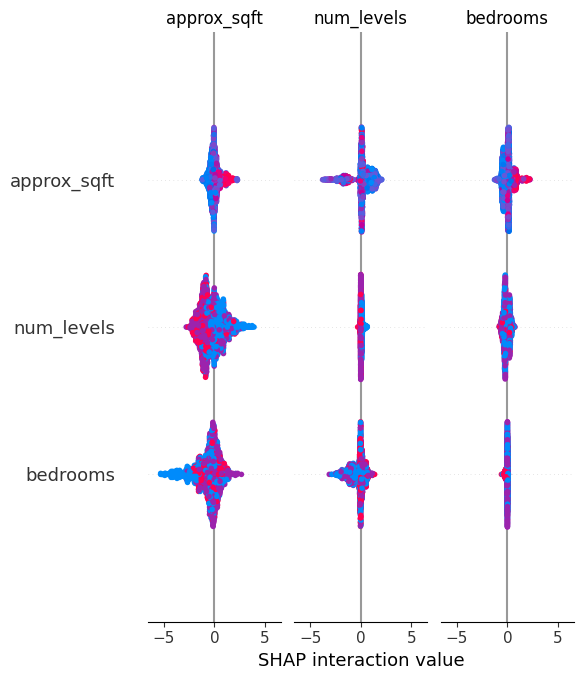

In [ ]:
# SHAP explainer & values

# Small background sample for speed (columns must match training features)
x_bg = X_train_fe_encoded_res.sample(n=min(2000, len(X_train_fe_encoded_res)), random_state=42)

# Build explainer for tree models
# (If you hit version quirks, you can switch to: expl = shap.Explainer(lgb_best, X_bg))
expl = shap.TreeExplainer(final_xgb)
shap_vals = expl.shap_values(x_bg, check_additivity=False)  # list-of-arrays for multiclass

# Human-friendly class names (adjust mapping if needed)
name_to_id = {"attachd": 0, "condo": 1, "detachd": 2}
id_to_name = {v: k for k, v in name_to_id.items()}
classes_ = getattr(best_lgb_o, "classes_", np.sort(np.unique(y_train_fe_encoded_res)))
class_names = [id_to_name.get(int(c), str(c)) for c in classes_]

# Global importance (beeswarm)
# For multiclass, shap.summary_plot accepts a list of [n_classes] arrays
# and will aggregate importance across classes.
shap.summary_plot(shap_vals, x_bg, class_names=class_names, show=True)

<div style="padding:12px 16px; border-radius:8px;">

### 5.2.2 Analysis of the SHAP Interaction Value
#### How to read it
- **Tight cloud around 0** → little/no interaction; features act mostly additively.  
- **Wide vertical spread (both +/–)** → stronger interaction; the effect of one feature **depends on** the other.  
- **Cells on the diagonal** summarize the **main (self) effect** distribution; off-diagonals show **pairwise interactions**.  
- Values are **SHAP interaction values**; sign indicates whether the pair pushes the prediction **down (–)** or **up (+)** relative to the additive sum.

---

#### Key Takeaways
- **Overall interactions are mild.** Most cells are tight around **0**, implying the model is driven primarily by **main effects** rather than pairwise interactions.
- **`approx_sqft × bedrooms` (bottom-middle & middle-bottom)** has the **clearest interaction**:
  - Noticeably wider spread both positive and negative.
  - Interpretation: the influence of square footage on the class **changes with bedroom count** (and vice-versa). Larger homes with many bedrooms may boost the target more than the additive sum; small homes with many bedrooms can reduce it.
- **`approx_sqft × num_levels` (middle-left & top-middle)** is **moderate**:
  - Some spread suggests **layout/levels** modulate how **square footage** contributes.
- **`num_levels × bedrooms` (top-right & right-top)** looks **minor**:
  - Clouds hug 0 → little incremental signal beyond the two features’ individual effects.

</div>


### 5.3 SHAP Bar Chart - Ranks global importance.

➤ Bigger bar ⇒ that feature moves the prediction more (in either direction).

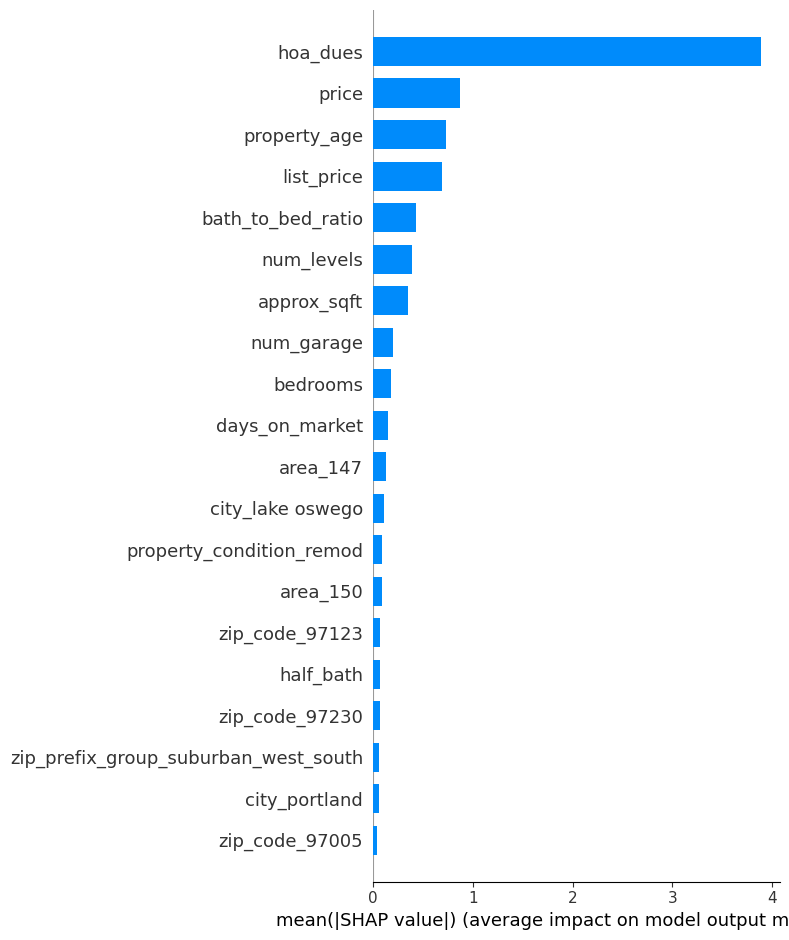

In [ ]:
# Choose the data you want explanations for 
X_bg = X_test_fe  # or X_train_fe.sample(2000, random_state=42) for speed

# Build explainer & SHAP values (handles different SHAP versions)
try:
    # Newer API
    explainer = shap.Explainer(final_xgb, X_bg)      # background from X_bg
    shap_vals = explainer(X_bg)                      # Explanation object
    new_api = True
except Exception:
    # Legacy API
    explainer = shap.TreeExplainer(final_xgb)
    shap_vals = explainer.shap_values(X_bg)          # list/ndarray
    new_api = False

# Pick target class by name or id 
name_to_id = {'attachd': 0, 'condo': 1, 'detachd': 2}
target = "detachd"  # or 2

target_class = name_to_id[target] if isinstance(target, str) else int(target)
classes = np.asarray(final_xgb.classes_)
cls_idx = int(np.where(classes == target_class)[0][0])

# Extract SHAP for that class (robust across SHAP versions) 
if new_api:
    # shap_vals is an Explanation: values shape (n, m, k)
    shap_for_class = shap_vals.values[:, :, cls_idx]
    X_for_plot = X_bg
else:
    if isinstance(shap_vals, list):
        shap_for_class = shap_vals[cls_idx]          # (n, m)
    elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3:
        shap_for_class = shap_vals[:, :, cls_idx]    # (n, m, k) -> (n, m)
    else:
        shap_for_class = shap_vals                   # binary/regression fallback
    X_for_plot = X_bg

# Bar chart of mean |SHAP| for the chosen class 
shap.summary_plot(
    shap_for_class,
    X_for_plot,                # <-- pass FEATURES, not the model
    plot_type="bar",
    feature_names=getattr(X_for_plot, "columns", None),
    show=True
)

<div style="padding:12px 16px; border-radius:8px;">


### 5.3.1 Analysis of the SHAP Feature Importance

#### Key Takeaways 

**Fees & pricing dominate**
- **`hoa_dues`** is the **strongest driver** overall — consistent with **condo/attached** products carrying dues.
- **`list_price`** and **`price`** are next, indicating overall market value strongly separates property types.

**Engineered layout signal matters**
- **`bath_to_bed_ratio`** ranks highly, showing that **layout efficiency** (baths relative to beds) meaningfully shapes predictions.

**Structure/size are important but secondary to fees/price**
- **`num_levels`**, **`approx_sqft`**, **`num_garage`**, **`half_bath`**, **`full_bath`**, and **`bedrooms`** all contribute, reflecting typical differences in form factor across types.

**Condition has signal**
- **`property_condition_new`** and **`property_condition_fixer`** appear in the top features → condition helps the model separate classes.

**Market dynamics show up**
- **`days_on_market`** adds smaller but non-trivial information.

**Location contributes, but below the top drivers**
- **`city_portland`**, **`city_lake oswego`**, **`zip_code_97203`**, **`zip_code_97230`**, **`zip_prefix_group_suburban_west_south`**, and **`area_147`** provide **refinement**, not primary separation in this view.

**Notably absent here**
- **Lot-size features** don’t appear among the top bars in this plot, suggesting their impact is weaker **for this model/view** compared with fees/price, structure, and condition.

</div>


### 5.4 SHAP Dependence Plot - Effect of one feature (and optional interaction).

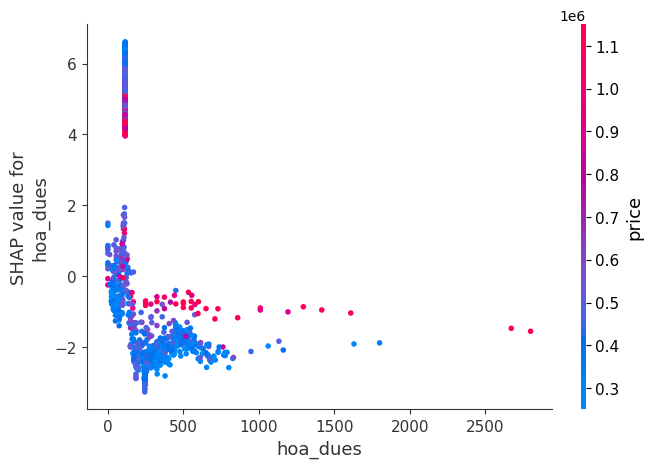

In [ ]:
# --- SHAP dependence plot for a chosen class & feature (LightGBM) ---

# 1) Pick the target class (e.g., detachd = 2) and resolve its index
target_class = 2
classes = getattr(final_xgb, "classes_", np.sort(np.unique(y_test_fe)))
cls_idx = int(np.where(classes == target_class)[0][0])

# 2) Normalize SHAP values to the per-class matrix expected by dependence_plot
if isinstance(shap_vals, list):
    # Common for multiclass: list length == n_classes
    shap_for_class = shap_vals[cls_idx]
elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3:
    # Shape: (n_samples, n_features, n_classes)
    shap_for_class = shap_vals[..., cls_idx]
else:
    # Binary/regression fallback
    shap_for_class = shap_vals

# 3) Choose the feature to plot and (optionally) an interaction partner
top_feat = "hoa_dues"  # <- change to any column in l_bg, e.g., "approx_sqft", "num_levels", etc.
interaction_partner = "auto"  # or use "auto" to let SHAP pick; or set to None for pure main effect

# 4) Draw the dependence plot
shap.dependence_plot(
    ind=top_feat,
    shap_values=shap_for_class,
    features=X_bg,
    interaction_index=interaction_partner,  # "auto", a column name, or None
    show=True
)


<div style="padding:12px 16px; border-radius:8px;">

### 5.4.1 Analysis of SHAP dependence: **`hoa_dues`** (colored by **`price`**)

- **Monotonic, negative effect:** As `hoa_dues` increase, SHAP values trend **downward**, so higher dues push predictions **away from the target class** (detached) and toward alternatives (e.g., condo/attached).
- **Zero / very low dues:** A split behavior—many points are near 0, and a noticeable band has **positive SHAP (up to ~+2)**, which **supports the detached prediction**. This fits the intuition that detached homes often have no HOA.
- **Typical range (≈ \$100–\$400):** Dues here already contribute **negatively** (often −1 to −2.5), indicating a steady pull away from detached.
- **High outliers (≥ \$800):** SHAP values are **strongly negative** (≈ −1 to −3+), acting as a **strong discriminator** against detached.
- **Interaction with `price`:** Coloring suggests **only a mild modulation**—higher-priced homes (magenta) sometimes appear a bit **less negative** at low-to-moderate dues, but the **overall negative relationship holds** across prices.

**Takeaway:** `hoa_dues` is a **powerful separator**. Low/none aligns with **detached** predictions; higher dues systematically **penalize** detached in favor of condo/attached classes.

**Modeling tips**
- Consider a **log/√ transform** or **winsorizing** extreme dues to stabilize outliers.
- Add simple features like **`has_hoa = (hoa_dues > 0)`** and possibly **`hoa_dues_per_sqft`** to capture scale effects.
- Validate with class-wise PDP/ICE to confirm thresholds (e.g., where dues begin to strongly flip predictions).

</div>


# CONCLUSION: XGBoost Performance 

<div style="padding:14px 18px; border-radius:10px;">

## XGBoost performance progression — CV ➜ Validation ➜ Test  
**Class mapping:** `{'attachd': 0, 'condo': 1, 'detachd': 2}`

### 1) Overall metrics comparison
| Split / Source | Accuracy | Macro-F1 | OvR ROC-AUC |
|---|---:|---:|---:|
| **5-Fold CV (mean)** | **0.9625 ± 0.0047** | **0.9340 ± 0.0071** | **0.9945 ± 0.0005** |
| **Validation (Optuna-tuned)** | **0.9631** | **0.9339** | **0.9947** |
| **Test (Optuna-tuned)** | **0.9582** | **0.9244** | **0.9939** |

**Read:** Validation is in line with CV means; test remains very close on accuracy/AUC with a modest Macro-F1 drop — overall **good generalization**.

---

### 2) Per-class F1 across splits
| Class (label) | CV (OOF) F1 | Validation F1 | Test F1 |
|---|---:|---:|---:|
| 0 (attachd) | 0.8798 | 0.8747 | 0.8618 |
| 1 (condo)   | 0.9345 | 0.9403 | 0.9228 |
| 2 (detachd) | 0.9875 | 0.9870 | 0.9884 |

**Read:**  
- **Detachd (2)** stays extremely stable across splits.  
- **Condo (1)** dips on test vs. val, driving most of the Macro-F1 decline.  
- **Attachd (0)** is the most sensitive class; its F1 is slightly lower on test (though recall actually **improves**, see below).

---

### 3) Confusion patterns (Validation ➜ Test)
- **Attachd (0)** misclassified as → **condo (1)**/**detachd (2)**:  
  - **Val:** 17 → 1, 10 → 2  
  - **Test:** 16 → 1, 5 → 2  
  → Test shows **fewer** 0→2 errors and slightly fewer 0→1; recall improves (0.8683 → **0.8976**).
- **Condo (1)** misclassified as → **attachd (0)**/**detachd (2)**:  
  - **Val:** 15 → 0, 3 → 2  
  - **Test:** 27 → 0, 4 → 2  
  → More 1→0 mistakes on test → **recall drops** (0.9472 → **0.9094**).
- **Detachd (2)** misclassified as → **attachd (0)**/**condo (1)**:  
  - **Val:** 9 → 0, 6 → 1  
  - **Test:** 11 → 0, 5 → 1  
  → Tiny changes; class remains highly separable.

---

### 4) Takeaways
- **Generalization:** Test **Accuracy 0.9582** and **AUC 0.9939** sit within CV variance → strong transfer from training/validation.  
- **Macro-F1 dip** is mainly from **condo (1) recall** on test; **attachd (0) recall** actually **improves** on test.  
- **Next steps:**  
  - Target **class-1 vs class-0 boundary** (reduce 1→0 errors): tune class weights/thresholds, add features that better separate condos from attached (e.g., HOA level bins, building age × HOA interactions).  
  - Consider **per-class thresholding** using validation PR curves to balance recall/precision without hurting AUC.  
  - Try a **small CV ensemble** (averaging probabilities across seeds) to stabilize minority-class predictions.

</div>


# 6. Revisiting Model Tuning Conditions (Paul's Section)

My colleague Paul London focused on tweaking model tuning conditions. His results are included below:

*Note: his data was not processed in the same way mine was, so the best model will be derived again after this section.*

While model decisions appear to be dominated by `apx_sqft`, `yr_built`, `hoa_dues`, and `zip`, the other features are also each contributing at least 2% to the model and don't appear to conflict with or influence each other. Because of this, I believe all of these features should be kept for the model. In this section, I keep all features, but when the model is re-tuned later, we instead switch to Sabrina's feature engineering.

## Summary of Results

### Baseline Models

LazyClassifier was used to generate a summary of baseline models with default hyperparameters for initial inspection:

*Note: This is representative data. Exact data vary based on preprocessing conditions.*

|             Model             | Accuracy | Balanced Accuracy | ROC AUC | F1 Score |
| :---------------------------: | :------: | :---------------: | :-----: | :------: |
|         **XGBClassifier**         |   0.94   |        0.91       |   None  |   0.94   |
|         **LGBMClassifier**        |   0.94   |        0.91       |   None  |   0.94   |
|     **RandomForestClassifier**    |   0.94   |        0.90       |   None  |   0.94   |
|       BaggingClassifier       |   0.93   |        0.89       |   None  |   0.93   |
|      ExtraTreesClassifier     |   0.93   |        0.88       |   None  |   0.93   |
|     DecisionTreeClassifier    |   0.92   |        0.87       |   None  |   0.92   |
|       LogisticRegression      |   0.86   |        0.85       |   None  |   0.87   |
|              SVC              |   0.87   |        0.84       |   None  |   0.88   |
|       AdaBoostClassifier      |   0.85   |        0.83       |   None  |   0.87   |
|     CalibratedClassifierCV    |   0.85   |        0.83       |   None  |   0.86   |
|           LinearSVC           |   0.85   |        0.83       |   None  |   0.86   |
|   LinearDiscriminantAnalysis  |   0.84   |        0.83       |   None  |   0.85   |
|         SGDClassifier         |   0.85   |        0.82       |   None  |   0.86   |
|             NuSVC             |   0.84   |        0.81       |   None  |   0.85   |
|        RidgeClassifier        |   0.84   |        0.81       |   None  |   0.85   |
|       RidgeClassifierCV       |   0.84   |        0.81       |   None  |   0.85   |
|         LabelSpreading        |   0.87   |        0.80       |   None  |   0.87   |
|        LabelPropagation       |   0.87   |        0.80       |   None  |   0.87   |
|      ExtraTreeClassifier      |   0.86   |        0.80       |   None  |   0.86   |
|      KNeighborsClassifier     |   0.85   |        0.79       |   None  |   0.86   |
|  PassiveAggressiveClassifier  |   0.82   |        0.79       |   None  |   0.83   |
|          BernoulliNB          |   0.76   |        0.76       |   None  |   0.77   |
|           Perceptron          |   0.83   |        0.76       |   None  |   0.84   |
|        NearestCentroid        |   0.76   |        0.75       |   None  |   0.78   |
|           GaussianNB          |   0.27   |        0.48       |   None  |   0.22   |
| QuadraticDiscriminantAnalysis |   0.28   |        0.47       |   None  |   0.26   |
|        DummyClassifier        |   0.13   |        0.33       |   None  |   0.03   |

### Top Model Candidates

The 3 top-performing models, in bold, in addition to CatBoost (not part of LazyClassifier), were then investigated further:
- XGBClassifier
- LGBMClassifier
- RandomForestClassifier
- CatBoost

### Model Tuning and Testing

Several tuning steps were then employed:

- Adjusting the list of features considered
    - Primary factor in selection was client's feedback about feature importance
    - It is possible to remove additional features based on measured importances above

- Optuna hyperparameter tuning
    - 50 trials for each set of preprocessing conditions initially
    - 500 trials for final model selection using best conditions
    - Preprocessing variation
        - Stratification during data split
        - Encoding type for `X` and `y`

I evaluated eight preprocessing combinations varying in stratification, feature encoding (`X`), and target encoding (`y`). The results follow:

### Summary of Model Candidates

The 8 preprocessing condition combination's tuned models are summarized below. Metrics shown are from the Test dataset.

| Model # | Stratify? | `X` Encoding | `y` Encoding |  Model Type | `n_estimators` | `learning_rate` | `num_leaves`/`depth` | Accuracy | Precision | Recall | F1-score | AUC-ROC |
|:--------:|:---------:|:----------:|:----------:|:-----------:|:------------:|:-------------:|:----------:|:--------:|:---------:|:------:|:--------:|:-------:|
| Model 1 | Y | OHE | OHE | LightGBM | 100          | 0.1208        | 140        | 0.9380   | 0.9380    | 0.9380 | 0.9379   | 0.9817  |
| Model 2 | Y | OHE | LE | LightGBM | 350          | 0.0419        | 132        | 0.9413   | 0.9410    | 0.9413 | 0.9411   | 0.9818  |
| Model 3 | Y | LE | OHE | CatBoost | 1000 | 0.1611 | 10 | 0.9379 | 0.9383 | 0.9380 | 0.9381 | 0.9798 |
| Model 4 | Y | LE | LE | LightGBM | 300 | 0.1472 | 138 | 0.9419 | 0.9416 | 0.9419 | 0.9418 | 0.9805 |
| Model 5 | N | OHE | OHE | LightGBM | 100          | 0.1569        | 140        | **0.9479**   | **0.9481**    | **0.9479** | **0.9480**   | **0.9912**  |
| Model 6 | N | OHE | LE | LightGBM | 250          | 0.1251        | 128        | 0.9472   | 0.9478    | 0.9472 | 0.9475   | 0.9903  |
| Model 7 | N | LE | OHE | LightGBM | 500 | 0.0640 | 140 | 0.9452 | 0.9456 | 0.9452 | 0.9454 | 0.9896 |
| Model 8 | N | LE | LE | LightGBM | 450 | 0.2035 | 133 | 0.9452 | 0.9455 | 0.9452 | 0.9453 | 0.9899 |


These results demonstrate only subtle differences in performance across the 8 conditions tested. This likely corresponds to minor variance between Optuna runs, and also due to a relatively small number of trials per run (50). Because of this, and because input features can continue to be tweaked later, I have chosen to default to standard practices, outlined below.

#### 1. Data Splitting

**Stratified splitting** is typically preferred to ensure representative evaluation across all classes, especially minority ones. In the given dataset, the DETACHED type outnumbers each of the other two categories by a factor of 4, making stratification especially important. This imbalance is primarily addressed later via SMOTE, but it is also important to keep proportional representation while splitting the data.

#### 2. Feature (`X`) Encoding

**One-hot encoding** is generally preferred when the categorical features do not have numerous possible values. It is generally more robust than label encoding as long as the addition of a large amount of new features from its use doesn't negatively impact model training.

#### 3. Target (`y`) Encoding

For the target, **label encoding** is perfectly sufficient, since it is just assigning the categories to integers which my chosen top model candidates handle natively. There is no need to introduce the added complexity of one-hot encoding here.

### Final Model Selection and Results

Based on these choices, I reran Optuna hyperparameter tuning over 500 trials with the conditions below to determine the overall best model, and stored it in `best_model.pkl`.

- Stratification enabled during `train_test_split`
- OneHot encoding for features (`X`)
- Label encoding for target (`y`)

---
The best performing model is: **LGBMClassifier**

---

#### Model Performance Metrics
|   Metric  | Validation |  Test  |    Δ    |
| :-------: | :--------: | :----: | :-----: |
|  Accuracy |   0.9373   | 0.9426 |  0.0053 |
| Precision |   0.9383   | 0.9427 |  0.0044 |
|   Recall  |   0.9373   | 0.9426 |  0.0053 |
|  F1 Score |   0.9377   | 0.9426 |  0.0049 |
|  AUC-ROC  |   0.9860   | 0.9812 |  0.0049 |

These metrics are satisfactory on their own and the validation/test difference (Δ) is minimal.

#### Confusion Matrix (Validation)
|        | Pred 0 | Pred 1 | Pred 2 |
| :----: | :----: | :----: | :----: |
| True 0 |   162  |   16   |   21   |
| True 1 |   16   |   306  |    5   |
| True 2 |   28   |    9   |   952  |

*0 = ATTACHED, 1 = CONDO, 2 = DETACHED*

#### Confusion Matrix (Test)
|        | Pred 0 | Pred 1 | Pred 2 |
| :----: | :----: | :----: | :----: |
| True 0 |   162  |   14   |   23   |
| True 1 |   19   |   301  |    6   |
| True 2 |   20   |    5   |   965  |

*0 = ATTACHED, 1 = CONDO, 2 = DETACHED*

This model performs strongest on DETACHED (Recall = 0.976) and CONDO (0.939), while ATTACHED (0.839) remains the most challenging class to predict accurately.

#### Hyperparameters
|  Hyperparameter |  Value |
| :-------------: | :----: |
|  `n_estimators` |   400  |
| `learning_rate` | 0.0502 |
|   `num_leaves`  |   138  |

#### Other Attributes
|         Attribute         |  Value  |
| :-----------------------: | :-----: |
|        `base_score`       |   None  |
|         `booster`         |   None  |
|       `eval_metric`       | logloss |
|        `verbosity`        |    0    |
|         `missing`         |   nan   |
|    `enable_categorical`   |  False  |
|     `feature_weights`     |   None  |
|          `gamma`          |   None  |
| `interaction_constraints` |   None  |
|     `importance_type`     |   None  |
|         `device `         |   None  |

# 7. REVISIT MODEL TUNING

We will re-tune the model one final time, using the feature and model conditions outlined above, then save it in `model.pkl` later.

In [395]:
# Sabrina's original CV loop to define X and y training and validation sets
for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train_fe_encoded_res, y_train_fe_encoded_res), 1):
    X_tr, X_va = X_train_fe_encoded_res.iloc[tr_idx], X_train_fe_encoded_res.iloc[va_idx]
    y_tr, y_va = y_train_fe_encoded_res.iloc[tr_idx], y_train_fe_encoded_res.iloc[va_idx]

# Map Sabrina's CV loop (train) and valid/test DataFrames to work with Paul's model_evaluation function (simpler method to avoid changing the function)
X_train_enc_res = X_train_fe_encoded_res
y_train_enc_res = y_train_fe_encoded_res

X_valid_enc = X_val_fe_encoded
y_valid_enc = y_val_fe_encoded

X_test_enc = X_test_fe_encoded
y_test_enc = y_test_fe_encoded

# Copying random state from above
state = 42

# Paul's tuning function
def model_evaluation(num_trials):
    """
    Perform automated model selection, hyperparameter optimization, and evaluation for classification tasks.
    (Supports: RandomForest, CatBoost, XGBoost, LightGBM)
    """
    # --OPTUNA OBJECTIVE FUNCTION--
    def objective(trial):
        model_name = trial.suggest_categorical("model", ["RandomForest", "CatBoost", "XGBoost", "LightGBM"])

        if model_name == "RandomForest":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
            }
            model = RandomForestClassifier(**params, random_state=state)

        elif model_name == "CatBoost":
            params = {
                "iterations": trial.suggest_int("iterations", 200, 1000, step=100),
                "depth": trial.suggest_int("depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            }
            model = CatBoostClassifier(**params, verbose=0, random_state=state)

        elif model_name == "XGBoost":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
            }
            model = XGBClassifier(**params, verbosity=0, eval_metric="logloss", random_state=state)

        elif model_name == "LightGBM":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 20, 150),
            }
            model = LGBMClassifier(**params, verbose=-1, random_state=state)

        score = cross_val_score(model, X_train_enc_res, y_train_enc_res, cv=5, scoring="accuracy").mean()
        return score

    # --RUN OPTUNA--
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=num_trials, n_jobs=-1, show_progress_bar=True)

    # Save trial history
    import os
    os.makedirs("optuna_log", exist_ok=True)
    study.trials_dataframe().to_csv("optuna_log/optuna_trials.csv", index=False)

    # Extract best model + params
    best_params = study.best_trial.params
    best_model_name = best_params.pop("model")

    if best_model_name == "RandomForest":
        best_model = RandomForestClassifier(**best_params, random_state=state)
    elif best_model_name == "CatBoost":
        best_model = CatBoostClassifier(**best_params, verbose=0, random_state=state)
    elif best_model_name == "XGBoost":
        best_model = XGBClassifier(**best_params, verbosity=0, eval_metric="logloss", random_state=state)
    elif best_model_name == "LightGBM":
        best_model = LGBMClassifier(**best_params, verbose=-1, random_state=state)

    # Fit final model
    best_model.fit(X_train_enc_res, y_train_enc_res)

    # --PREDICTIONS & METRICS--
    def compute_metrics(model, X, y):
        y_pred = model.predict(X)
        metrics = {
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred, average="weighted", zero_division=0),
            "recall": recall_score(y, y_pred, average="weighted", zero_division=0),
            "f1": f1_score(y, y_pred, average="weighted", zero_division=0),
            "confusion_matrix": confusion_matrix(y, y_pred),
            "report": classification_report(y, y_pred, zero_division=0)
        }
        try:
            y_prob = model.predict_proba(X)
            metrics["auc_roc"] = roc_auc_score(pd.get_dummies(y), y_prob, multi_class="ovr")
        except:
            metrics["auc_roc"] = None
        return metrics

    metrics_valid = compute_metrics(best_model, X_valid_enc, y_valid_enc)
    metrics_test = compute_metrics(best_model, X_test_enc, y_test_enc)

    # --FEATURE IMPORTANCES (UNIVERSAL HANDLING)--
    try:
        importances = best_model.feature_importances_
    except AttributeError:
        importances = np.zeros(X_train_enc_res.shape[1])

    # Handle feature names safely
    if hasattr(best_model, "feature_names_in_"):
        feature_names = best_model.feature_names_in_
    elif hasattr(best_model, "feature_names_"):
        feature_names = best_model.feature_names_
    else:
        feature_names = X_train_enc_res.columns if isinstance(X_train_enc_res, pd.DataFrame) else [f"feat_{i}" for i in range(X_train_enc_res.shape[1])]

    # Build importance DataFrame
    feat_importances = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # Group OHE columns by base feature
    feat_importances["base_feature"] = feat_importances["feature"].apply(
        lambda x: re.sub(r"^(city|area|property_condition|zip_code|year_built|zip_prefix_group)_.+$", r"\1", x)
    )
    grouped_importance = (
        feat_importances.groupby("base_feature")["importance"].sum()
        .sort_values(ascending=False)
        .reset_index()
    )
    total = grouped_importance["importance"].sum()
    grouped_importance["importance_pct"] = (grouped_importance["importance"] / total * 100).round(2)

    print(f"\n✅ Best Model: {best_model_name}")
    print(f"Best Hyperparameters: {best_params}\n")
    print("Validation Metrics:", metrics_valid)
    print("Test Metrics:", metrics_test)

    # --PLOTS--
    grouped_importance.plot(kind="barh", x="base_feature", y="importance_pct", legend=False, figsize=(10, 8))
    plt.gca().invert_yaxis()
    plt.title("Feature Importance to Model Decisions")
    plt.xlabel("Importance (%)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Optuna plots
    plot_optimization_history(study).show()
    plot_param_importances(study).show()
    plot_slice(study).show()
    plot_parallel_coordinate(study).show()

    return (
        best_model, best_params, study, feat_importances,
        metrics_valid, metrics_test
    )

In [394]:
# Run model optimization with 100 trials
best_model, best_params, study, feat_importances, metrics_valid, metrics_test = model_evaluation(100)

[I 2025-10-20 11:59:24,145] A new study created in memory with name: no-name-2676fe1b-e66c-428d-a7be-206a27ec8a55


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-20 11:59:44,810] Trial 11 finished with value: 0.8461182689131153 and parameters: {'model': 'RandomForest', 'n_estimators': 100, 'max_depth': 5}. Best is trial 11 with value: 0.8461182689131153.
[I 2025-10-20 12:00:03,946] Trial 5 finished with value: 0.9618764453254046 and parameters: {'model': 'RandomForest', 'n_estimators': 100, 'max_depth': 17}. Best is trial 5 with value: 0.9618764453254046.
[I 2025-10-20 12:00:20,260] Trial 8 finished with value: 0.8721506442021804 and parameters: {'model': 'RandomForest', 'n_estimators': 250, 'max_depth': 7}. Best is trial 5 with value: 0.9618764453254046.
[I 2025-10-20 12:00:24,820] Trial 1 finished with value: 0.8276841757515692 and parameters: {'model': 'RandomForest', 'n_estimators': 450, 'max_depth': 3}. Best is trial 5 with value: 0.9618764453254046.
[I 2025-10-20 12:00:42,231] Trial 13 finished with value: 0.9145688800792865 and parameters: {'model': 'XGBoost', 'n_estimators': 100, 'learning_rate': 0.02258078961635562, 'max_dep

NameError: name 'X_valid_enc_res' is not defined

In [ ]:
# Create and check Pickle file containing model
import os
os.makedirs("pickle", exist_ok=True)

# Save the best model with Pickle
with open("pickle/model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Check contents of model.pkl - will be used for dashboard
with open("pickle/model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
print(loaded_model)

LGBMClassifier(learning_rate=0.14429314831294957, n_estimators=350,
               num_leaves=138, random_state=42, verbose=-1)


In [ ]:
# Retrieve raw data since it was written over
data_raw = pd.read_csv("Dataset.csv")

# Create random sample of 5 rows of X_test_fe and corresponding targets in y_test_fe then pull from raw data
sample = X_test_fe.sample(n=5, random_state=45)
sample = data_raw.loc[sample.index]

info_sample = data_raw.loc[sample.index, ['MLS#', 'Address', 'Type']]

raw_minus_sample = data_raw.drop(index=sample.index)

# Inspect
print("Sample:")
print(sample)
print()
print("MLS#, Address, and Property Type:")
print(info_sample) # for screenshot
print()
print(data_raw.shape)
print(sample.shape)
print(raw_minus_sample.shape)

# Save to .csv
sample.to_csv("sample_data/sample.csv", index=False)
raw_minus_sample.to_csv("sample_data/raw_minus_sample.csv", index=False)
#sample_df.to_csv("sample_data/sample_df.csv")

Sample:
          MLS#     Type Prop. Cat. Prop. Cond.      Tax  \
4205  23651293    CONDO        RES       REMOD        0   
4926  23405775  DETACHD        RES      RESALE  5358.08   
6113  24428163    CONDO        RES       FIXER  4609.68   
4749  24500764  DETACHD        RES         NEW        0   
2667  23421198  ATTACHD        RES      RESALE  3081.24   

                    Address         City    Zip Area BD Baths # Levels  \
4205  13943 SE Lincoln ST B     Portland  97233  143  2     1        1   
4926       1144 SE 85TH AVE     Portland  97216  143  5     2        3   
6113    5054 FOOTHILLS DR H  Lake Oswego  97034  147  3     2        1   
4749       5825 SE LIEBE ST     Portland  97206  143  2   1.1        2   
2667      1521 NE 176TH AVE     Portland  97230  142  3   2.1        2   

     Apx Sqft Price SqFt Sld Price Sqft    Lot Size  Pend. Date DOM CDOM  \
4205      480        572            541         NaN  12/28/2023  98   98   
4926     2125        188            171 

# 8. CONCLUSION

The final best model is as follows:

---
Model Type:

**LightGBM**

---

#### Model Performance Metrics
|   Metric  | Validation |  Test  |    Δ   |
| :-------: | :--------: | :----: | :----: |
|  Accuracy |   0.9656   | 0.9607 | 0.0049 |
| Precision |   0.9654   | 0.9612 | 0.0042 |
|   Recall  |   0.9656   | 0.9607 | 0.0049 |
|  F1 Score |   0.9655   | 0.9608 | 0.0047 |
|  AUC-ROC  |   0.9944   | 0.9932 | 0.0012 |

These metrics are satisfactory on their own and the validation/test difference (Δ) is minimal.

#### Confusion Matrix (Validation)
|        | Pred 0 | Pred 1 | Pred 2 |
| :----: | :----: | :----: | :----: |
| True 0 |   179  |   15   |   11   |
| True 1 |   12   |   325  |    4   |
| True 2 |    9   |    5   |  1067  |

*0 = ATTACHED, 1 = CONDO, 2 = DETACHED*

#### Confusion Matrix (Test)
|        | Pred 0 | Pred 1 | Pred 2 |
| :----: | :----: | :----: | :----: |
| True 0 |   183  |   13   |    9   |
| True 1 |   22   |   314  |    6   |
| True 2 |    9   |    5   |  1067  |

*0 = ATTACHED, 1 = CONDO, 2 = DETACHED*

This model performs strongest on DETACHED (Recall = 0.9870) while CONDO (0.9181) and ATTACHED (0.8927) remain slightly more challenging class to predict accurately.

#### Hyperparameters
|  Hyperparameter |  Value |
| :-------------: | :----: |
|  `n_estimators` |   350  |
| `learning_rate` | 0.1443 |
|   `num_leaves`  |   138  |

#### Other Attributes
|         Attribute         |  Value  |
| :-----------------------: | :-----: |
|        `base_score`       |   None  |
|         `booster`         |   None  |
|       `eval_metric`       | logloss |
|        `verbosity`        |    0    |
|         `missing`         |   nan   |
|    `enable_categorical`   |  False  |
|     `feature_weights`     |   None  |
|          `gamma`          |   None  |
| `interaction_constraints` |   None  |
|     `importance_type`     |   None  |
|         `device `         |   None  |

`model.pkl` will be used in an interactive Streamlit dashboard for the client to predict property type.

The best model was found to be LightGBM (see above) and was stored in model.pkl for use on the interactive dashboard for the client.